# ACC Aim 1: Description of Hit Exposure

The purpose of this notebook is to give a briefly explain the calculations behind a statistical description of the hit exposure of University of Tulsa's football team during the 2017 season.

The first step in the process was to compile the data from disperse tables into a single table. For the analysis program that we'll be using, we call this single table a data frame. The answer the proposed questions, we've put together three data frames. The first normalizes the number of hits by the number of players playing a given position. This will allow us to answer those questions which seek a "per position" answer. We'll call this first data frame `df_per_position`. The second data frame normalizes the hit data by the total number of active players involved in the given activity. This will allow us to answer the questions that seek an answer "across all positions." The second data frame will be called `df_per_activity`. The third data frame normalizes the data by 'player-minutes'. The 'player-minute' normalization will be further explained below. The third data frame will be called `df`. Snippets of the resulting data frames are shown below for reference.

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from scipy.stats import wilcoxon

%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_rows = 100

def printmd(string):
    display(Markdown(string))

In [195]:
df_per_position = (pd.read_csv('compiled_by_position.csv', index_col=0)
                     .assign(date=lambda x: pd.to_datetime(x.date))
                     .set_index('date'))
df_per_position.head()

,activity,before_break,event,h2,h3,h4,h5,player,type
date,,,,,,,,,
2017-07-31 19:05:00,pre,True,fall camp practice #1,0.0,0.0,0.0,0.0,linebacker,camp
2017-07-31 19:05:00,pre,True,fall camp practice #1,0.0,1.0,0.0,0.0,off guard,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,0.0,0.0,0.0,0.0,tight end,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,0.0,0.0,0.0,0.0,wide receiver,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,1.0,0.0,0.0,0.0,off guard,camp


In [197]:
df_per_activity = (pd.read_csv('compiled_by_activity.csv', index_col=0)
                     .assign(date=lambda x: pd.to_datetime(x.date))
                     .set_index('date'))
df_per_activity.head()

,activity,before_break,event,h2,h3,h4,h5,player,type
date,,,,,,,,,
2017-07-31 19:05:00,pre,True,fall camp practice #1,0.000000,0.000000,0.0,0.0,linebacker,camp
2017-07-31 19:05:00,pre,True,fall camp practice #1,0.000000,0.111111,0.0,0.0,off guard,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,0.000000,0.000000,0.0,0.0,tight end,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,0.000000,0.000000,0.0,0.0,wide receiver,camp
2017-07-31 19:10:00,pat/fg,True,fall camp practice #1,0.111111,0.000000,0.0,0.0,off guard,camp


In [234]:
df = pd.read_csv('compiled_by_event_time.csv', index_col='day', parse_dates=True)
df.head()

,event,before_break,event_type,h2,h3,h4,h5,total_players,def_players,off_players,...,off_min,player_min,sum24,sum34,n2,n3,n4,n5,n24,n34
day,,,,,,,,,,,,,,,,,,,,,
2017-07-31,fall camp practice #1,post,camp,0.0,1.0,0.0,0.0,19,10,9,...,53.0,1007.0,1.0,1.0,0.000000,0.000993,0.000000,0.000000,0.000993,0.000993
2017-07-31,fall camp practice #1,pre,camp,1.0,1.0,0.0,0.0,19,10,9,...,57.0,1183.0,2.0,1.0,0.000845,0.000845,0.000000,0.000000,0.001691,0.000845
2017-08-01,fall camp practice #2,post,camp,2.0,2.0,0.0,0.0,20,10,10,...,50.0,1030.0,4.0,2.0,0.001942,0.001942,0.000000,0.000000,0.003883,0.001942
2017-08-01,fall camp practice #2,pre,camp,1.0,1.0,0.0,0.0,20,10,10,...,57.0,1240.0,2.0,1.0,0.000806,0.000806,0.000000,0.000000,0.001613,0.000806
2017-08-02,fall camp practice #3,post,camp,18.0,15.0,3.0,1.0,19,9,10,...,52.0,988.0,36.0,18.0,0.018219,0.015182,0.003036,0.001012,0.036437,0.018219


Since many of the questions only ask for answers for "bin 5" hits and "the sum of bins 2-4" hits, we'll add a column to our data frame that is the summation of the bins 2-4.

In [199]:
df_per_position['sum24'] = (df_per_position.h2
                            + df_per_position.h3
                            + df_per_position.h4)

df_per_activity['sum24'] = (df_per_activity.h2
                            + df_per_activity.h3
                            + df_per_activity.h4)

### Question 1: What is the exposure to hits based on player position over all games?

To answer this question, we need two things: 1) hits normalized by player position and 2) the normalized hit data for just the games. We'll gather and show the first few lines of this data below.

In [200]:
games = df_per_position[df_per_position.type == 'game']
games.head()

,activity,before_break,event,h2,h3,h4,h5,player,type,sum24
date,,,,,,,,,,
2017-08-31 17:50:00,pre,True,Oklahoma State Game,0.5,0.0,0.0,0.0,running back,game,0.5
2017-08-31 17:50:00,pre,True,Oklahoma State Game,0.0,0.0,0.0,0.0,wide receiver,game,0.0
2017-08-31 17:55:00,pre,True,Oklahoma State Game,0.5,0.0,0.0,0.0,wide receiver,game,0.5
2017-08-31 18:00:00,pre,True,Oklahoma State Game,0.5,0.0,0.0,0.0,linebacker,game,0.5
2017-08-31 18:00:00,pre,True,Oklahoma State Game,0.0,0.0,0.0,0.0,off guard,game,0.0


Now, we'll group the position normalized game data by game and by player. The grouped data is then summed, resulting in the average number of hits for a given position during the given game. A sampling of the resulting summation is shown. 

In [201]:
avg_hits = games.groupby(['event', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']].sum()
avg_hits.sample(5)

,event,player,h2,h3,h4,h5,sum24
84,S Methodist Game,wide receiver,3.0,1.0,0.0,0.5,4.0
20,Louisiana Game,def tackle,2.5,0.5,0.5,0.0,3.5
24,Louisiana Game,running back,9.5,4.0,0.0,0.5,13.5
61,Oklahoma State Game,off guard,3.5,2.5,0.5,0.0,6.5
1,Conneticut Game,def end,8.5,7.0,3.0,3.0,18.5


Finally, considering each position, the median value of the average hits is taken. The final results are below.

In [202]:
avg_hits.groupby('player').aggregate(np.median)

,h2,h3,h4,h5,sum24
player,,,,,
cornerback,2.00,1.00,0.00,0.00,3.25
def end,8.25,4.50,2.00,1.00,15.25
def tackle,4.50,1.50,0.50,0.00,7.00
linebacker,6.75,4.50,1.50,1.25,12.50
off guard,4.00,2.00,0.50,0.00,6.75
off tackle,5.00,2.50,0.25,0.00,8.50
running back,9.00,7.50,3.50,1.00,20.75
safety,3.00,1.00,0.50,0.00,5.00
tight end,4.25,4.00,1.50,0.25,10.75


Here, we're presenting the interquartile and median values as well as box plots for all of the bins plus the sum of bins 1-4. The sum of bins 1-4 has been put on a separate subplot as to not overly compress the individual bin data, but please note the changes in y-axis values.

### Results for Cornerback

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.375,0.875,0.0,0.0,2.75
Median,2.000,1.000,0.0,0.0,3.25
75 Percentile,2.125,1.625,0.5,0.5,4.50


##### Box Plots

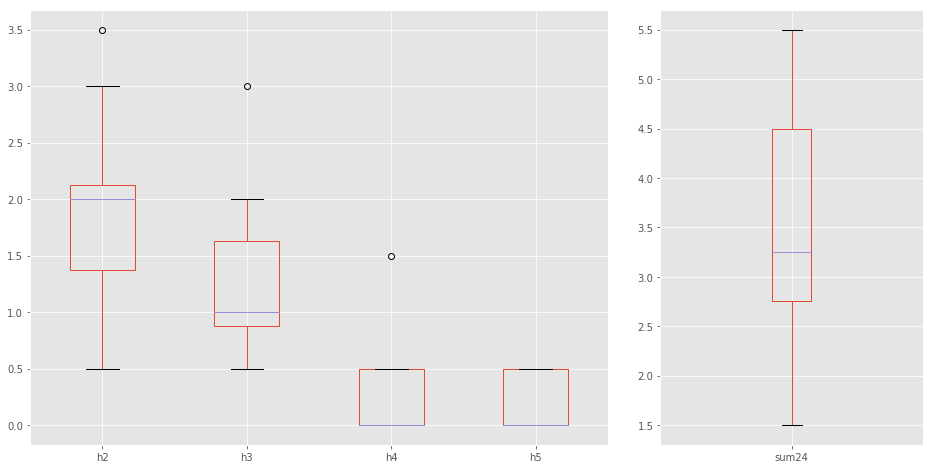

### Results for Def End

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,7.25,3.500,1.25,0.500,11.625
Median,8.25,4.500,2.00,1.000,15.250
75 Percentile,9.50,5.875,2.50,1.625,17.750


##### Box Plots

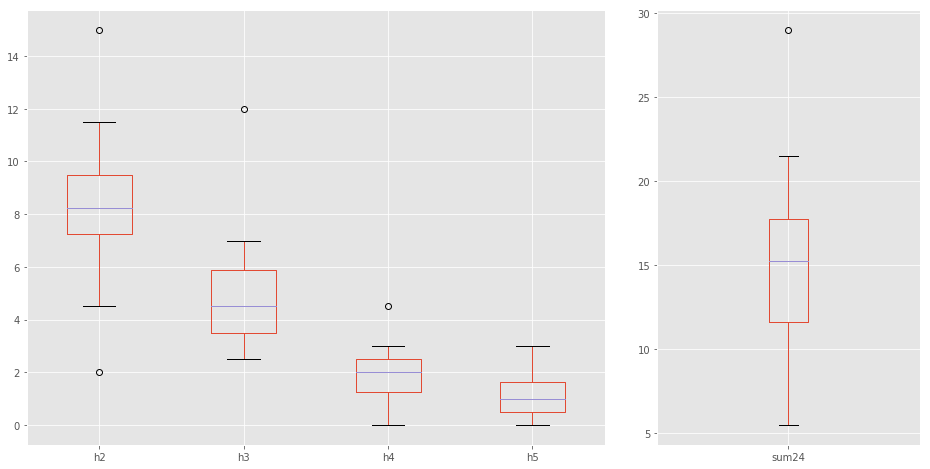

### Results for Def Tackle

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.125,0.375,0.0,0.0,2.875
Median,4.500,1.500,0.5,0.0,7.000
75 Percentile,6.250,8.250,1.0,0.0,15.250


##### Box Plots

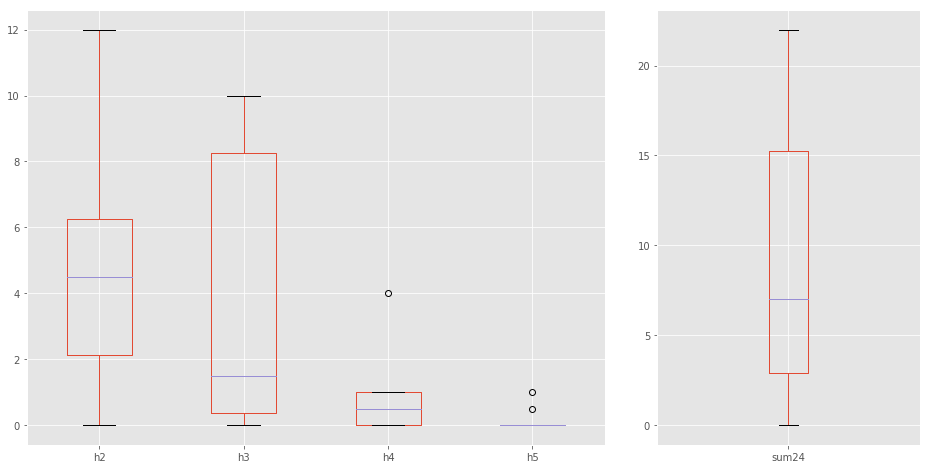

### Results for Linebacker

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,4.875,3.875,1.000,1.000,10.75
Median,6.750,4.500,1.500,1.250,12.50
75 Percentile,7.000,6.125,2.125,1.625,14.75


##### Box Plots

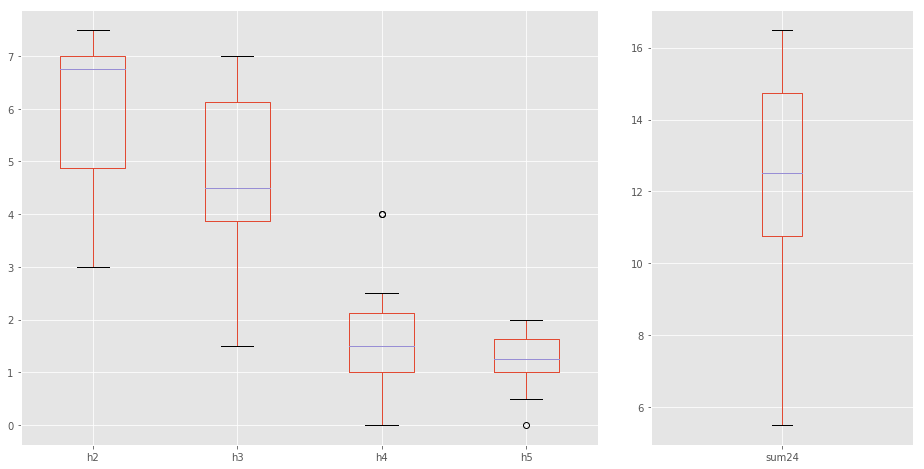

### Results for Off Guard

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,3.375,1.500,0.0,0.0,4.50
Median,4.000,2.000,0.5,0.0,6.75
75 Percentile,6.125,3.125,1.0,0.0,10.50


##### Box Plots

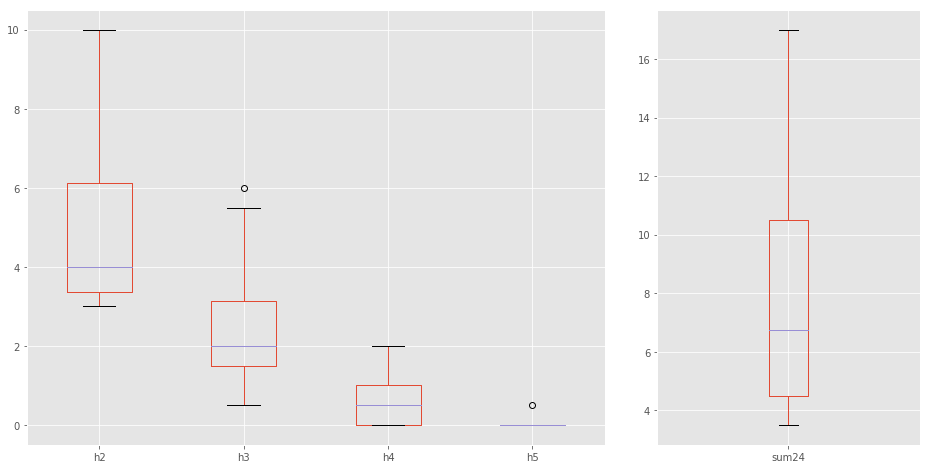

### Results for Off Tackle

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.75,1.000,0.00,0.0,2.750
Median,5.00,2.500,0.25,0.0,8.500
75 Percentile,7.25,3.875,0.50,0.0,11.125


##### Box Plots

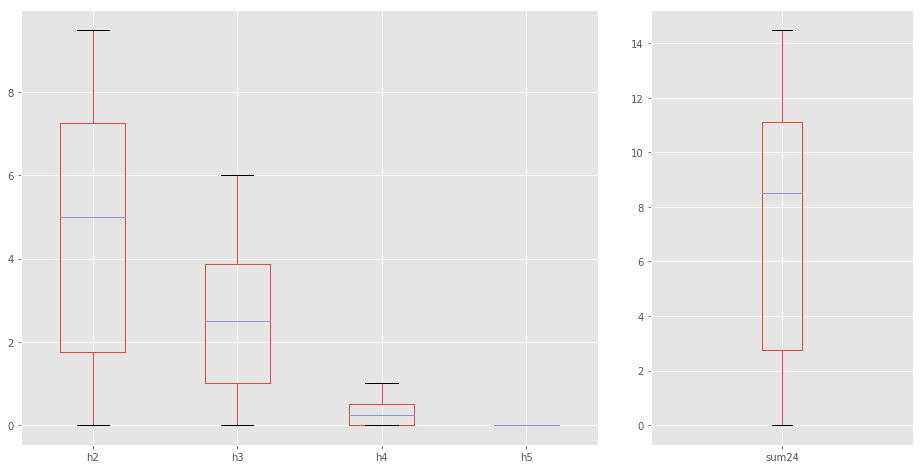

### Results for Running Back

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,6.75,3.75,1.5,0.875,14.625
Median,9.00,7.50,3.5,1.000,20.750
75 Percentile,12.00,11.25,4.5,2.000,28.250


##### Box Plots

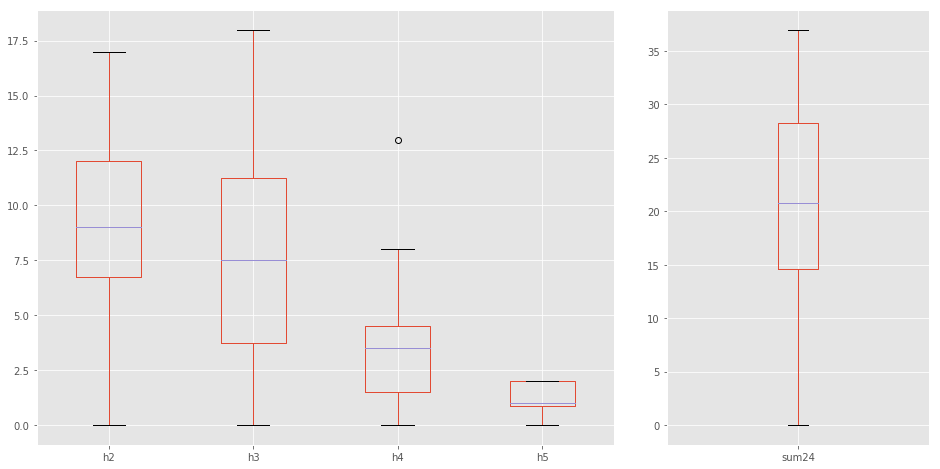

### Results for Safety

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.0,1.0,0.5,0.0,4.5
Median,3.0,1.0,0.5,0.0,5.0
75 Percentile,3.5,3.0,1.0,1.0,6.0


##### Box Plots

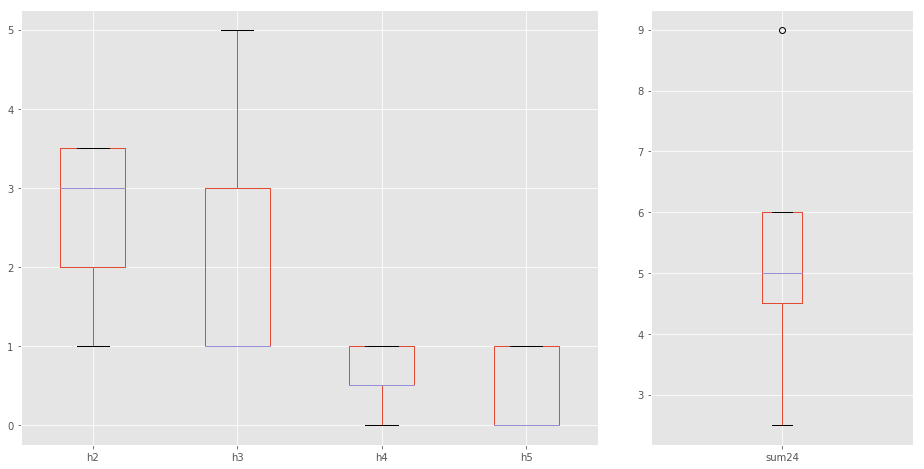

### Results for Tight End

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,3.375,2.500,1.00,0.00,7.50
Median,4.250,4.000,1.50,0.25,10.75
75 Percentile,5.125,5.625,2.25,1.00,14.50


##### Box Plots

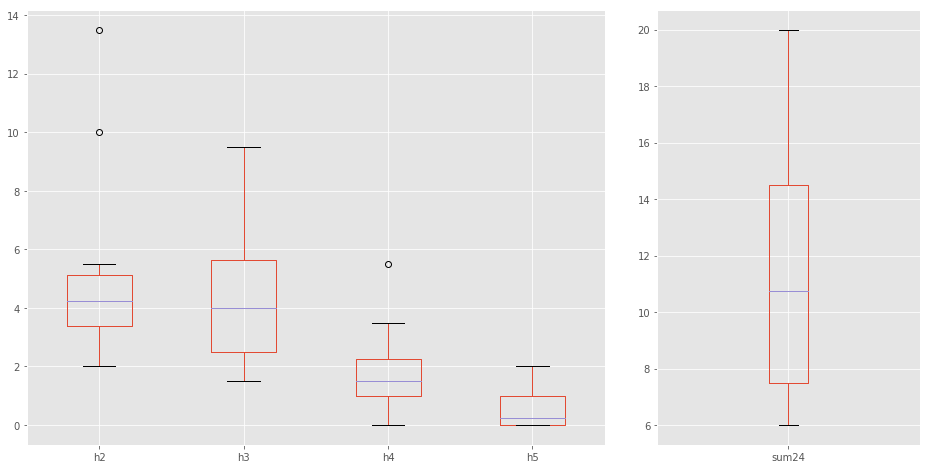

### Results for Wide Receiver

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.875,0.00,0.000,0.000,1.375
Median,3.250,0.75,0.000,0.000,4.250
75 Percentile,3.625,1.00,0.125,0.125,5.125


##### Box Plots

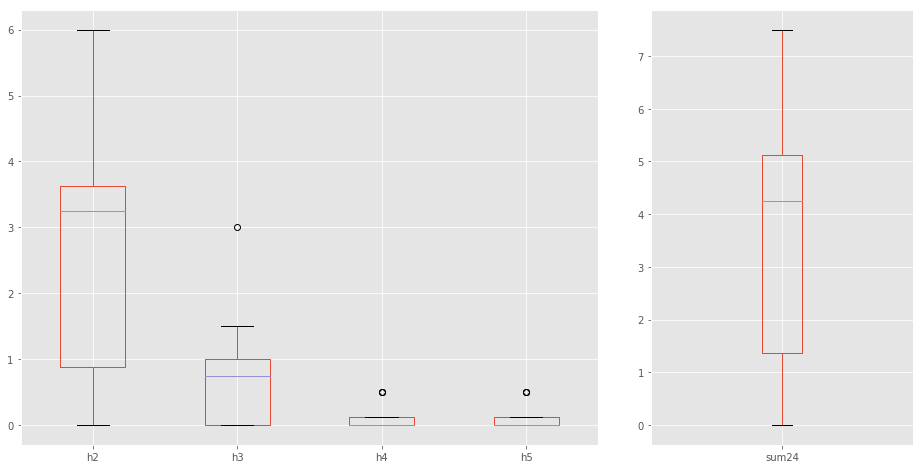

In [203]:
grps = (games.groupby(['event', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
             .sum()
             .groupby('player'))
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 2: What is the exposure to hits based on player position over all practices?

The code below does the same as for games (as above), but this time with the practice data. Intermediate steps aren't shown. The final results are in the table and plots below.

In [204]:
practices = df_per_position[df_per_position.type != 'game']
(practices.groupby(['event', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
          .sum()
          .groupby('player')
          .aggregate(np.median))

,h2,h3,h4,h5,sum24
player,,,,,
cornerback,0.5,0.0,0.0,0.0,0.50
def end,2.0,1.0,0.0,0.0,3.25
def tackle,1.0,0.0,0.0,0.0,1.00
linebacker,1.5,0.5,0.0,0.0,2.25
off guard,1.5,0.0,0.0,0.0,2.00
off tackle,0.5,0.0,0.0,0.0,1.00
running back,1.0,0.5,0.0,0.0,1.50
safety,0.5,0.0,0.0,0.0,1.00
tight end,2.5,2.0,0.5,0.0,6.25


### Results for Cornerback

  Number of Data Points: 39


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.25,0.00,0.0,0.0,0.5
Median,0.50,0.00,0.0,0.0,0.5
75 Percentile,1.00,0.25,0.0,0.0,1.5


##### Box Plots

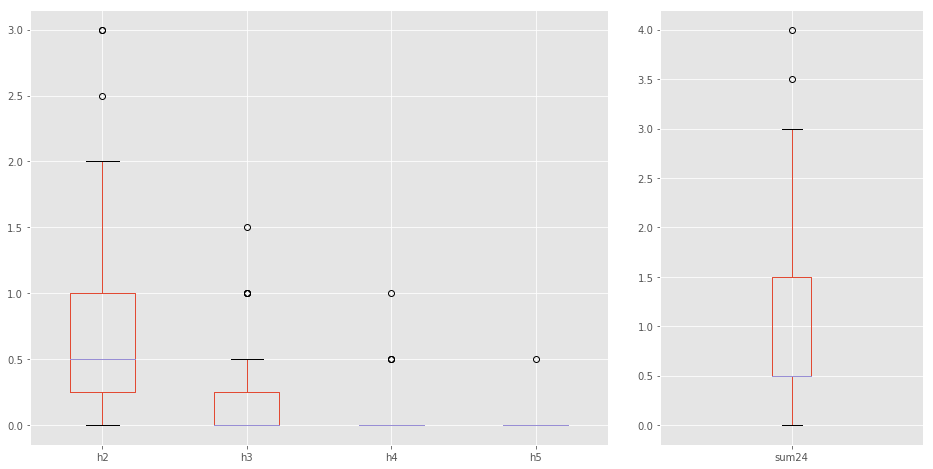

### Results for Def End

  Number of Data Points: 52


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.0,0.5,0.0,0.0,1.875
Median,2.0,1.0,0.0,0.0,3.250
75 Percentile,4.0,3.0,1.0,0.5,6.125


##### Box Plots

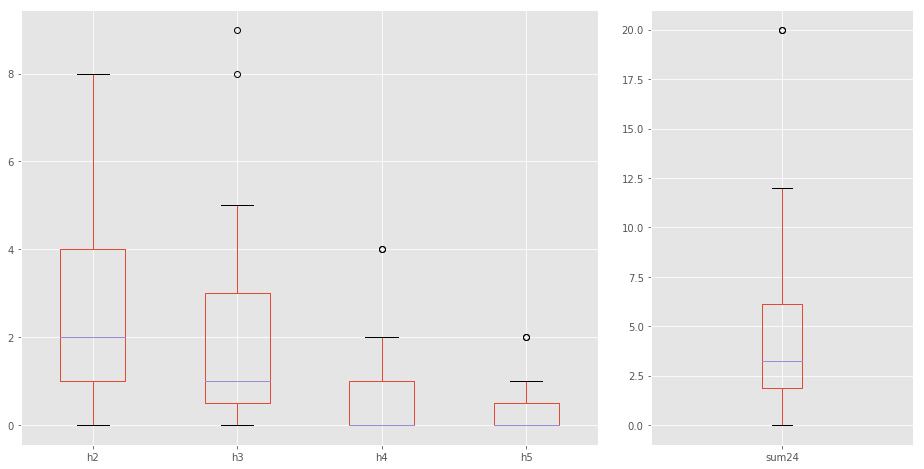

### Results for Def Tackle

  Number of Data Points: 51


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.0,0.0,0.0,0.0
Median,1.00,0.0,0.0,0.0,1.0
75 Percentile,1.75,0.5,0.0,0.0,2.0


##### Box Plots

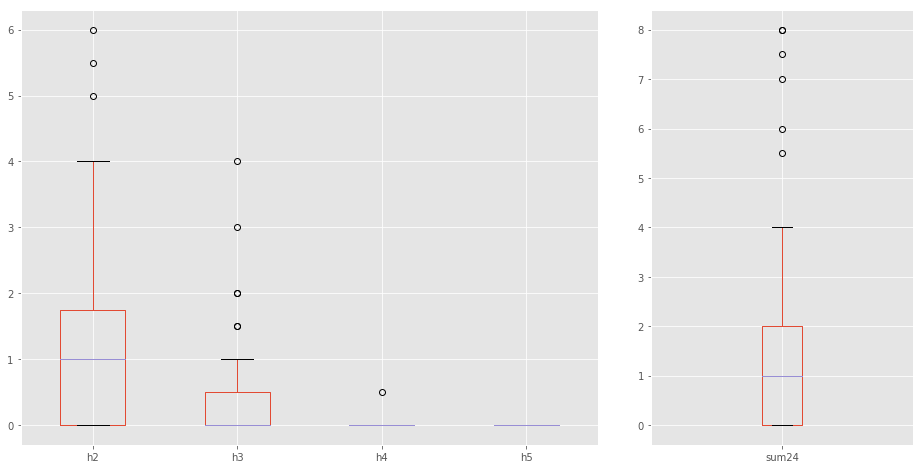

### Results for Linebacker

  Number of Data Points: 56


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,1.00
Median,1.5,0.5,0.0,0.0,2.25
75 Percentile,2.5,1.0,0.0,0.0,4.00


##### Box Plots

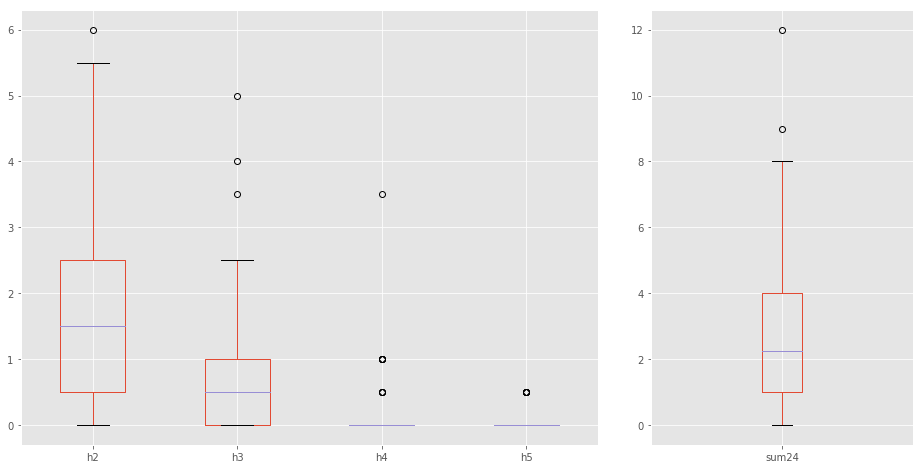

### Results for Off Guard

  Number of Data Points: 43


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.50,0.00,0.0,0.0,0.75
Median,1.50,0.00,0.0,0.0,2.00
75 Percentile,2.75,0.75,0.0,0.0,3.50


##### Box Plots

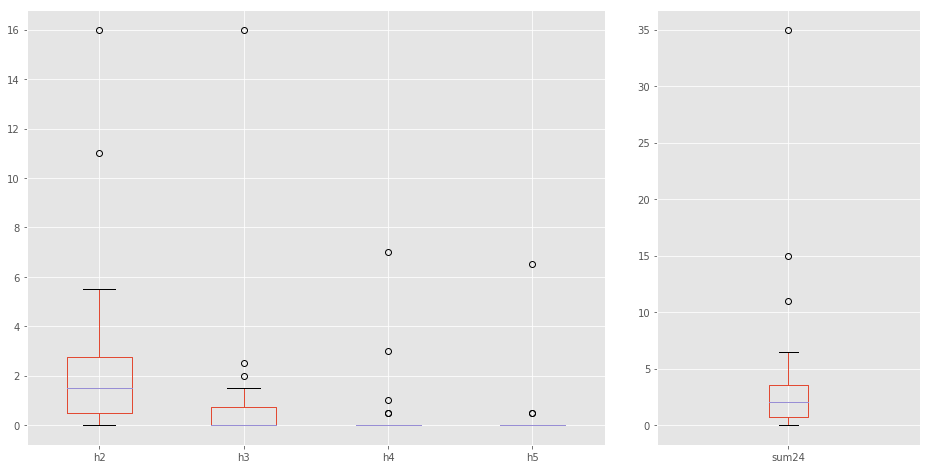

### Results for Off Tackle

  Number of Data Points: 47


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.00
Median,0.5,0.0,0.0,0.0,1.00
75 Percentile,1.5,0.5,0.0,0.0,1.75


##### Box Plots

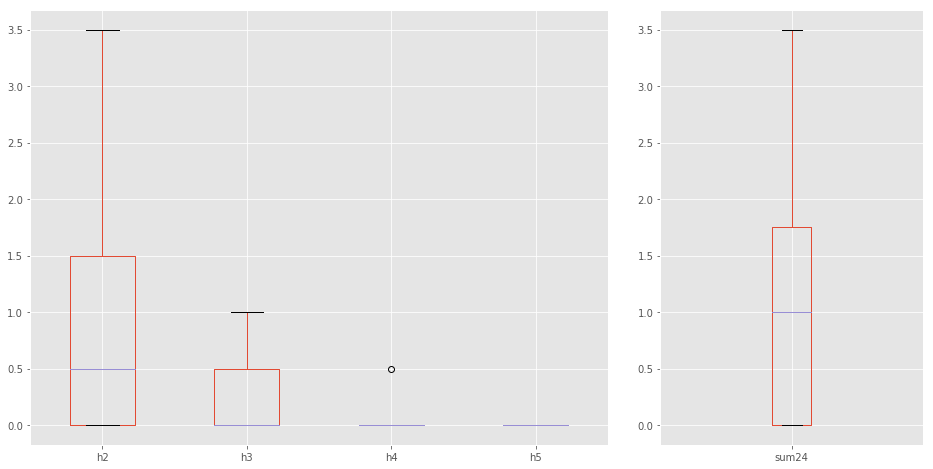

### Results for Running Back

  Number of Data Points: 40


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.5
Median,1.0,0.5,0.0,0.0,1.5
75 Percentile,1.5,1.0,0.0,0.0,2.5


##### Box Plots

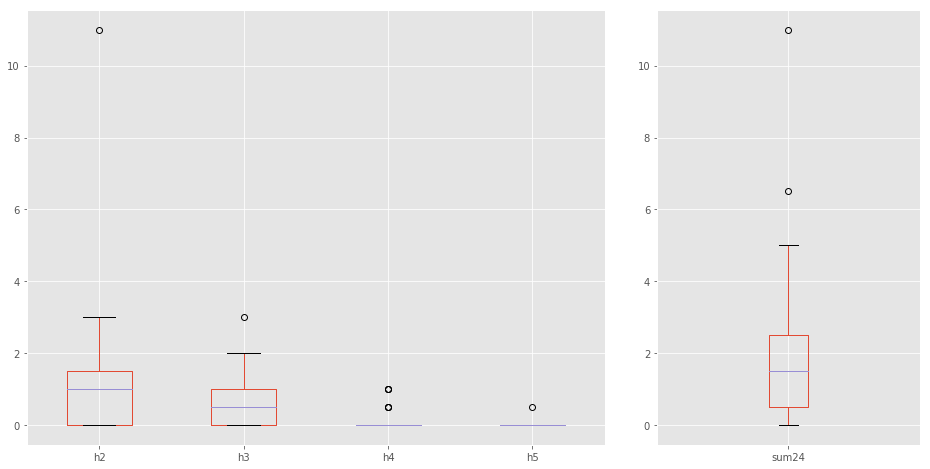

### Results for Safety

  Number of Data Points: 29


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,1.0
75 Percentile,1.0,1.0,0.0,0.0,2.0


##### Box Plots

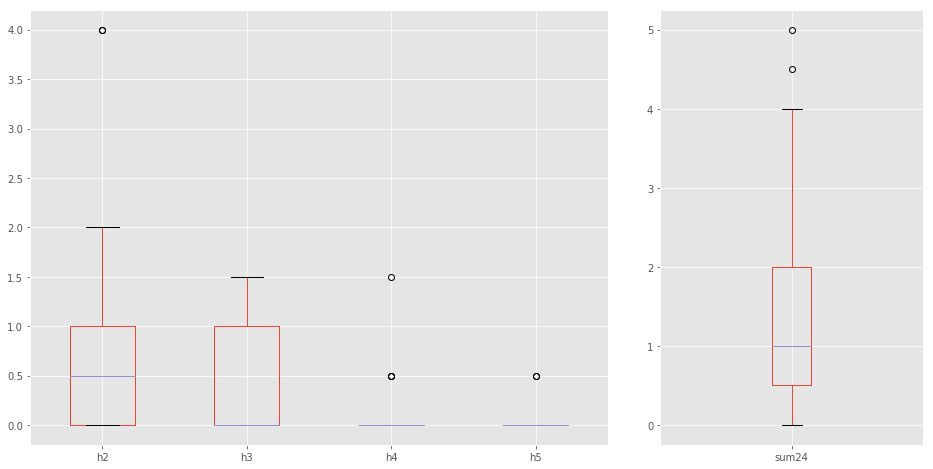

### Results for Tight End

  Number of Data Points: 54


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.125,1.0,0.0,0.0,2.25
Median,2.500,2.0,0.5,0.0,6.25
75 Percentile,4.000,3.0,1.0,0.5,8.00


##### Box Plots

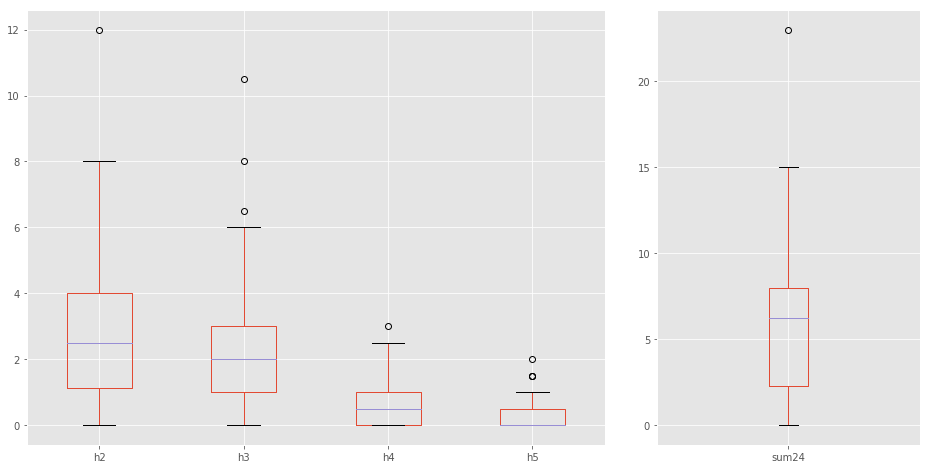

### Results for Wide Receiver

  Number of Data Points: 34


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.5
75 Percentile,1.0,0.5,0.0,0.0,1.5


##### Box Plots

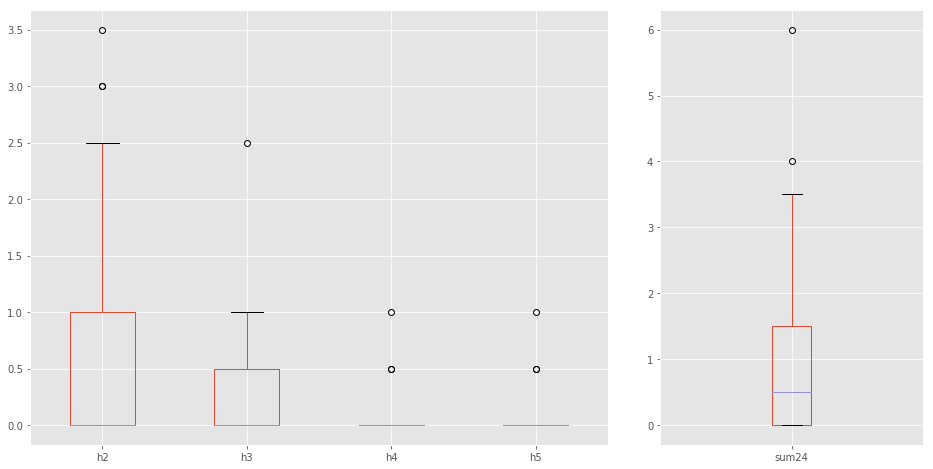

In [205]:
grps = (practices.groupby(['event', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
                 .sum()
                 .groupby('player'))
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 3: What is the exposure to hits based on player position by practice type?

Again, the procedure is similar. First, we'll used the data that is normalized by the number of players in a given position and only include practice data.

Next, we'll group the data by practice type (tuesday, wednedsay, camp, etc) and player position then sum the hit data. As before, a sample of the data is below.

In [206]:
hits_by_type = (practices
                .groupby(['event', 'type', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
                .sum())
hits_by_type.sample(5)

,event,type,player,h2,h3,h4,h5,sum24
38,Houston #2,wed,linebacker,1.5,1.5,0.0,0.0,3.0
86,Memphis #2,wed/thurs,cornerback,0.0,0.0,0.0,0.0,0.0
105,Navy #2,wed,running back,1.0,1.0,0.0,0.0,2.0
100,Navy #2,wed,cornerback,0.0,0.0,0.0,0.0,0.0
393,fall camp practice #5,camp,off guard,2.0,2.0,0.0,0.0,4.0


This time, we'll group the data by player and practice type before taking the median value of all the practices.

In [207]:
hits_by_type.groupby(['player', 'type']).aggregate(np.median)

h2    h3    h4   h5  sum24
player        type                                   
cornerback    camp       0.50  0.00  0.00  0.0   0.50
              scrimmage  0.00  0.00  0.00  0.0   0.00
              thurs      0.50  0.00  0.00  0.0   0.50
              tues       1.00  0.00  0.00  0.0   1.00
              wed        0.50  0.00  0.00  0.0   0.50
              wed/thurs  1.00  0.00  0.00  0.0   2.00
def end       camp       4.50  3.00  0.75  0.0   6.00
              scrimmage  0.00  0.00  0.00  0.0   0.00
              thurs      0.50  0.25  0.00  0.0   1.00
              tues       2.00  0.50  0.00  0.5   3.50
              wed        2.00  1.00  0.50  0.0   3.00
              wed/thurs  2.50  1.00  0.00  0.0   3.50
def tackle    camp       0.50  0.00  0.00  0.0   0.75
              scrimmage  1.50  0.50  0.00  0.0   2.00
              thurs      0.50  0.00  0.00  0.0   0.50
              tues       1.00  0.00  0.00  0.0   1.00
              wed        1.00  0.00  0.00  0.0   1.00
              wed/thurs  2.00  0.00  0.00  0.0   2.00
linebacker    camp       2.50  1.00  0.00  0.0   4.00
              scrimmage  1.00  0.50  0.00  0.0   1.50
              thurs      0.50  0.00  0.00  0.0   0.50
              tues       1.50  0.50  0.00  0.0   2.00
              wed        2.00  1.00  0.00  0.0   3.00
              wed/thurs  1.50  0.00  0.00  0.0   1.50
off guard     camp       2.00  0.50  0.00  0.0   2.50
              scrimmage  0.50  0.00  0.00  0.0   0.50
              thurs      1.50  0.50  0.00  0.0   2.00
              tues       1.00  0.00  0.00  0.0   1.00
              wed        2.25  0.00  0.00  0.0   2.50
              wed/thurs  0.50  0.00  0.00  0.0   0.50
off tackle    camp       1.50  0.00  0.00  0.0   1.50
              scrimmage  0.50  0.00  0.00  0.0   0.50
              thurs      0.25  0.00  0.00  0.0   0.25
              tues       0.00  0.00  0.00  0.0   0.50
              wed        1.50  0.00  0.00  0.0   1.50
              wed/thurs  1.00  0.00  0.00  0.0   1.00
running back  camp       2.00  1.00  0.00  0.0   2.50
              scrimmage  0.50  0.00  0.00  0.0   0.50
              thurs      1.00  0.00  0.00  0.0   1.00
              tues       0.00  0.00  0.00  0.0   1.00
              wed        1.00  1.00  0.00  0.0   2.00
              wed/thurs  0.00  0.00  1.00  0.0   1.00
safety        camp       0.50  0.75  0.00  0.0   1.00
              thurs      0.75  0.00  0.00  0.0   0.75
              tues       0.75  0.25  0.00  0.0   0.75
              wed        0.00  0.00  0.00  0.0   0.00
tight end     camp       3.50  2.00  0.50  0.0   6.50
              scrimmage  0.50  0.00  0.00  0.0   0.50
              thurs      0.50  0.00  0.00  0.0   0.75
              tues       3.00  3.00  1.00  0.5   7.00
              wed        3.50  1.50  1.00  0.5   7.00
              wed/thurs  2.00  2.50  1.00  0.5   7.00
wide receiver camp       0.00  0.00  0.00  0.0   0.00
              scrimmage  0.00  0.50  0.00  0.0   0.50
              thurs      0.50  0.00  0.00  0.0   0.50
              tues       1.00  0.50  0.00  0.0   1.25
              wed        0.75  0.00  0.00  0.0   1.00
              wed/thurs  0.50  0.00  0.00  0.5   0.50

Note that the safety position does not have data for the wed/thurs practice type. This occurs because by this time no safeties (with instrumented helmets) were practicing.

### Results for Cornerback, Practice Type: Camp

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.00,0.0,0.0,0.50
Median,0.5,0.00,0.0,0.0,0.50
75 Percentile,0.5,0.25,0.0,0.0,0.75


##### Box Plots

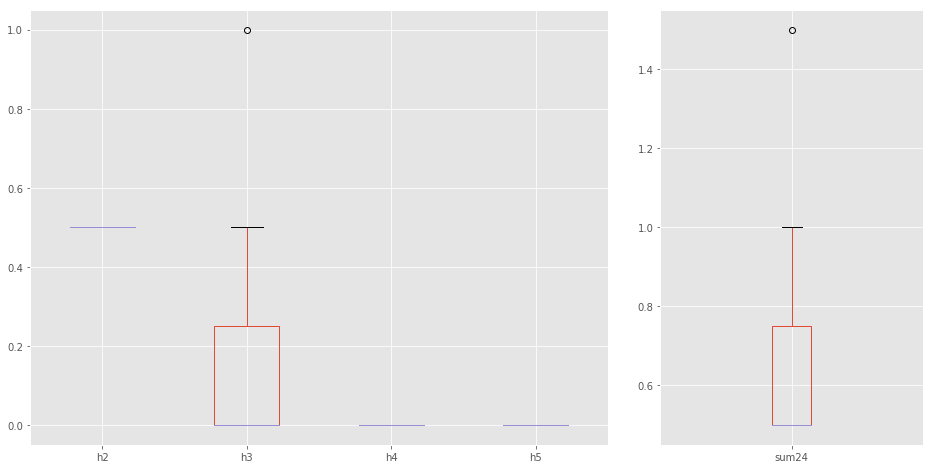

### Results for Cornerback, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

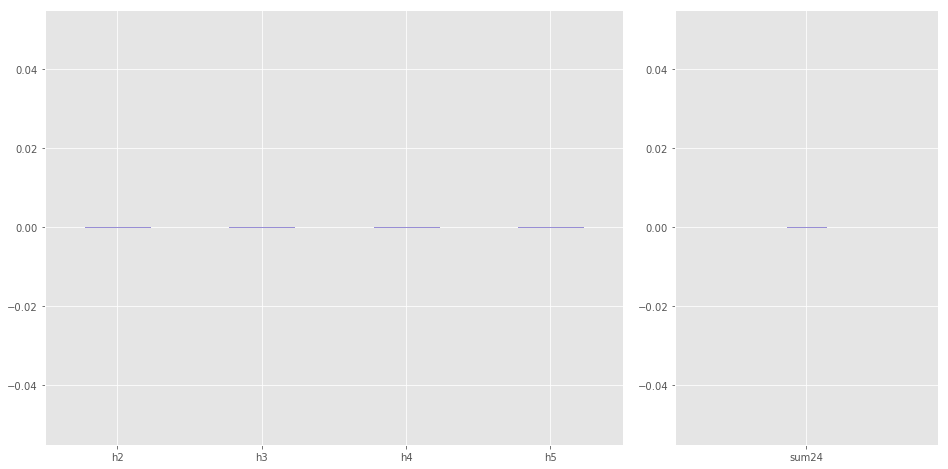

### Results for Cornerback, Practice Type: Thurs

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.125,0.0,0.0,0.0,0.500
Median,0.500,0.0,0.0,0.0,0.500
75 Percentile,1.375,0.5,0.0,0.0,2.125


##### Box Plots

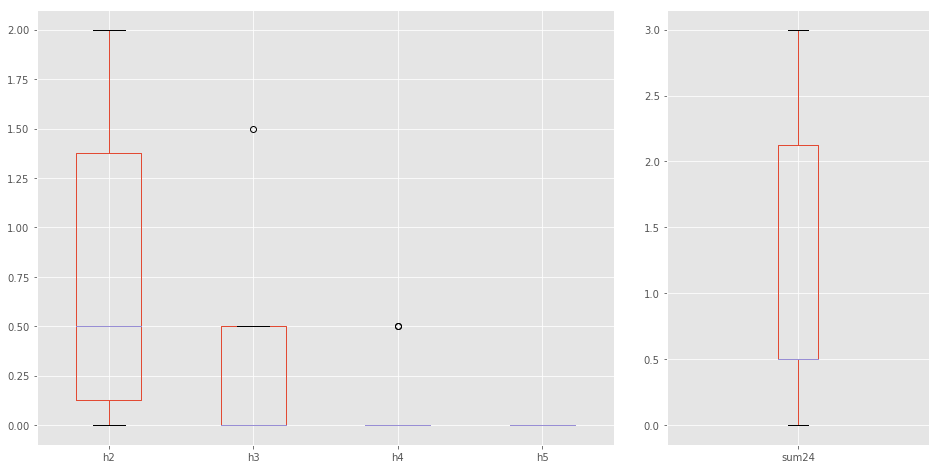

### Results for Cornerback, Practice Type: Tues

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.000,0.0,0.0,0.5
Median,1.0,0.000,0.0,0.0,1.0
75 Percentile,1.5,0.125,0.0,0.0,1.5


##### Box Plots

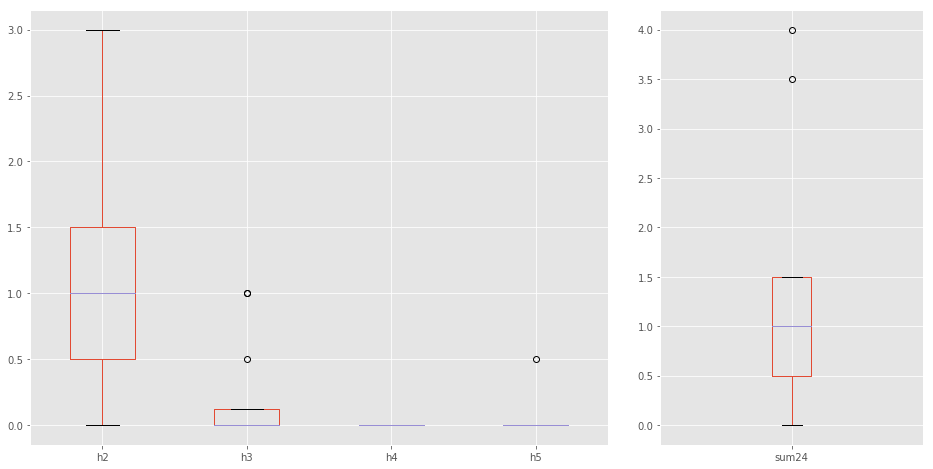

### Results for Cornerback, Practice Type: Wed

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.000
Median,0.5,0.0,0.0,0.0,0.500
75 Percentile,1.0,0.0,0.0,0.0,1.375


##### Box Plots

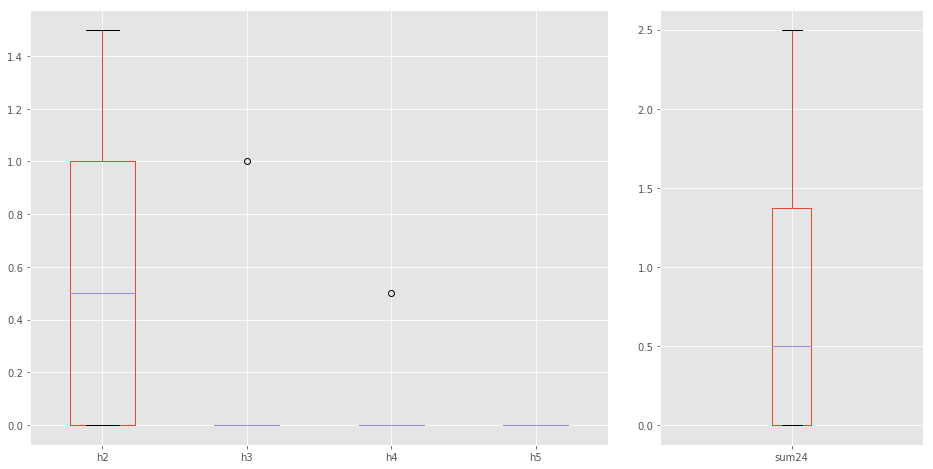

### Results for Cornerback, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,1.0
Median,1.0,0.0,0.0,0.0,2.0
75 Percentile,2.0,0.0,0.5,0.0,2.5


##### Box Plots

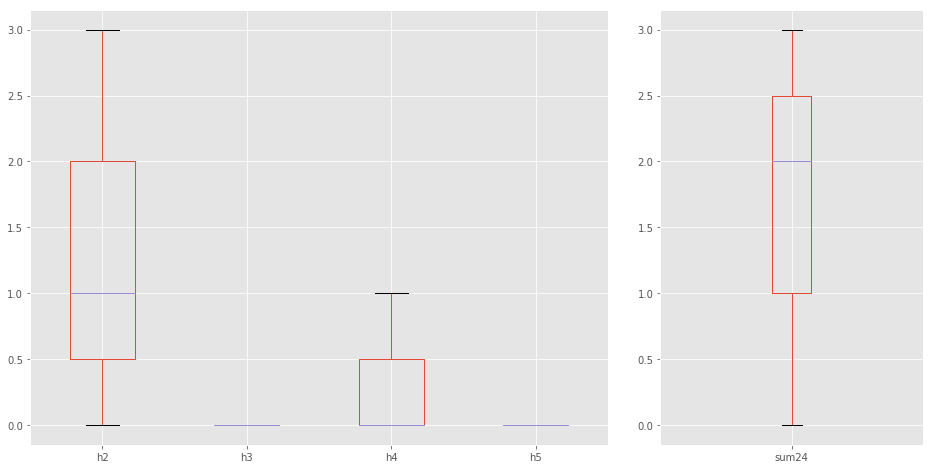

### Results for Def End, Practice Type: Camp

  Number of Data Points: 14


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.25,1.00,0.00,0.00,4.125
Median,4.50,3.00,0.75,0.00,6.000
75 Percentile,5.75,3.75,1.00,0.75,11.000


##### Box Plots

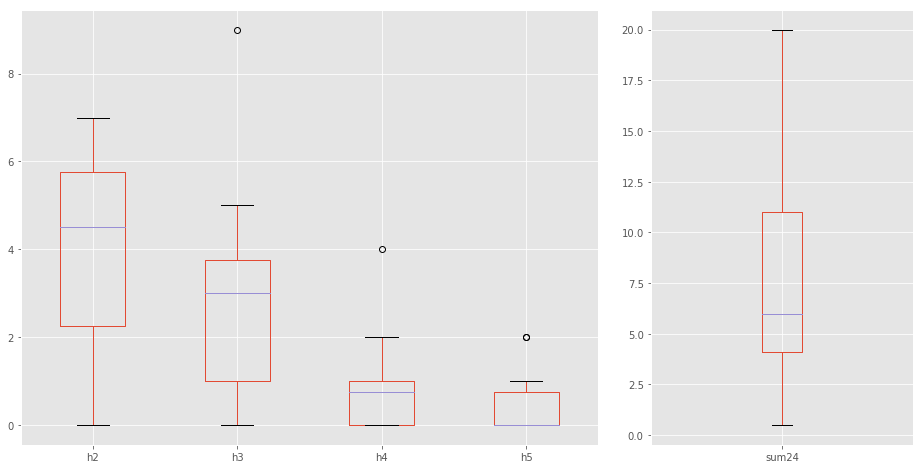

### Results for Def End, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

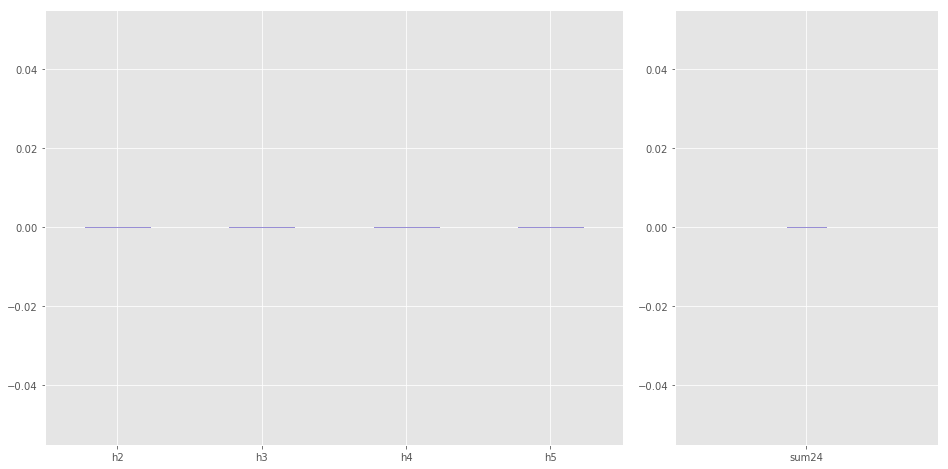

### Results for Def End, Practice Type: Thurs

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.125,0.000,0.0,0.0,0.125
Median,0.500,0.250,0.0,0.0,1.000
75 Percentile,1.375,0.875,0.0,0.0,2.250


##### Box Plots

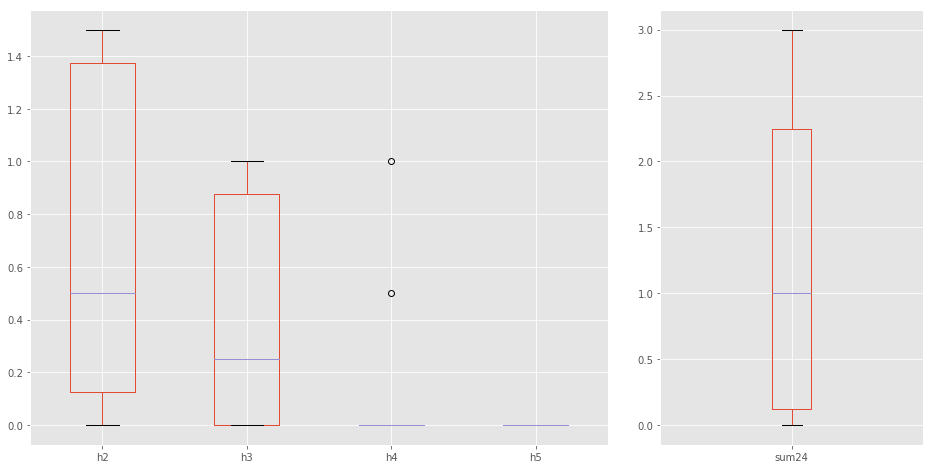

### Results for Def End, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.75,0.25,0.0,0.0,2.0
Median,2.00,0.50,0.0,0.5,3.5
75 Percentile,4.00,3.00,0.5,0.5,6.0


##### Box Plots

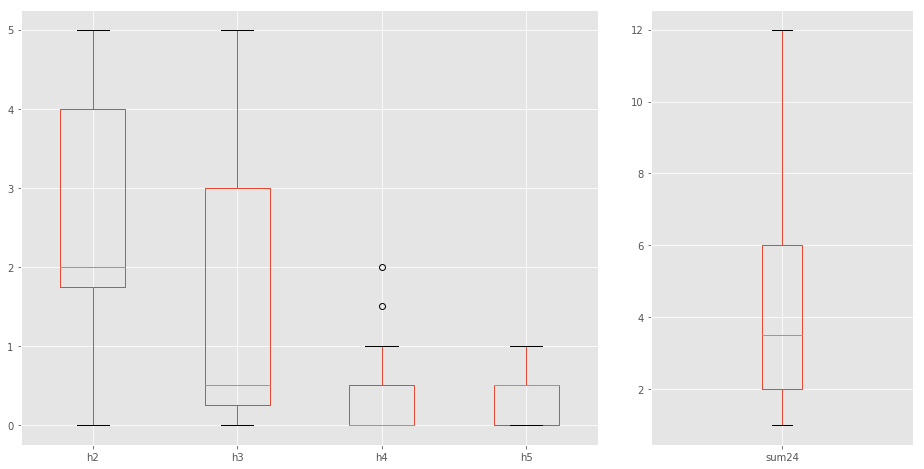

### Results for Def End, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,0.5,0.0,0.0,2.5
Median,2.0,1.0,0.5,0.0,3.0
75 Percentile,5.5,2.5,1.0,0.5,9.0


##### Box Plots

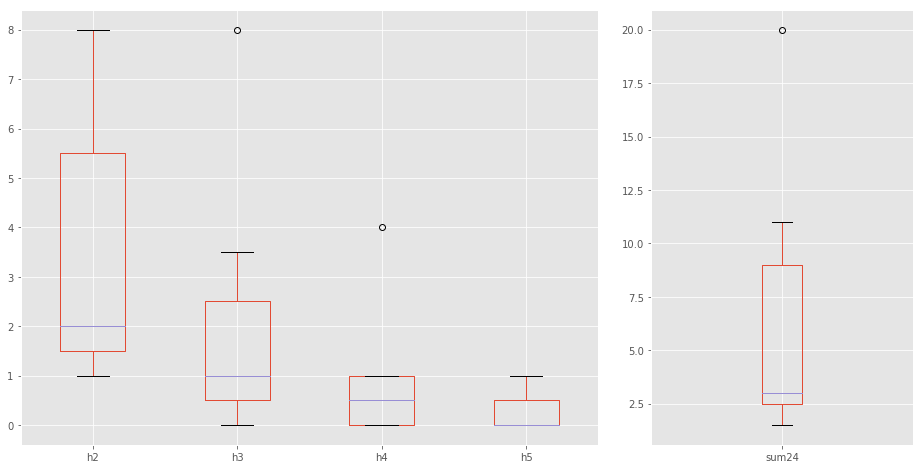

### Results for Def End, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.50,0.75,0.0,0.00,2.5
Median,2.50,1.00,0.0,0.00,3.5
75 Percentile,2.75,1.50,0.5,0.25,4.5


##### Box Plots

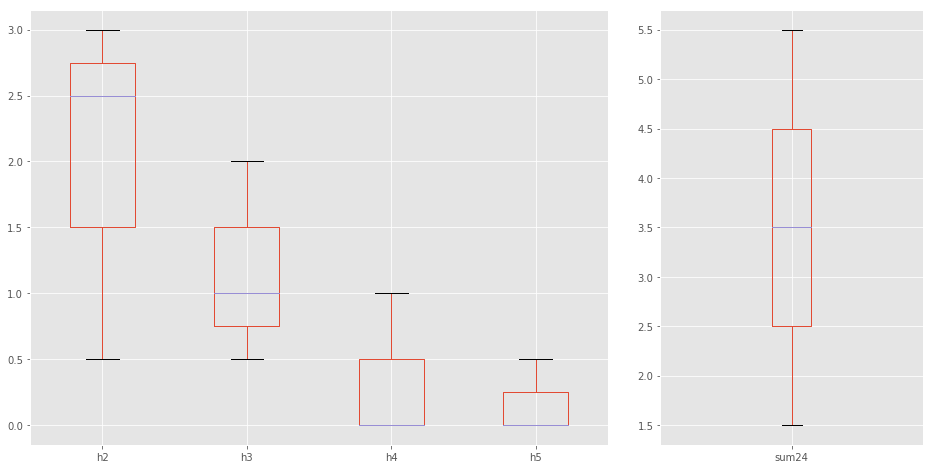

### Results for Def Tackle, Practice Type: Camp

  Number of Data Points: 14


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000,0.000,0.0,0.0,0.00
Median,0.500,0.000,0.0,0.0,0.75
75 Percentile,1.375,0.375,0.0,0.0,1.50


##### Box Plots

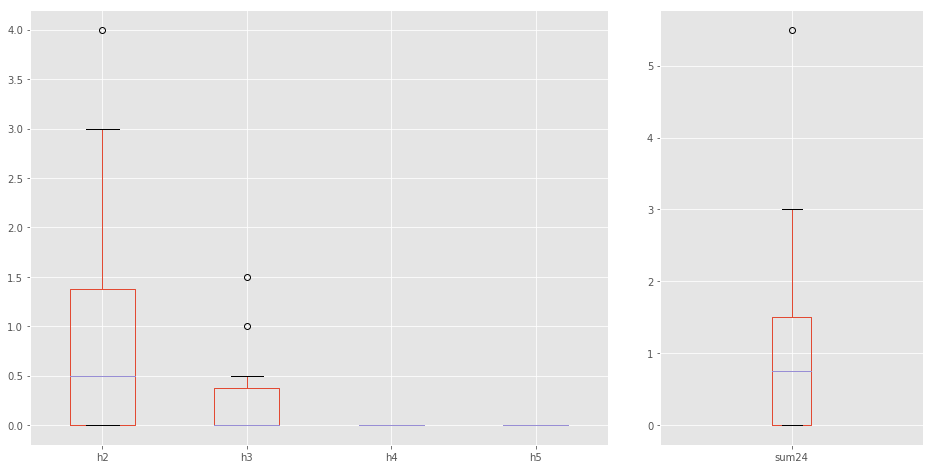

### Results for Def Tackle, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,0.5,0.0,0.0,2.0
Median,1.5,0.5,0.0,0.0,2.0
75 Percentile,1.5,0.5,0.0,0.0,2.0


##### Box Plots

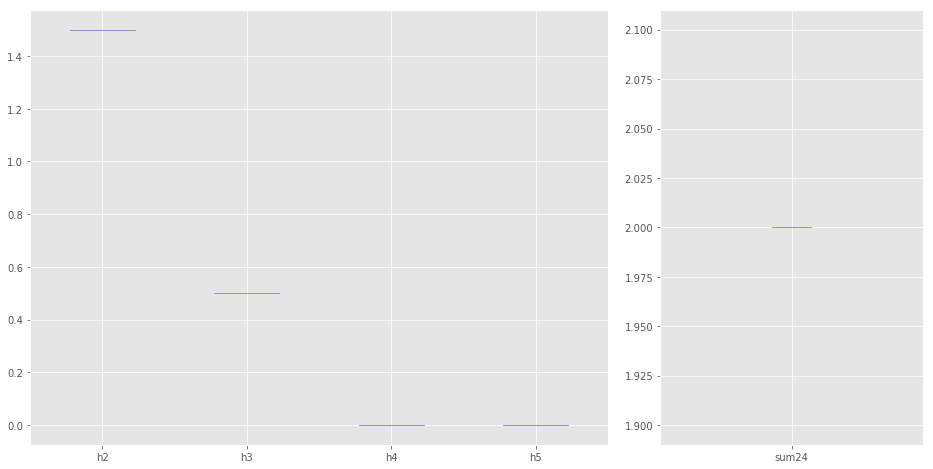

### Results for Def Tackle, Practice Type: Thurs

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,0.5,1.0,0.0,0.0,1.5


##### Box Plots

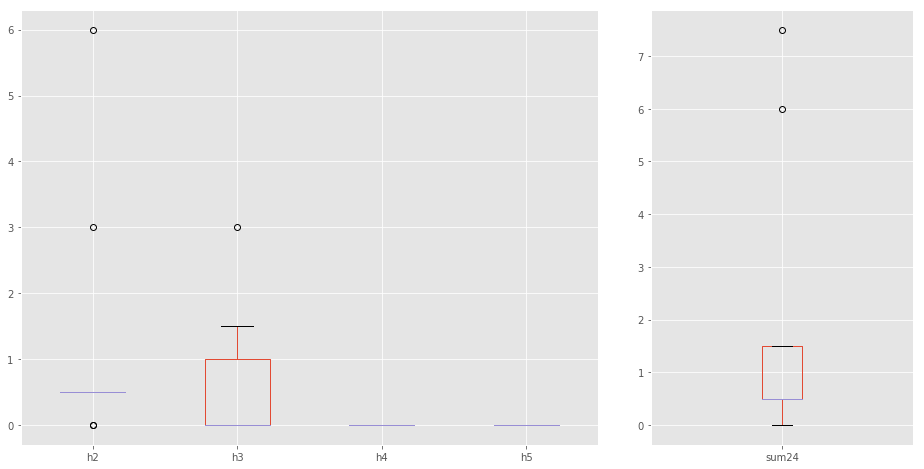

### Results for Def Tackle, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.00,0.0,0.0,0.0
Median,1.00,0.00,0.0,0.0,1.0
75 Percentile,1.75,0.25,0.0,0.0,2.0


##### Box Plots

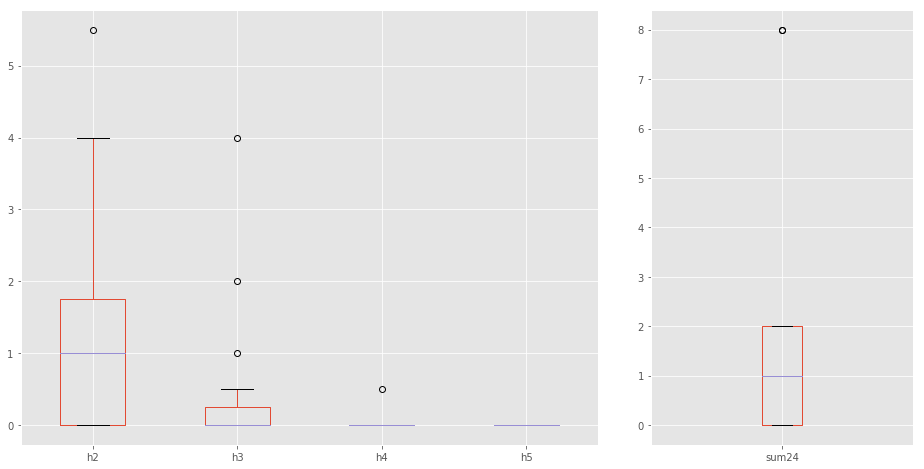

### Results for Def Tackle, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,1.0
Median,1.0,0.0,0.0,0.0,1.0
75 Percentile,1.5,0.5,0.0,0.0,1.5


##### Box Plots

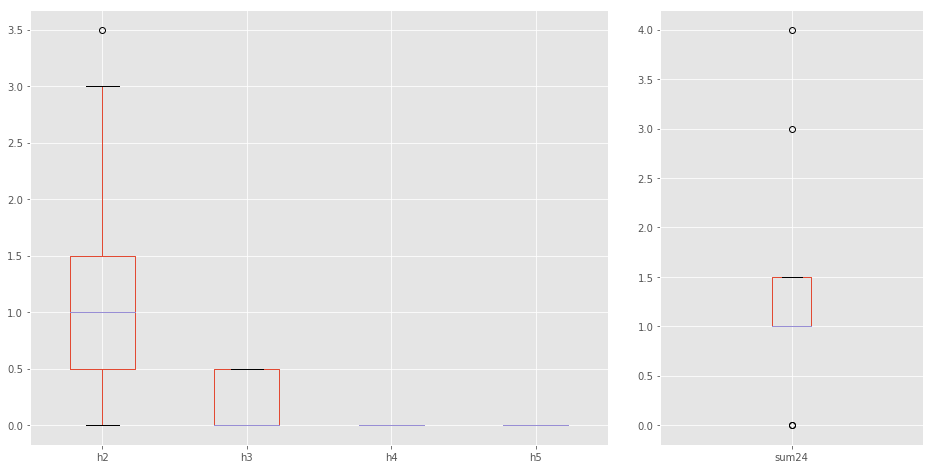

### Results for Def Tackle, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.0,0.0,0.0,0.0,2.0
Median,2.0,0.0,0.0,0.0,2.0
75 Percentile,3.5,1.0,0.0,0.0,4.5


##### Box Plots

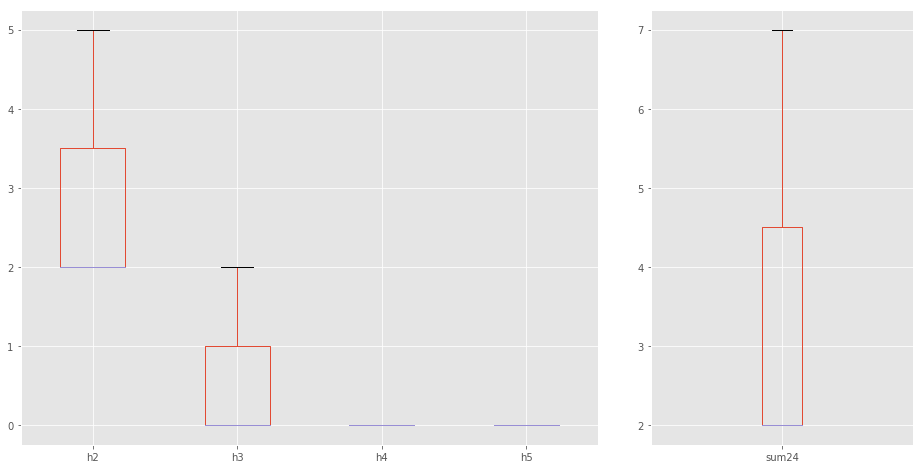

### Results for Linebacker, Practice Type: Camp

  Number of Data Points: 16


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,0.500,0.0,0.0,2.500
Median,2.5,1.000,0.0,0.0,4.000
75 Percentile,5.0,2.125,0.5,0.0,6.625


##### Box Plots

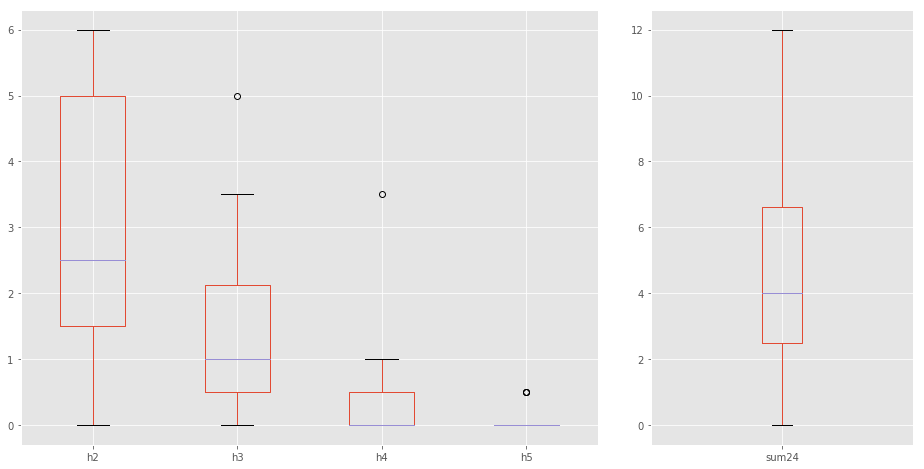

### Results for Linebacker, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.0,0.5,0.0,0.0,1.5
Median,1.0,0.5,0.0,0.0,1.5
75 Percentile,1.0,0.5,0.0,0.0,1.5


##### Box Plots

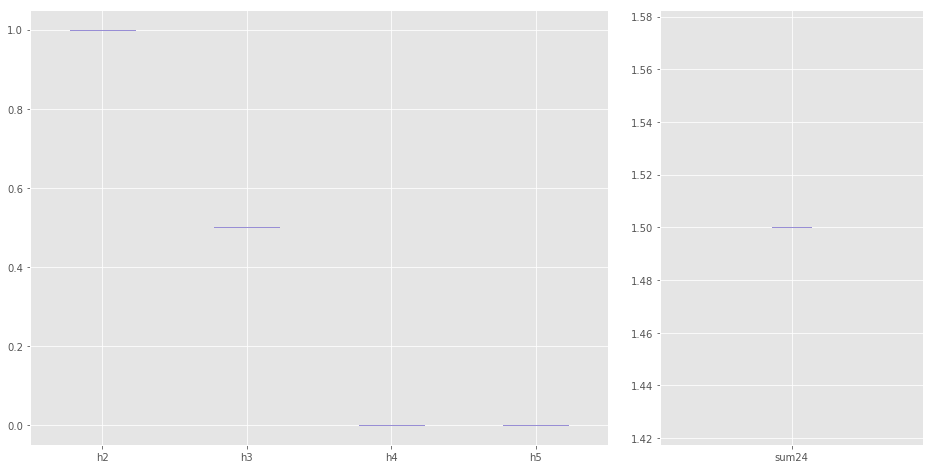

### Results for Linebacker, Practice Type: Thurs

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,1.0,0.0,0.0,0.0,1.0


##### Box Plots

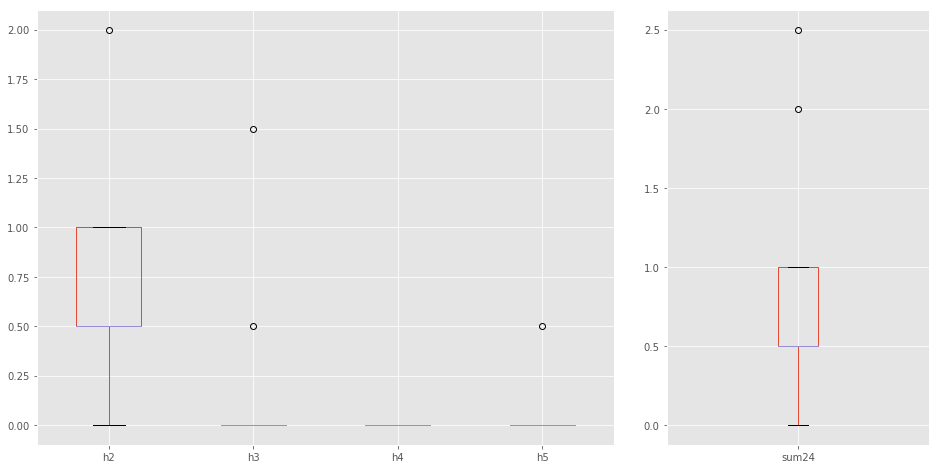

### Results for Linebacker, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,1.00
Median,1.5,0.5,0.0,0.0,2.00
75 Percentile,2.5,1.0,0.0,0.0,3.25


##### Box Plots

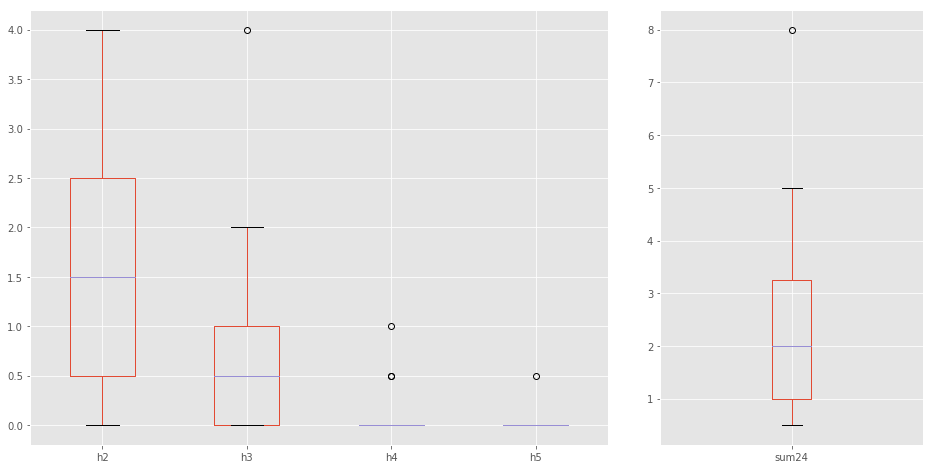

### Results for Linebacker, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,0.5,0.0,0.0,2.0
Median,2.0,1.0,0.0,0.0,3.0
75 Percentile,3.0,1.0,0.0,0.0,4.0


##### Box Plots

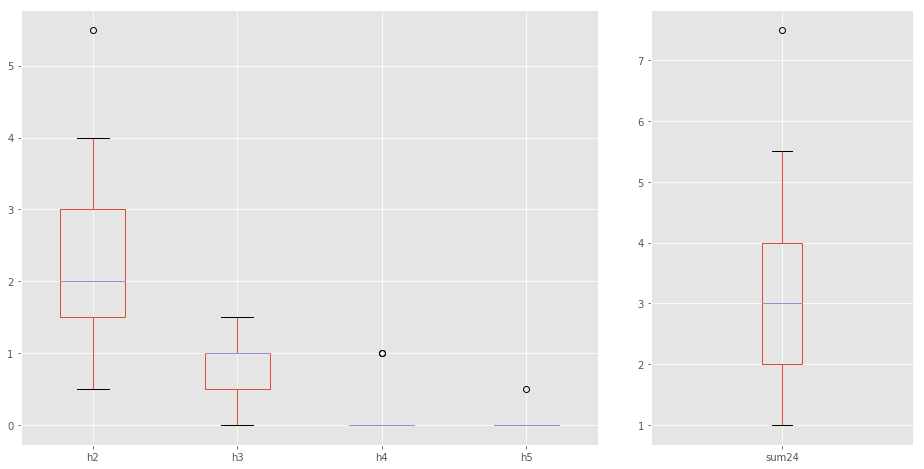

### Results for Linebacker, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.25,0.00,0.0,0.0,1.5
Median,1.50,0.00,0.0,0.0,1.5
75 Percentile,2.00,0.25,0.0,0.0,2.0


##### Box Plots

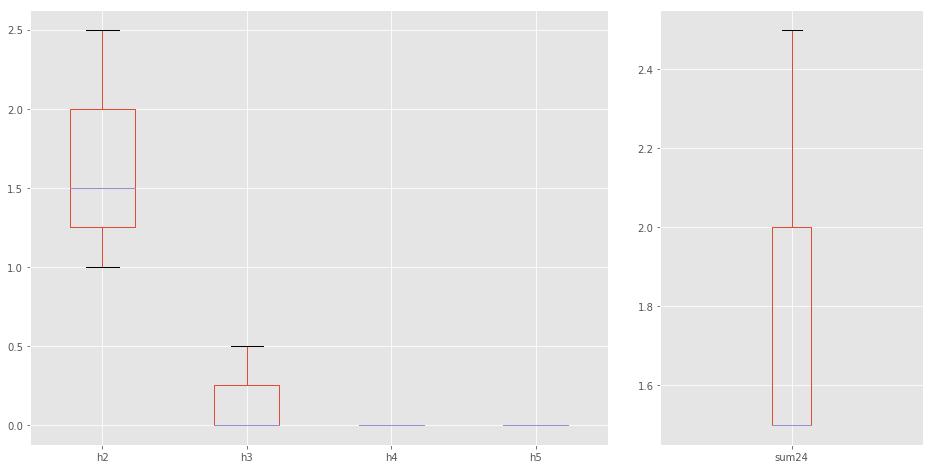

### Results for Off Guard, Practice Type: Camp

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,0.25,0.0,0.0,2.0
Median,2.0,0.50,0.0,0.0,2.5
75 Percentile,2.5,1.00,0.0,0.0,3.5


##### Box Plots

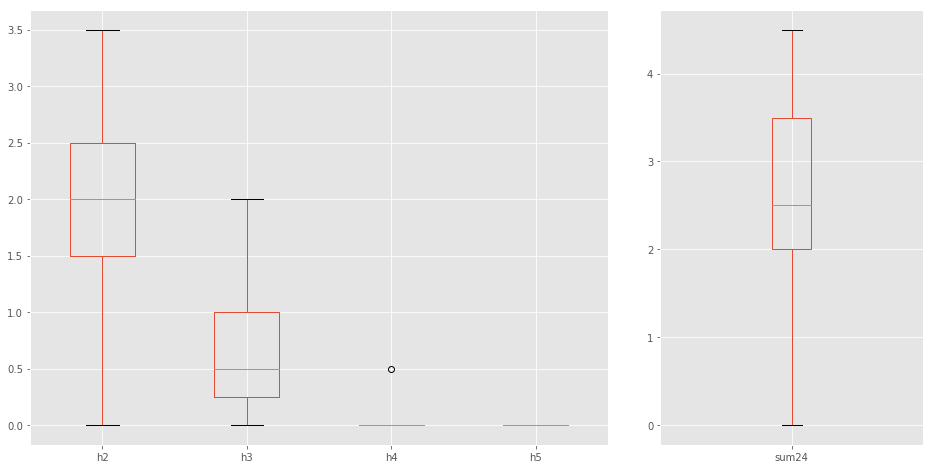

### Results for Off Guard, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,0.5,0.0,0.0,0.0,0.5


##### Box Plots

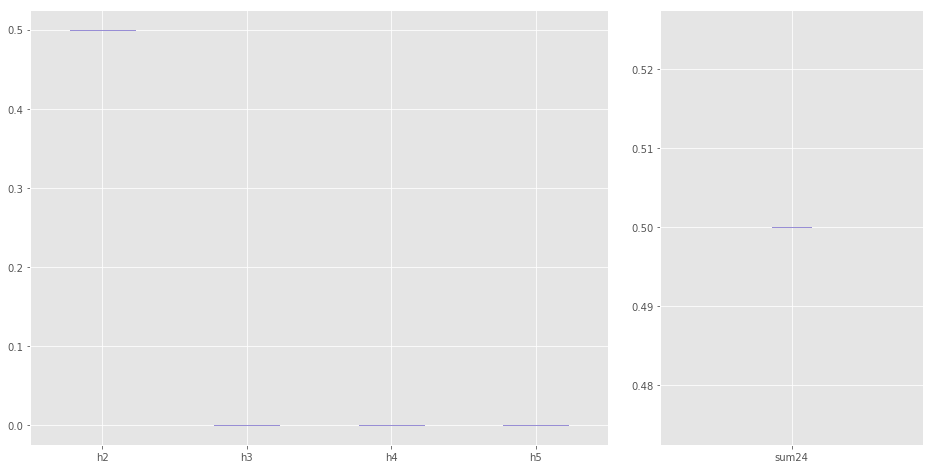

### Results for Off Guard, Practice Type: Thurs

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.00,0.25,0.0,0.00,1.5
Median,1.50,0.50,0.0,0.00,2.0
75 Percentile,4.25,1.50,1.5,0.25,9.0


##### Box Plots

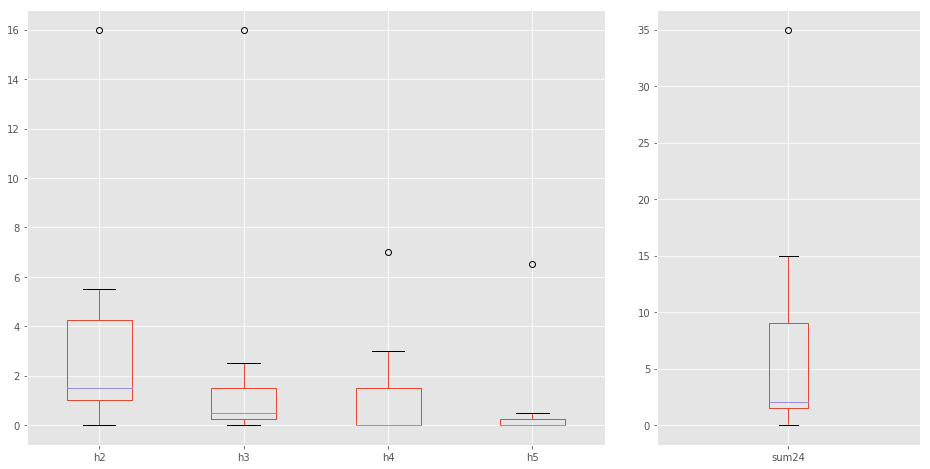

### Results for Off Guard, Practice Type: Tues

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.00,0.0,0.0,0.00
Median,1.0,0.00,0.0,0.0,1.00
75 Percentile,1.5,0.75,0.0,0.0,1.75


##### Box Plots

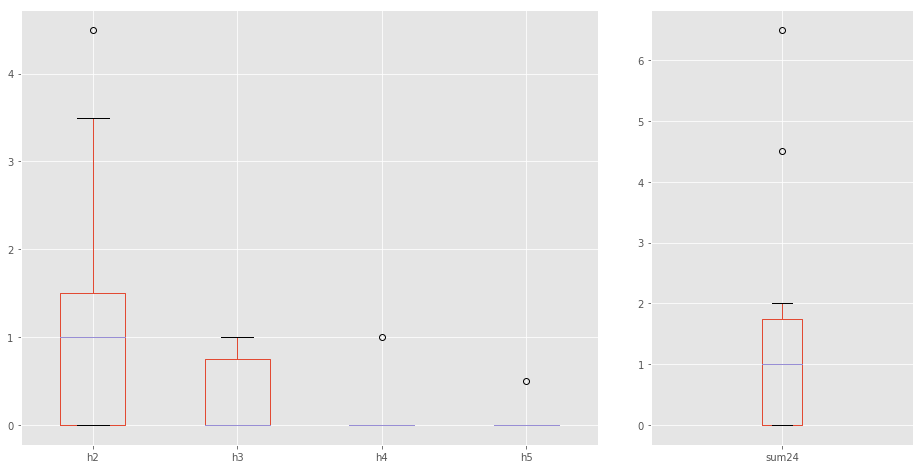

### Results for Off Guard, Practice Type: Wed

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.375,0.0,0.0,0.0,0.375
Median,2.250,0.0,0.0,0.0,2.500
75 Percentile,3.375,0.0,0.0,0.0,4.250


##### Box Plots

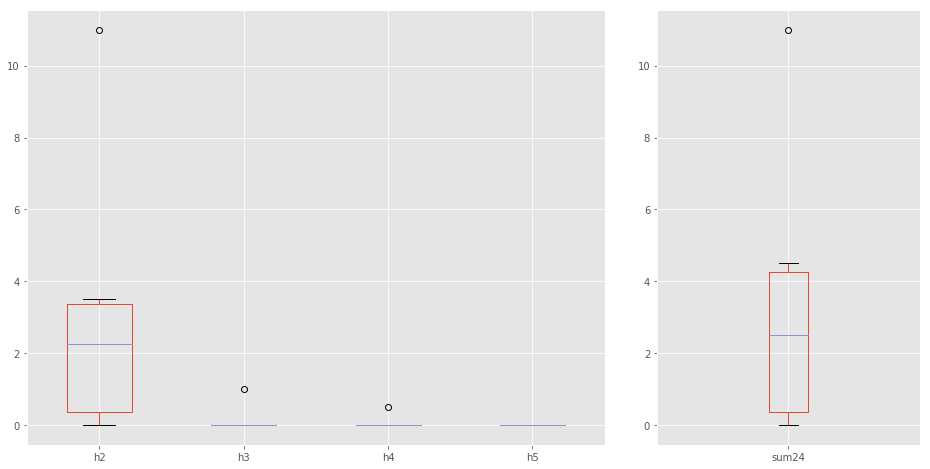

### Results for Off Guard, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.25,0.0,0.0,0.0,0.25
Median,0.50,0.0,0.0,0.0,0.50
75 Percentile,0.75,0.0,0.0,0.0,0.75


##### Box Plots

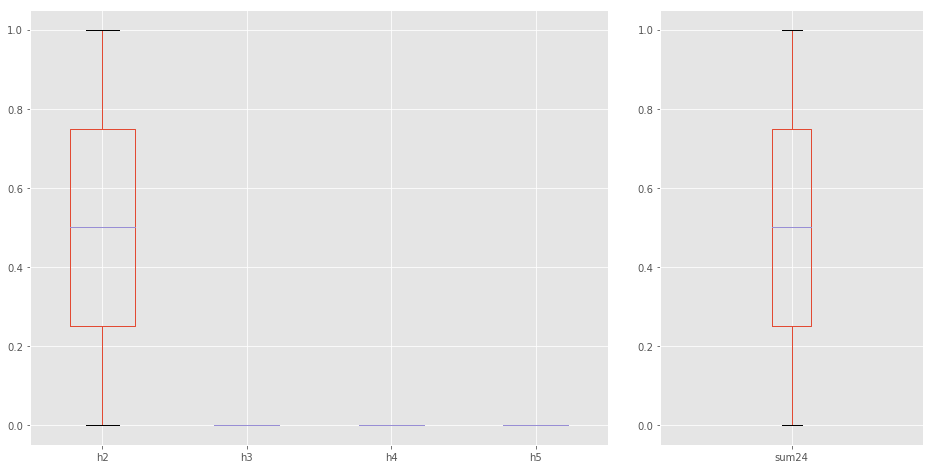

### Results for Off Tackle, Practice Type: Camp

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.50,0.00,0.0,0.0,0.50
Median,1.50,0.00,0.0,0.0,1.50
75 Percentile,1.75,0.25,0.0,0.0,2.25


##### Box Plots

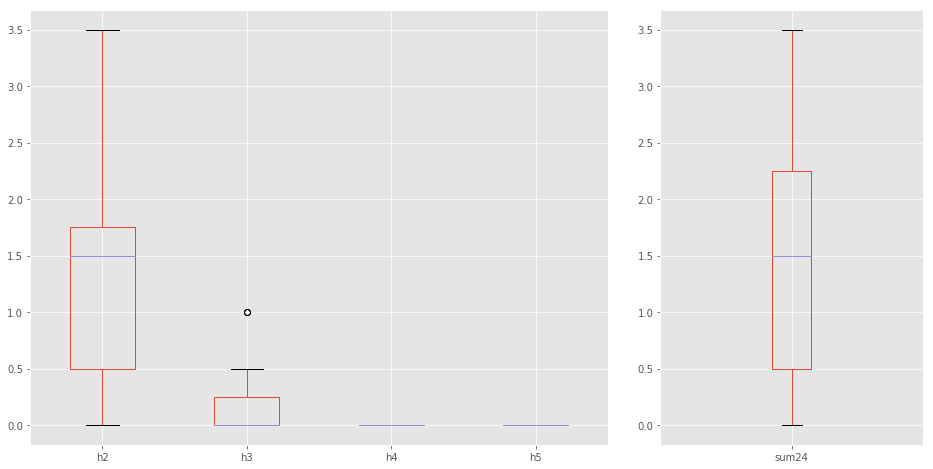

### Results for Off Tackle, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,0.5,0.0,0.0,0.0,0.5


##### Box Plots

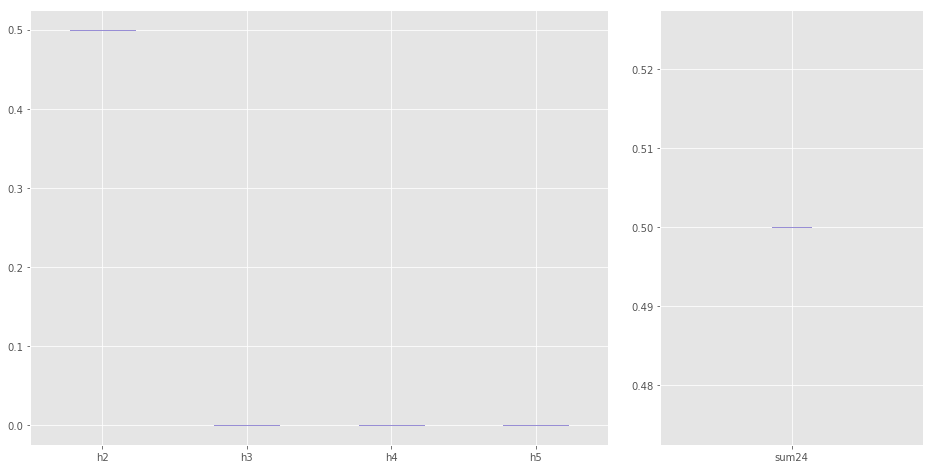

### Results for Off Tackle, Practice Type: Thurs

  Number of Data Points: 8


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.0,0.0,0.0,0.00
Median,0.25,0.0,0.0,0.0,0.25
75 Percentile,0.50,0.0,0.0,0.0,0.50


##### Box Plots

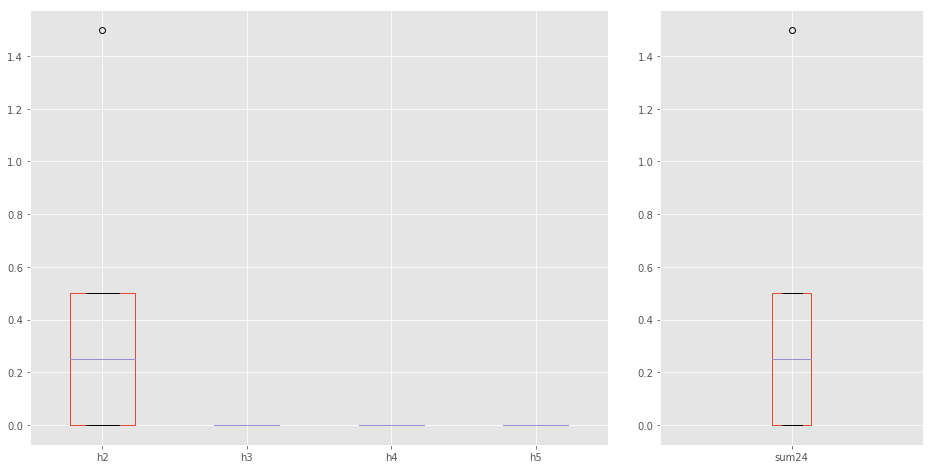

### Results for Off Tackle, Practice Type: Tues

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.5
75 Percentile,0.5,0.5,0.0,0.0,0.5


##### Box Plots

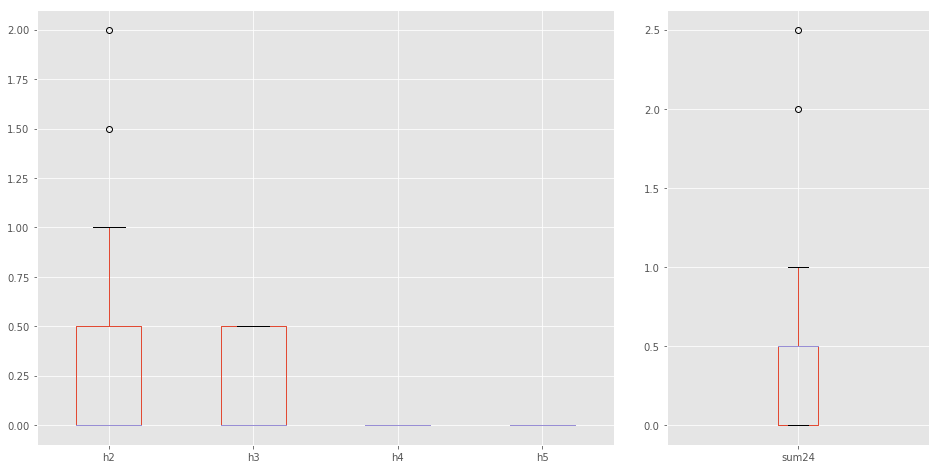

### Results for Off Tackle, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.0,0.0,0.0,0.0,1.0
Median,1.5,0.0,0.0,0.0,1.5
75 Percentile,2.0,0.5,0.0,0.0,2.5


##### Box Plots

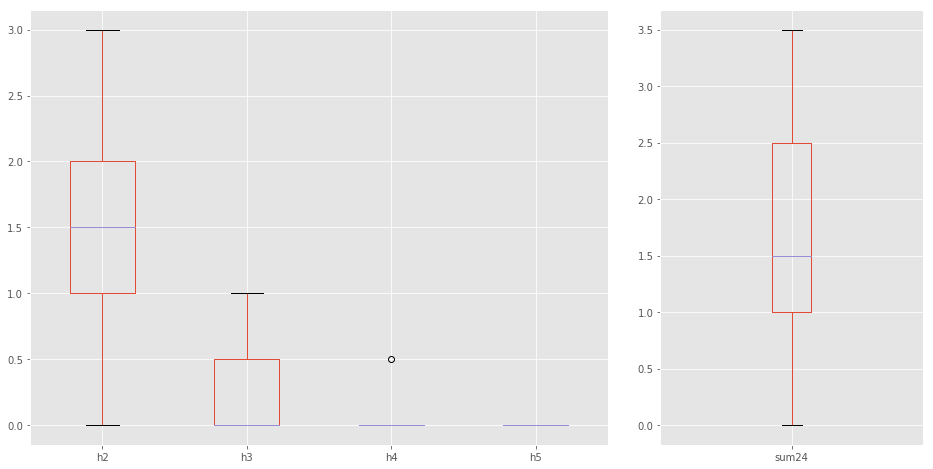

### Results for Off Tackle, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.0,0.0,0.0,0.0,1.0
Median,1.0,0.0,0.0,0.0,1.0
75 Percentile,1.0,0.0,0.0,0.0,1.0


##### Box Plots

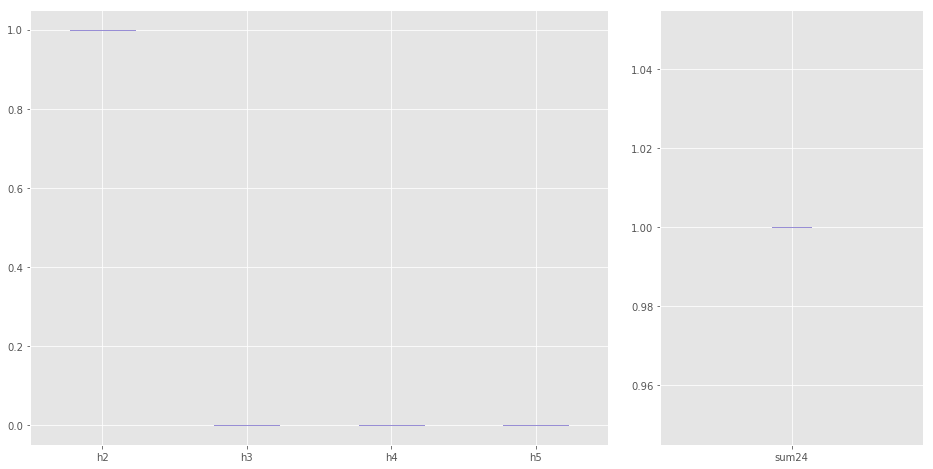

### Results for Running Back, Practice Type: Camp

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.5,0.0,0.0,1.5
Median,2.0,1.0,0.0,0.0,2.5
75 Percentile,2.5,1.5,0.0,0.0,3.5


##### Box Plots

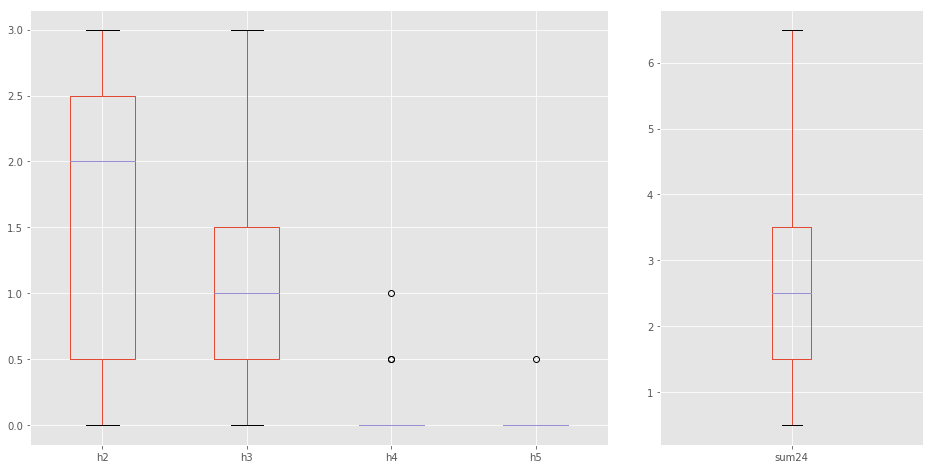

### Results for Running Back, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,0.5,0.0,0.0,0.0,0.5


##### Box Plots

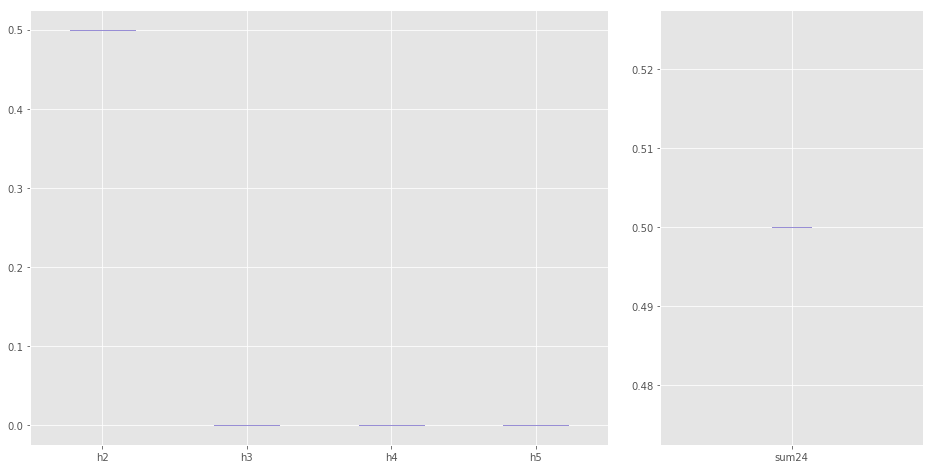

### Results for Running Back, Practice Type: Thurs

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,1.0,0.0,0.0,0.0,1.0
75 Percentile,1.0,0.0,0.0,0.0,1.0


##### Box Plots

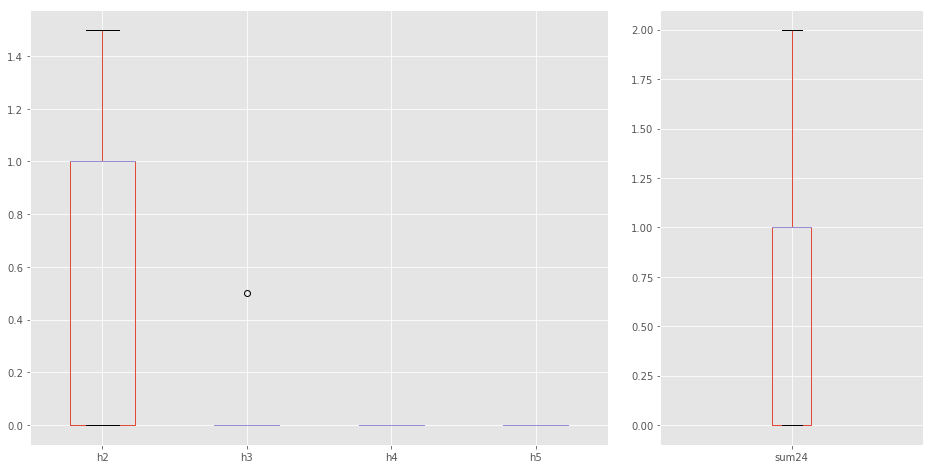

### Results for Running Back, Practice Type: Tues

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.00,0.0,0.0,0.0
Median,0.0,0.00,0.0,0.0,1.0
75 Percentile,1.0,0.75,0.0,0.0,2.0


##### Box Plots

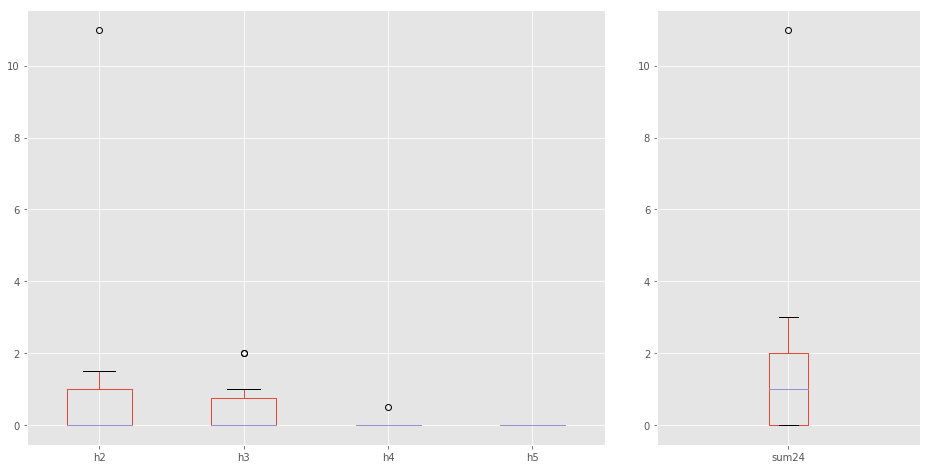

### Results for Running Back, Practice Type: Wed

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.75,0.5,0.0,0.0,1.50
Median,1.00,1.0,0.0,0.0,2.00
75 Percentile,1.00,1.0,0.0,0.0,2.25


##### Box Plots

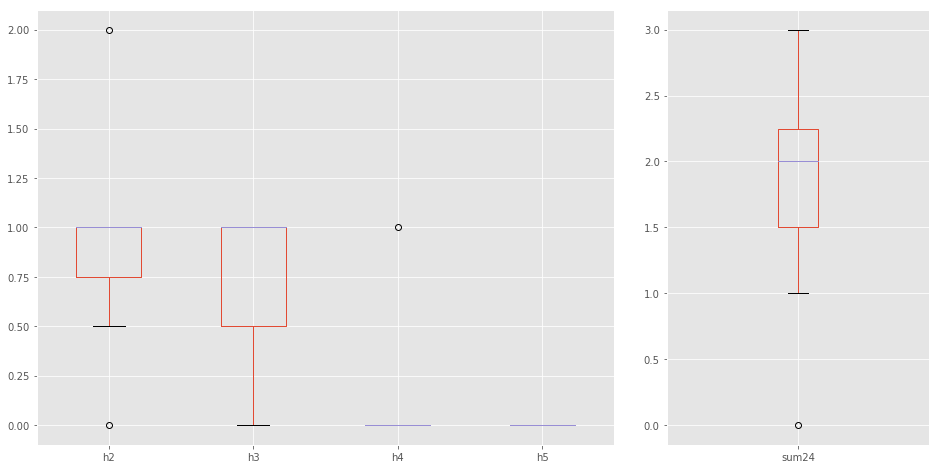

### Results for Running Back, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,1.0,0.0,1.0
Median,0.0,0.0,1.0,0.0,1.0
75 Percentile,0.0,0.0,1.0,0.0,1.0


##### Box Plots

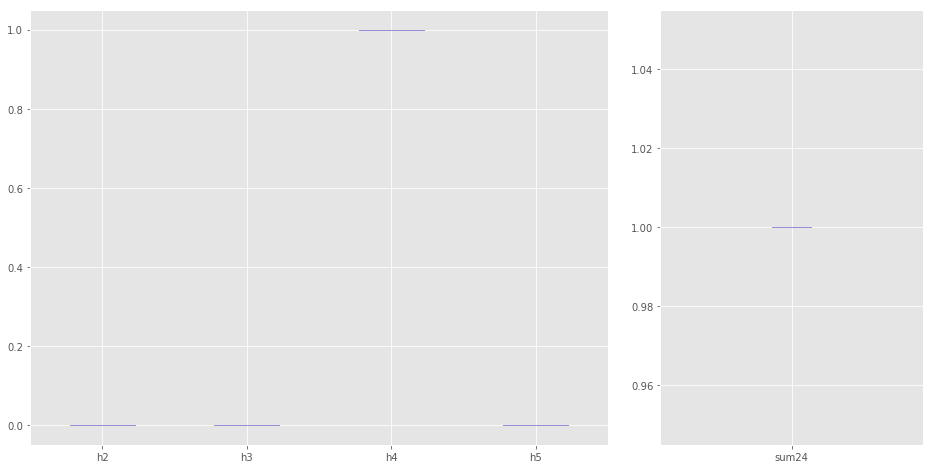

### Results for Safety, Practice Type: Camp

  Number of Data Points: 14


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000,0.125,0.0,0.0,1.000
Median,0.500,0.750,0.0,0.0,1.000
75 Percentile,0.875,1.000,0.0,0.0,1.875


##### Box Plots

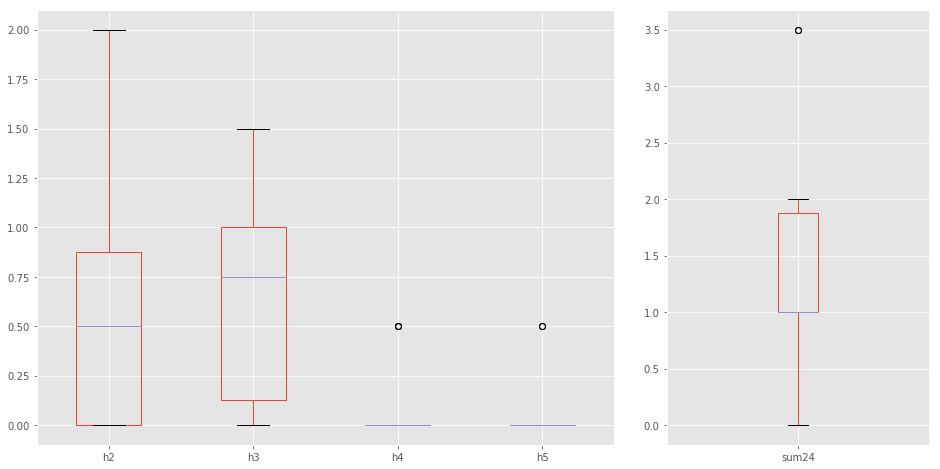

### Results for Safety, Practice Type: Thurs

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.125,0.0,0.0,0.0,0.125
Median,0.750,0.0,0.0,0.0,0.750
75 Percentile,3.250,0.0,0.0,0.0,3.250


##### Box Plots

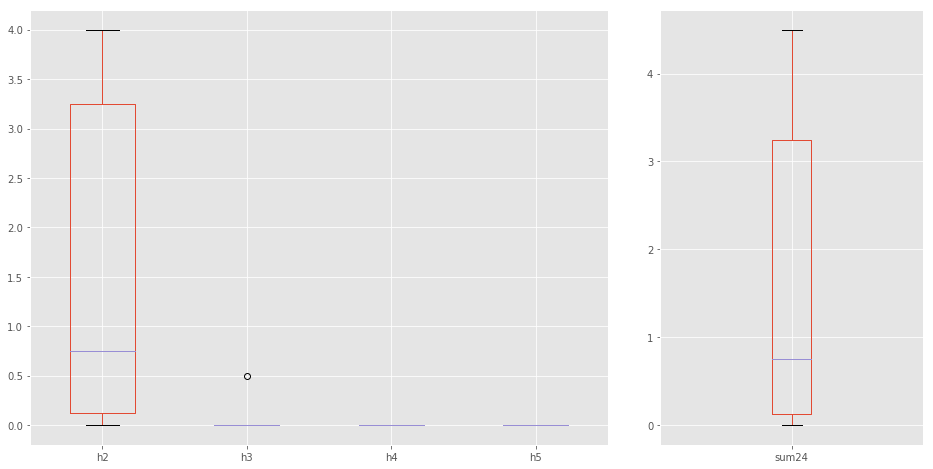

### Results for Safety, Practice Type: Tues

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.375,0.00,0.000,0.0,0.50
Median,0.750,0.25,0.000,0.0,0.75
75 Percentile,1.250,0.75,0.375,0.0,2.00


##### Box Plots

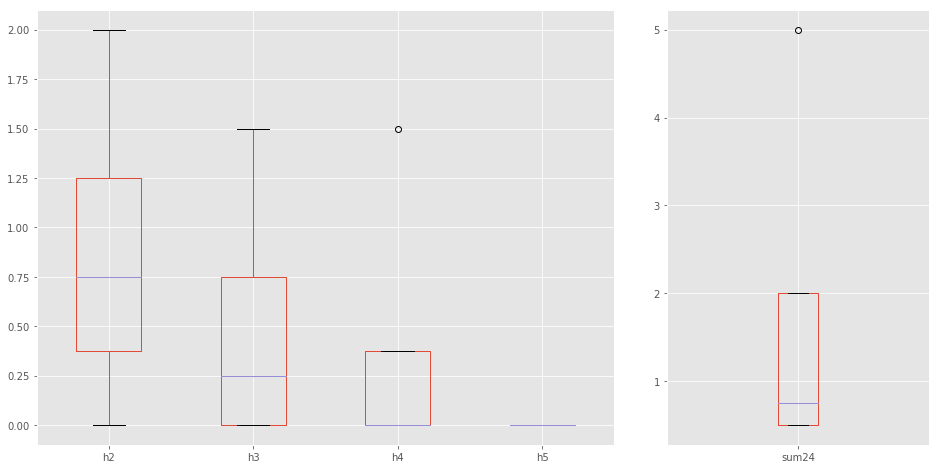

### Results for Safety, Practice Type: Wed

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,1.0,0.0,0.0,0.0,1.5


##### Box Plots

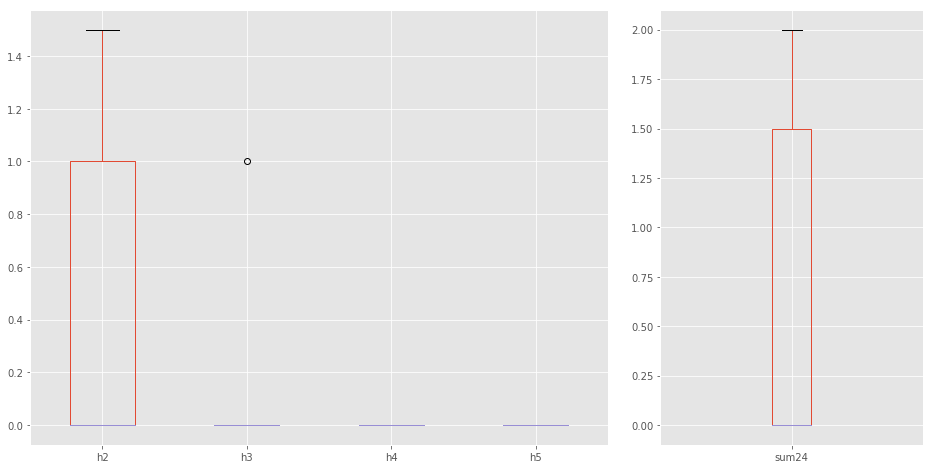

### Results for Tight End, Practice Type: Camp

  Number of Data Points: 16


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.0,1.375,0.5,0.0,5.375
Median,3.5,2.000,0.5,0.0,6.500
75 Percentile,4.5,3.125,1.0,0.5,8.125


##### Box Plots

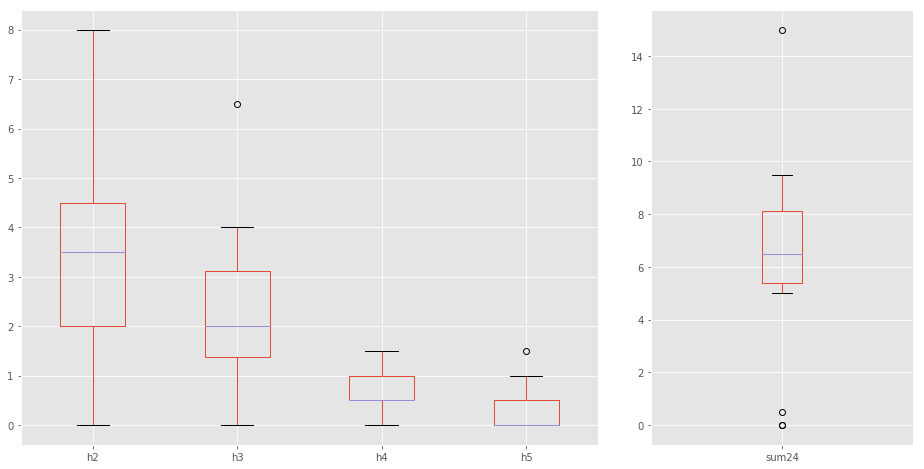

### Results for Tight End, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.0,0.5
Median,0.5,0.0,0.0,0.0,0.5
75 Percentile,0.5,0.0,0.0,0.0,0.5


##### Box Plots

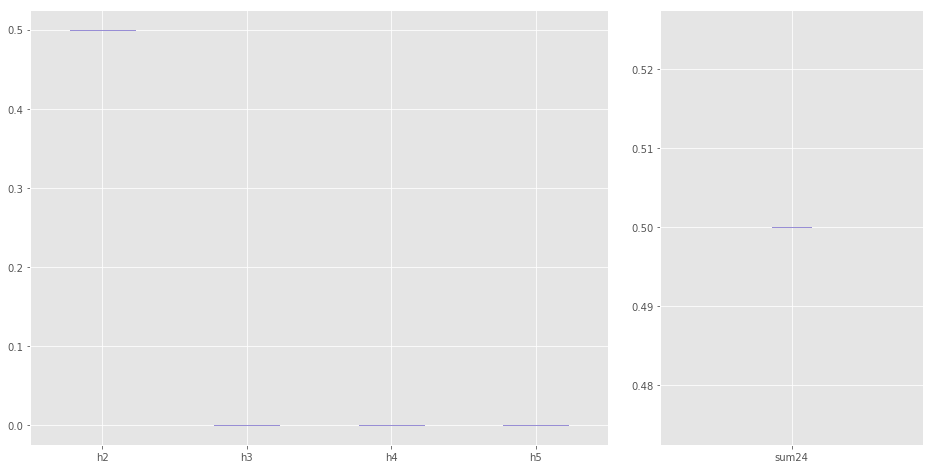

### Results for Tight End, Practice Type: Thurs

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.000,0.0,0.0,0.000
Median,0.5,0.000,0.0,0.0,0.750
75 Percentile,1.0,0.875,0.0,0.0,1.875


##### Box Plots

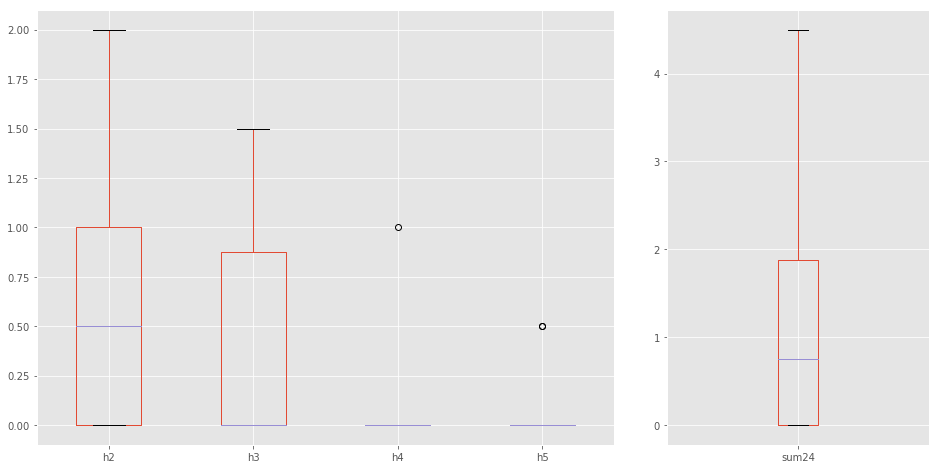

### Results for Tight End, Practice Type: Tues

  Number of Data Points: 15


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,2.00,2.5,0.5,0.00,5.25
Median,3.00,3.0,1.0,0.50,7.00
75 Percentile,3.75,4.0,1.5,0.75,8.00


##### Box Plots

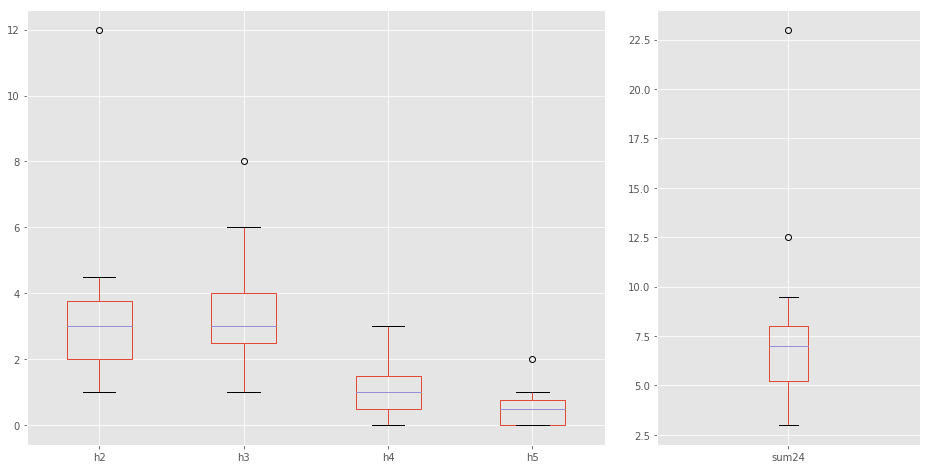

### Results for Tight End, Practice Type: Wed

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,3.0,1.0,0.0,0.0,5.0
Median,3.5,1.5,1.0,0.5,7.0
75 Percentile,4.5,3.0,1.5,1.0,9.0


##### Box Plots

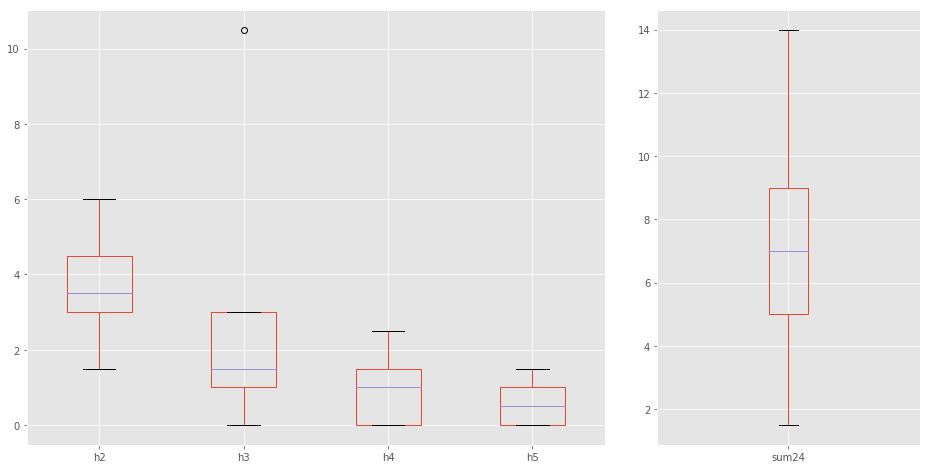

### Results for Tight End, Practice Type: Wed/Thurs

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.5,2.25,1.00,0.25,5.50
Median,2.0,2.50,1.00,0.50,7.00
75 Percentile,3.0,3.50,1.75,0.50,8.25


##### Box Plots

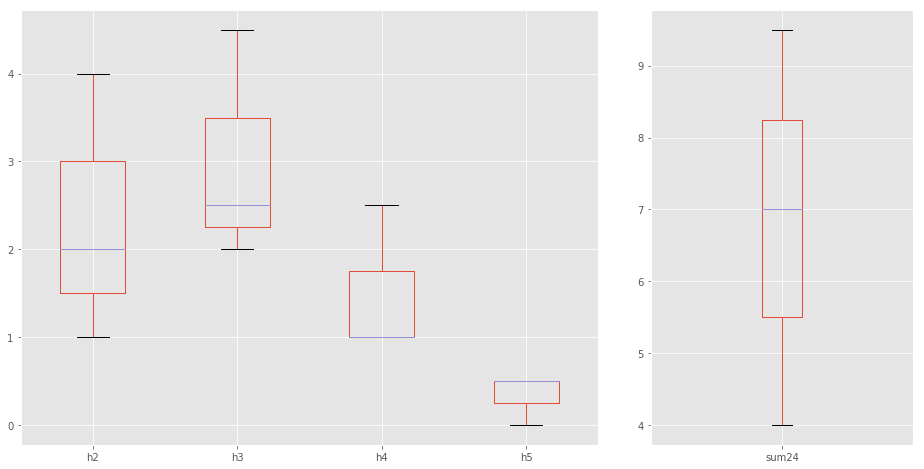

### Results for Wide Receiver, Practice Type: Camp

  Number of Data Points: 11


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

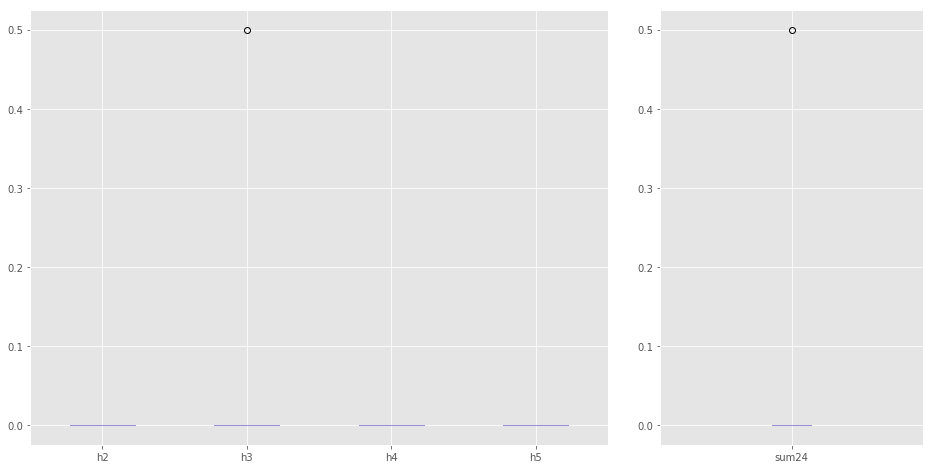

### Results for Wide Receiver, Practice Type: Scrimmage

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.5,0.0,0.0,0.5
Median,0.0,0.5,0.0,0.0,0.5
75 Percentile,0.0,0.5,0.0,0.0,0.5


##### Box Plots

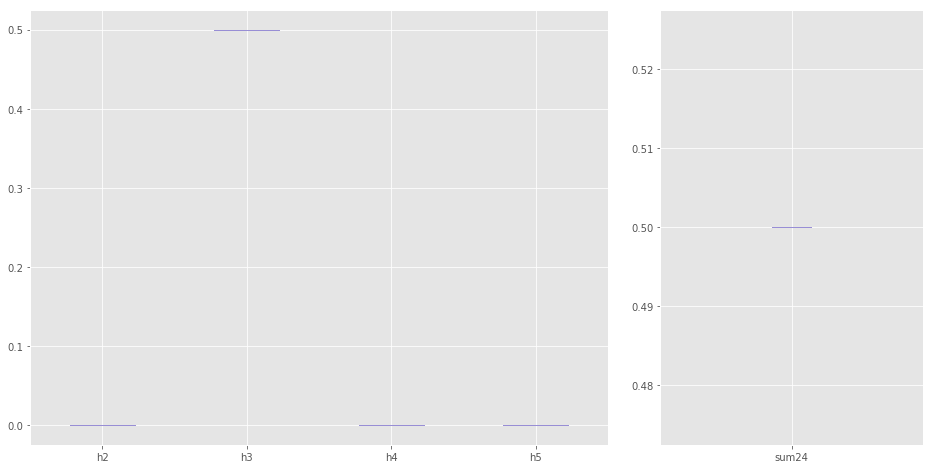

### Results for Wide Receiver, Practice Type: Thurs

  Number of Data Points: 7


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.00,0.00,0.0,0.00
Median,0.5,0.00,0.00,0.0,0.50
75 Percentile,3.0,0.25,0.25,0.0,3.75


##### Box Plots

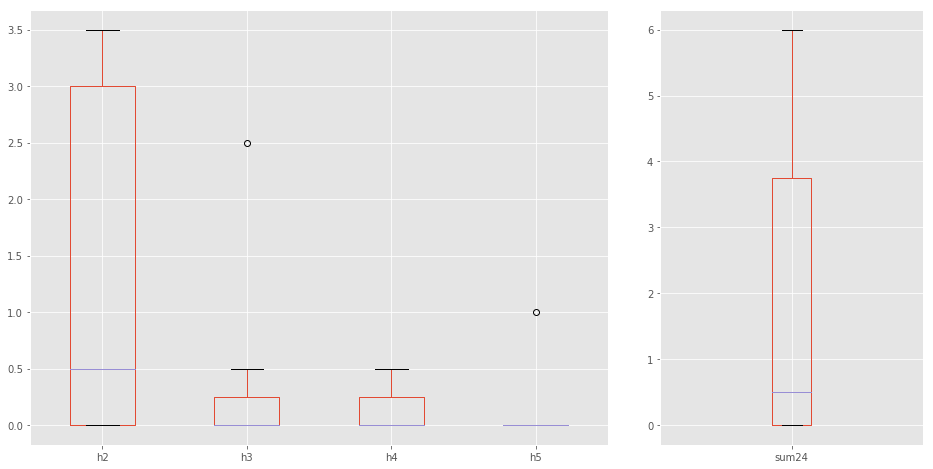

### Results for Wide Receiver, Practice Type: Tues

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.125,0.0,0.0,0.0,0.625
Median,1.000,0.5,0.0,0.0,1.250
75 Percentile,1.000,0.5,0.0,0.0,1.500


##### Box Plots

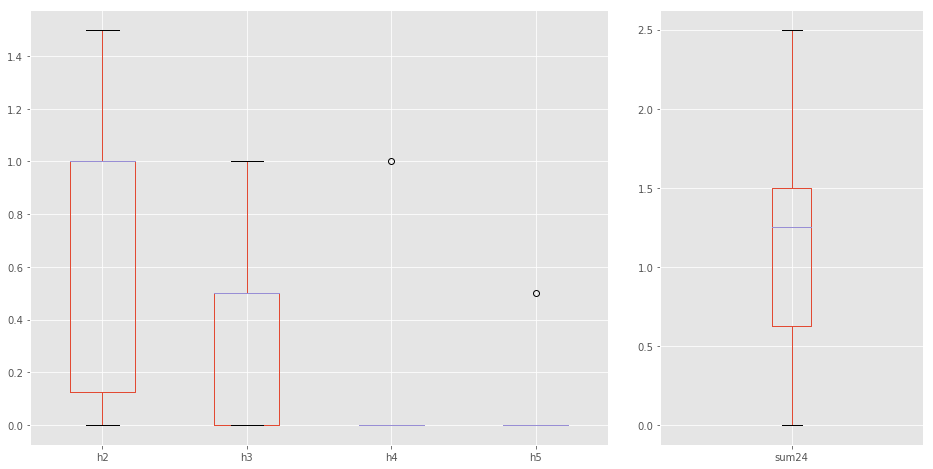

### Results for Wide Receiver, Practice Type: Wed

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.375,0.000,0.0,0.0,0.375
Median,0.750,0.000,0.0,0.0,1.000
75 Percentile,1.375,0.125,0.0,0.0,1.750


##### Box Plots

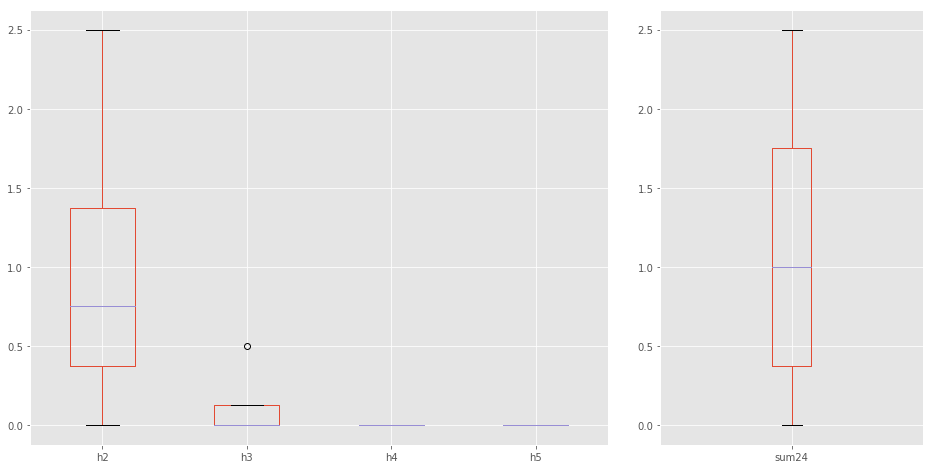

### Results for Wide Receiver, Practice Type: Wed/Thurs

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.5,0.0,0.0,0.5,0.5
Median,0.5,0.0,0.0,0.5,0.5
75 Percentile,0.5,0.0,0.0,0.5,0.5


##### Box Plots

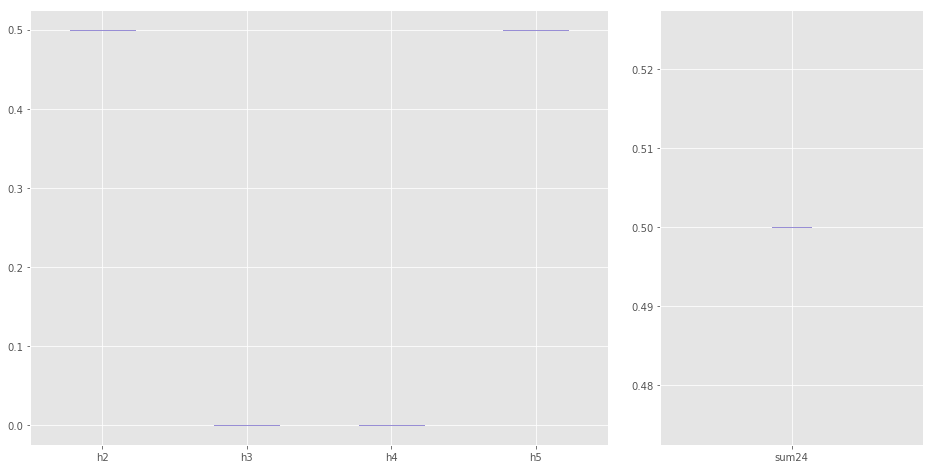

In [208]:
grps = (practices
         .groupby(['event', 'type', 'player'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
         .sum()
         .groupby(['player']))

for name, grp in grps:
    for n, g in grp.groupby('type'):
        printmd('### Results for {}, Practice Type: {}'.format(name.title(), n.title()))
        print('  Number of Data Points: {}'.format(g.shape[0]))
        #display(g)
        ## Give the median and interquartile ranges
        printmd('##### Interquartile and Median Values')
        dat = g.quantile([0.25, 0.50, 0.75])
        dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
        display(dat)
        printmd('##### Box Plots')
        fig = plt.figure(figsize=(16, 8))
        plt.subplot2grid((1,3), (0,0), colspan=2)
        g[['h2', 'h3', 'h4', 'h5']].boxplot()
        plt.subplot2grid((1,3), (0,2))
        g[['sum24']].boxplot()
        plt.show()

### Question 4: What is the exposure by practice activity across all positions?

This question is similar to question 3, only this time looking for exposure based on practice activity (skelly vs. def, 1on1, etc) instead of practice type (tues, wed, camp, etc) and looking at the data across all player positions. As such, we'll used the activity normalized data to answer this question. Similar to before, we'll group the data by practice and practice activity and sum the hits in each bin before regrouping by practice activity and taking the median value of all the practices. Additionally, we'll be dropping days 8/29 and 10/4 from the dataset, as the data from those days did not seem reliable.

In [219]:
(df_per_activity[df_per_activity.type != 'game']
          .drop(df_per_activity['2017-08-29'].index)
          .drop(df_per_activity['2017-10-04'].index)
          .groupby(['event', 'activity'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
          .sum()
          .groupby(['activity'])
          .aggregate(np.median))

,h2,h3,h4,h5,sum24
activity,,,,,
1on1,0.125000,0.000000,0.000000,0.000000,0.250000
1on1 then scouts,0.357143,0.142857,0.071429,0.142857,0.571429
cougar full zone,0.000000,0.000000,0.000000,0.000000,0.000000
cub session,0.142857,0.142857,0.000000,0.000000,0.285714
eagle run fit period,0.250000,0.250000,0.250000,0.000000,0.750000
goal line,0.142857,0.000000,0.000000,0.000000,0.142857
halfzone,0.000000,0.166667,0.000000,0.000000,0.166667
indy,0.505556,0.111111,0.000000,0.000000,0.609524
inside,0.600000,0.266667,0.000000,0.000000,0.816667


As you'll see below, there are a number of these practice activities that have very few (1 or 2) data points. We may want to not report data for these particular activities. If you all want to tell me what a reasonable threshold would be, I can remove that data. Let me know what you want to do.

### Results for 1On1

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000,0.0000,0.0,0.0,0.25
Median,0.125,0.0000,0.0,0.0,0.25
75 Percentile,0.250,0.1875,0.0,0.0,0.25


##### Box Plots

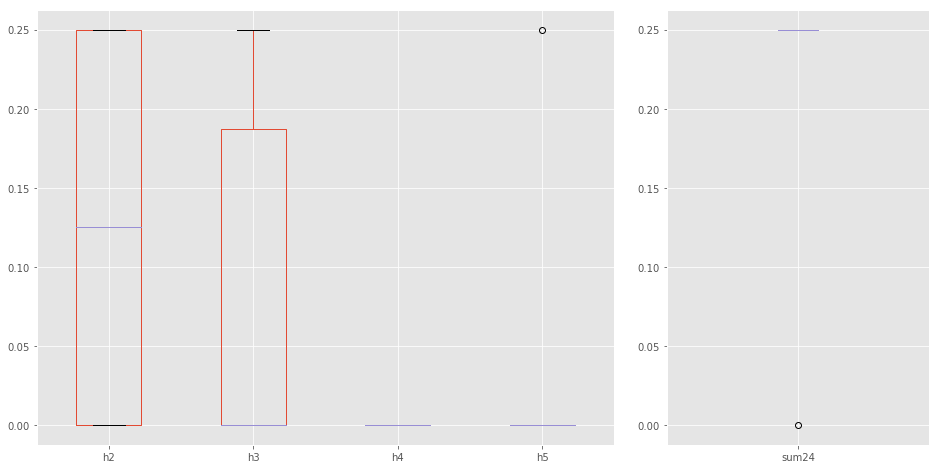

### Results for 1On1 Then Scouts

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.321429,0.142857,0.035714,0.071429,0.571429
Median,0.357143,0.142857,0.071429,0.142857,0.571429
75 Percentile,0.392857,0.142857,0.107143,0.214286,0.571429


##### Box Plots

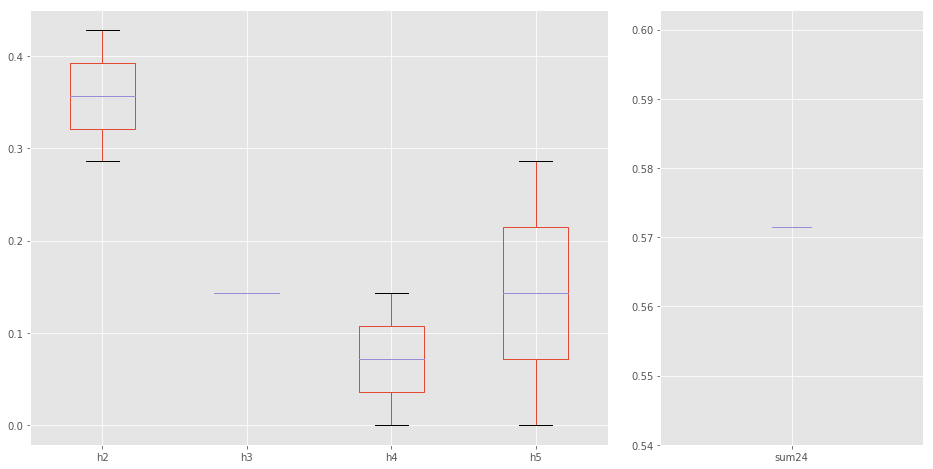

### Results for Cougar Full Zone

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

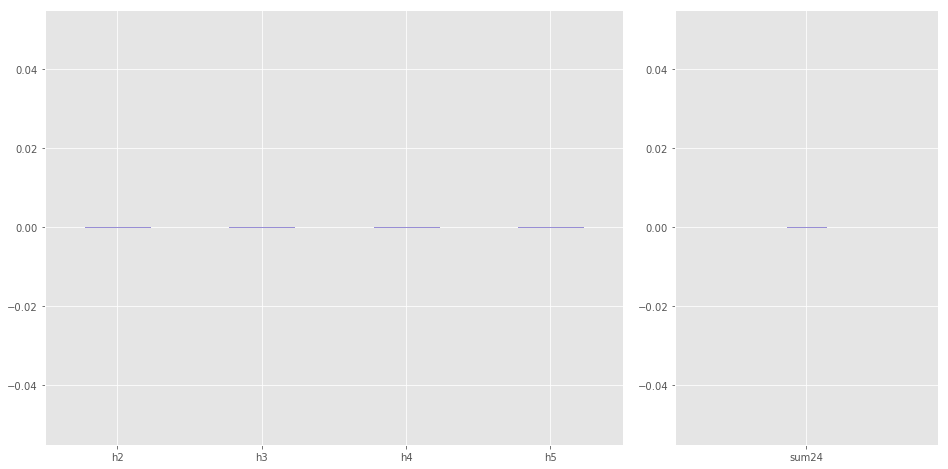

### Results for Cub Session

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.142857,0.142857,0.0,0.0,0.285714
Median,0.142857,0.142857,0.0,0.0,0.285714
75 Percentile,0.142857,0.142857,0.0,0.0,0.285714


##### Box Plots

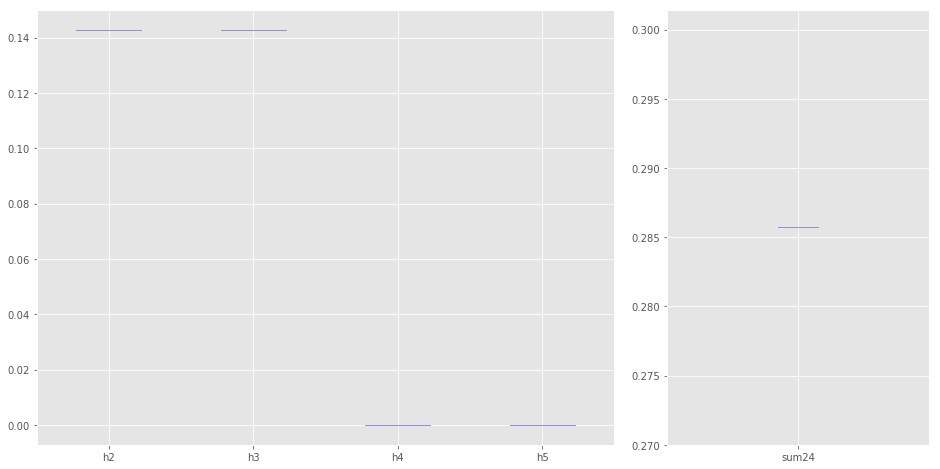

### Results for Eagle Run Fit Period

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.25,0.25,0.25,0.0,0.75
Median,0.25,0.25,0.25,0.0,0.75
75 Percentile,0.25,0.25,0.25,0.0,0.75


##### Box Plots

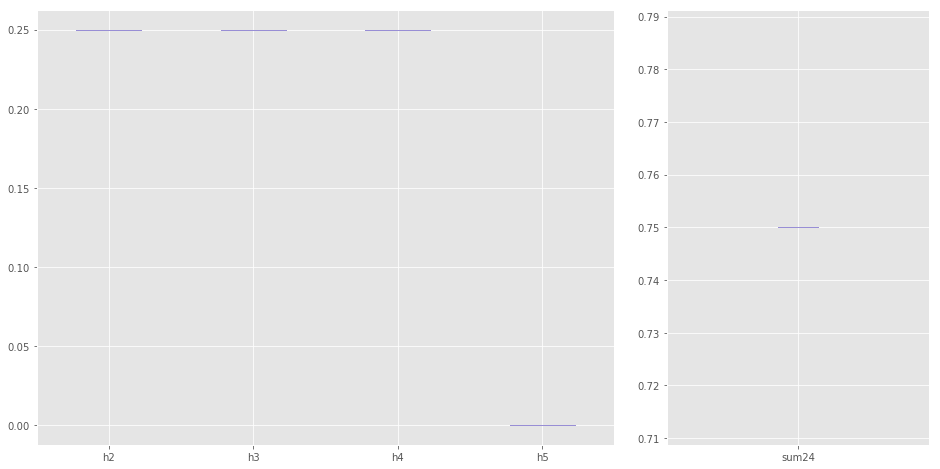

### Results for Goal Line

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.142857,0.0,0.0,0.0,0.142857
Median,0.142857,0.0,0.0,0.0,0.142857
75 Percentile,0.142857,0.0,0.0,0.0,0.142857


##### Box Plots

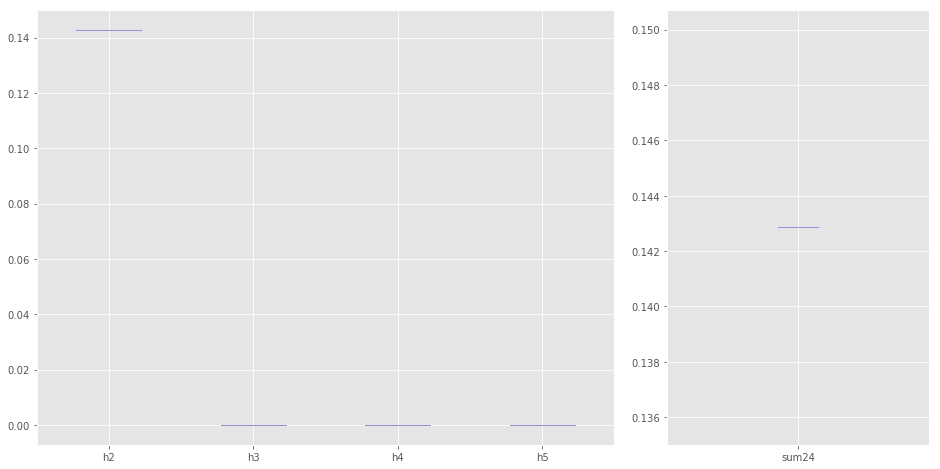

### Results for Halfzone

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.166667,0.0,0.0,0.166667
Median,0.0,0.166667,0.0,0.0,0.166667
75 Percentile,0.0,0.166667,0.0,0.0,0.166667


##### Box Plots

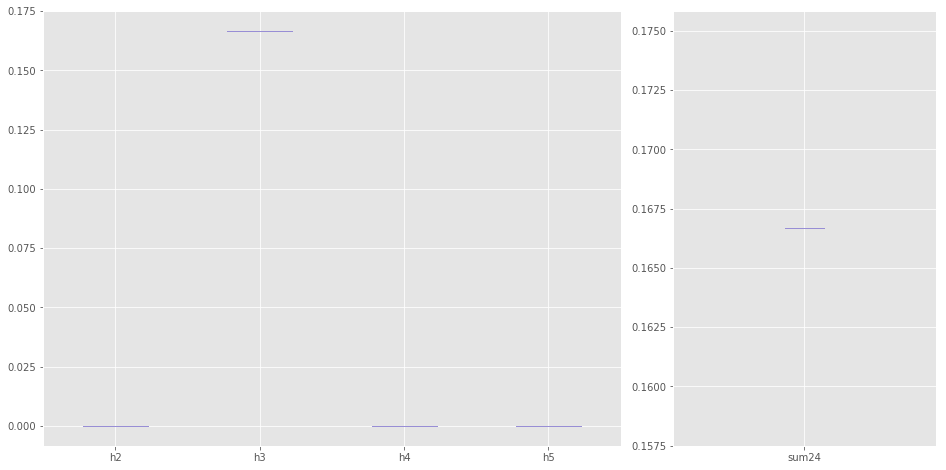

### Results for Indy

  Number of Data Points: 54


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.229167,0.000000,0.0,0.0,0.333333
Median,0.505556,0.111111,0.0,0.0,0.609524
75 Percentile,0.958333,0.352679,0.1,0.0,1.444444


##### Box Plots

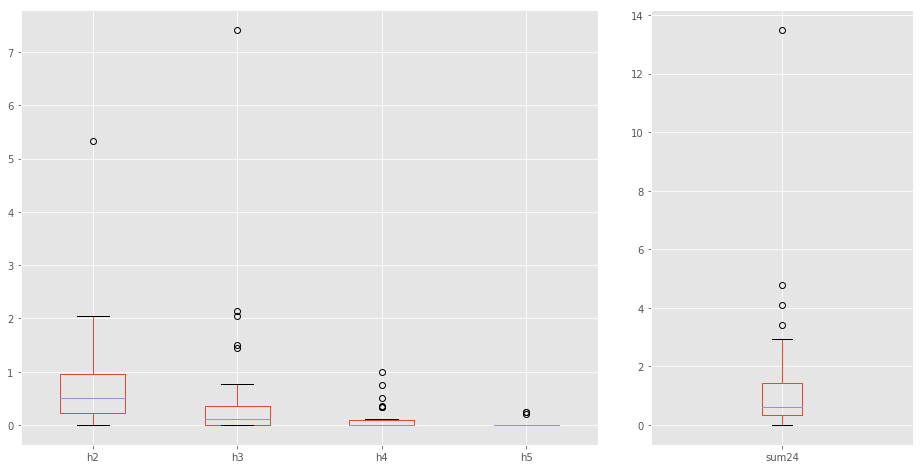

### Results for Inside

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.233333,0.050000,0.0,0.0,0.500000
Median,0.600000,0.266667,0.0,0.0,0.816667
75 Percentile,0.750000,0.400000,0.0,0.0,1.300000


##### Box Plots

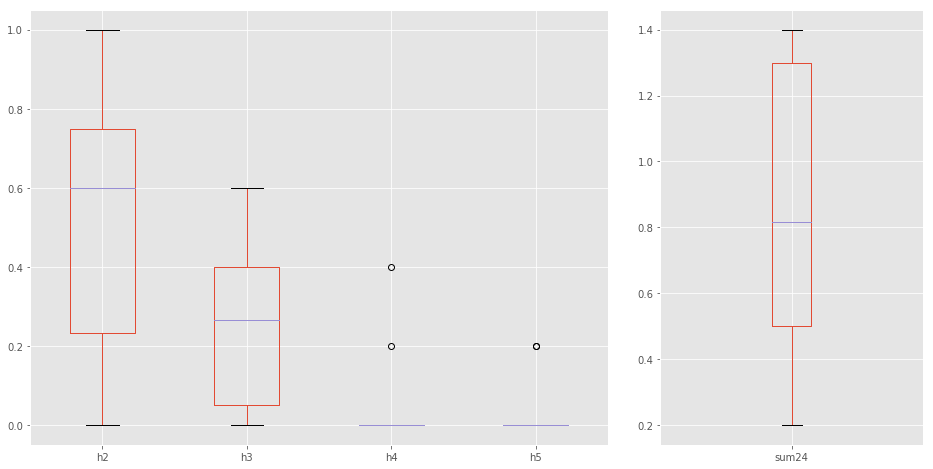

### Results for Inside Emphasis

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.142857,0.0,0.0,0.0,0.142857
Median,0.142857,0.0,0.0,0.0,0.142857
75 Percentile,0.142857,0.0,0.0,0.0,0.142857


##### Box Plots

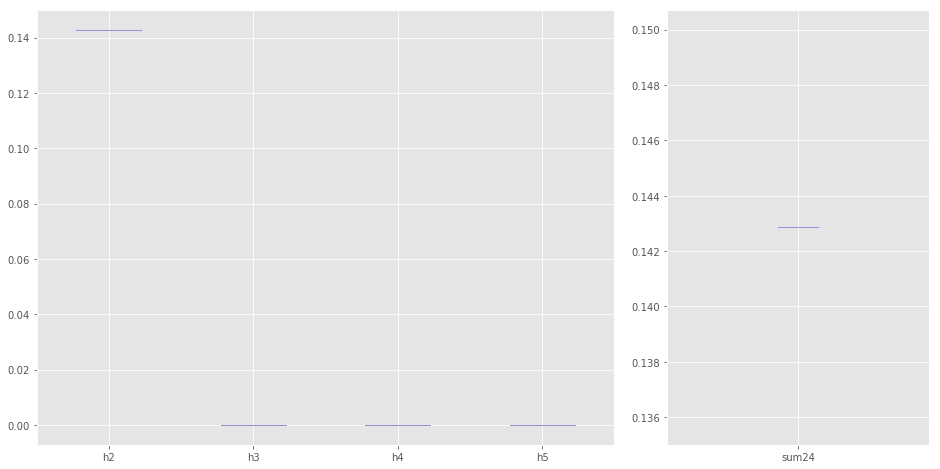

### Results for Inside/1On1

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.233333,0.100000,0.0,0.0,0.350000
Median,0.400000,0.111111,0.0,0.0,0.577778
75 Percentile,0.433333,0.383333,0.0,0.0,0.794444


##### Box Plots

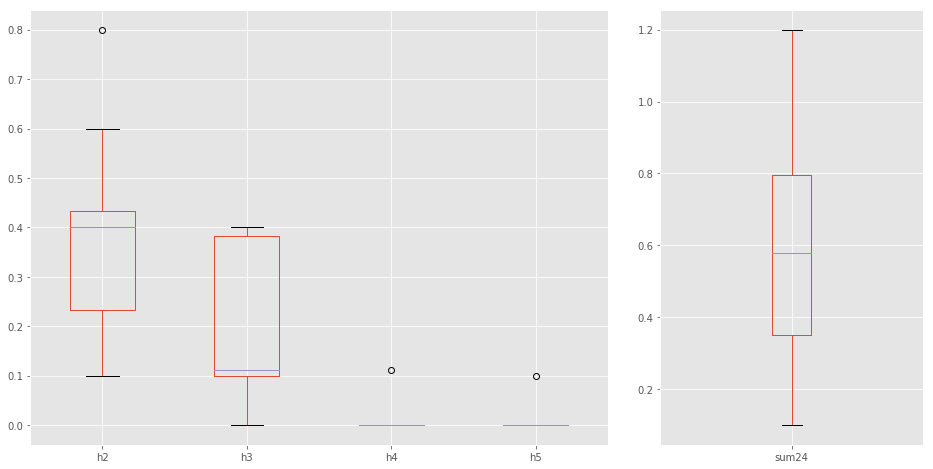

### Results for Kick Off

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.166667,0.0,0.0,0.0,0.250000
75 Percentile,0.250000,0.0,0.0,0.0,0.333333


##### Box Plots

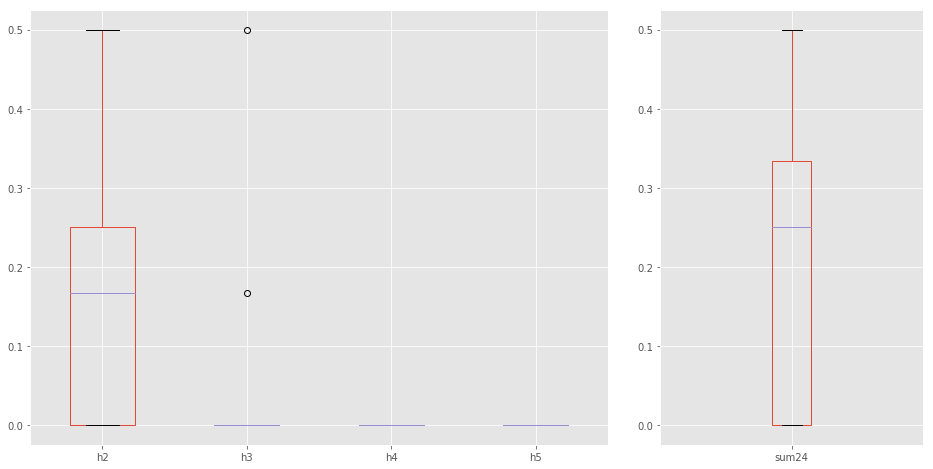

### Results for Kickoff

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.00,0.0,0.0,0.00
Median,0.1,0.00,0.0,0.0,0.10
75 Percentile,0.2,0.15,0.0,0.0,0.35


##### Box Plots

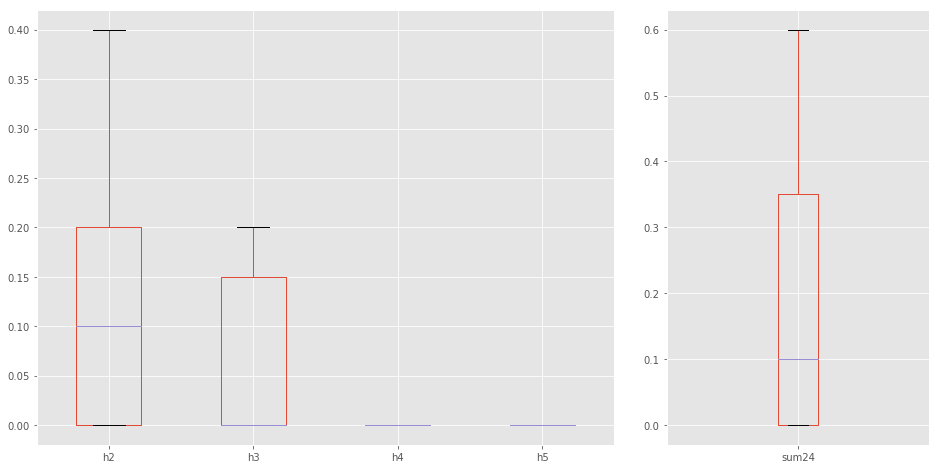

### Results for Kor

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.0,0.0,0.0,0.0
Median,0.00,0.0,0.0,0.0,0.0
75 Percentile,0.15,0.0,0.0,0.0,0.3


##### Box Plots

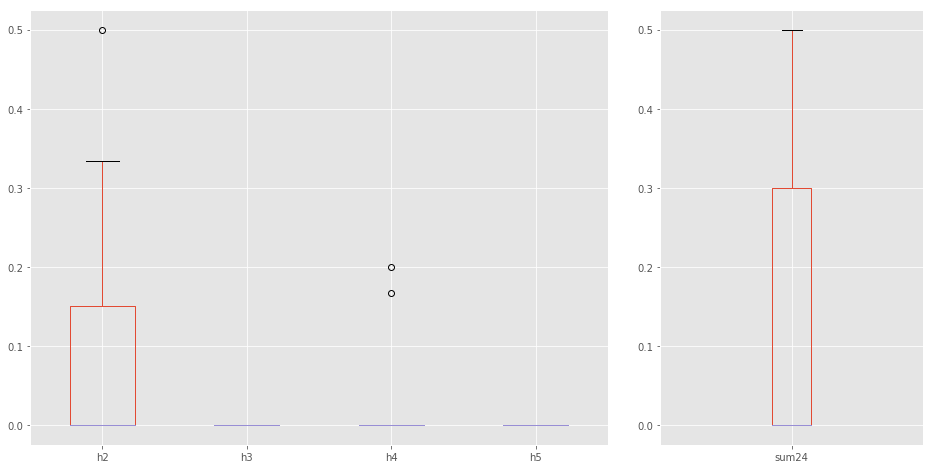

### Results for Line Games

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.083333,0.0,0.083333
Median,0.0,0.0,0.166667,0.0,0.166667
75 Percentile,0.0,0.0,0.250000,0.0,0.250000


##### Box Plots

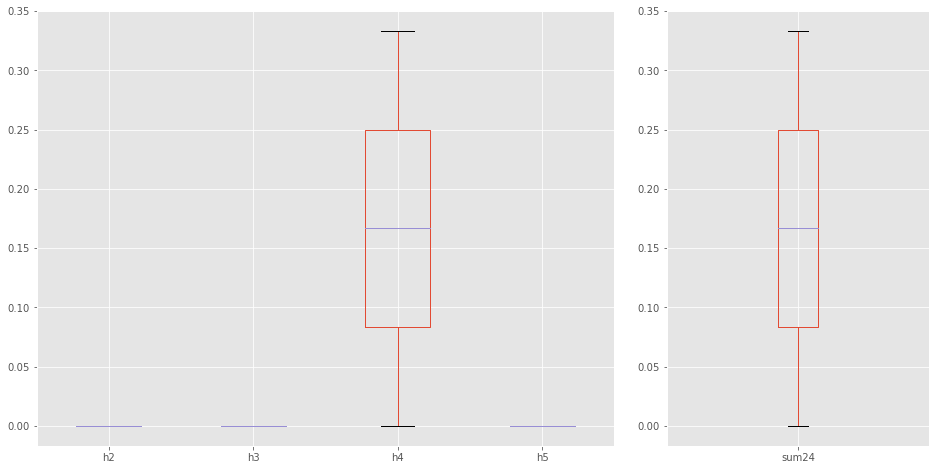

### Results for Mix Session

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.383333,0.107143,0.00,0.000000,0.511905
Median,0.414286,0.221429,0.00,0.000000,0.685714
75 Percentile,0.446429,0.300000,0.05,0.035714,0.825000


##### Box Plots

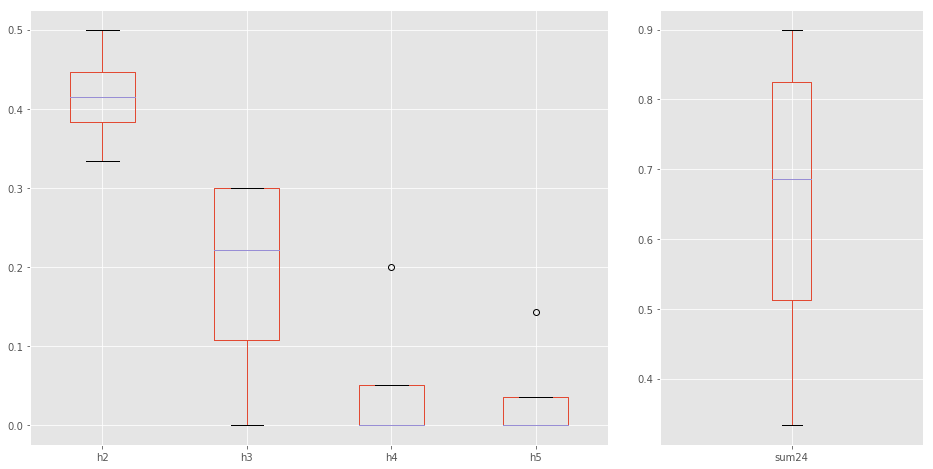

### Results for Otb

  Number of Data Points: 24


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.000000
Median,0.000000,0.0,0.0,0.0,0.050000
75 Percentile,0.111111,0.1,0.0,0.0,0.205556


##### Box Plots

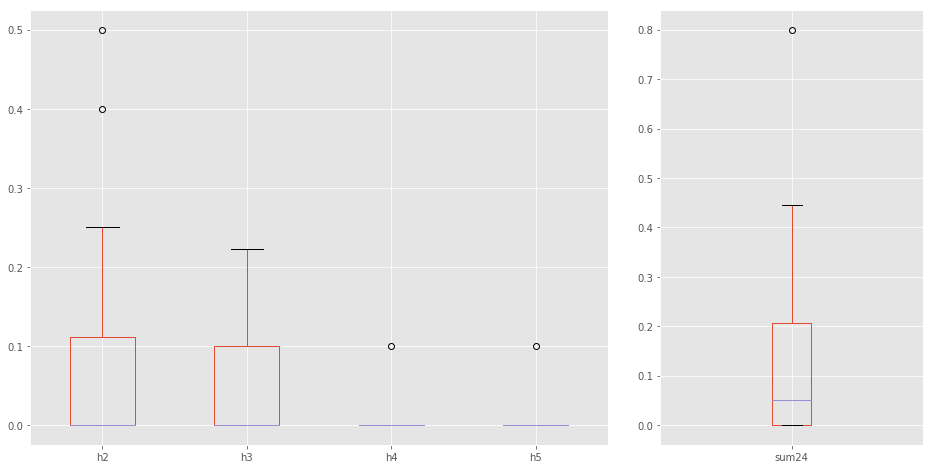

### Results for Pap

  Number of Data Points: 8


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.111111,0.000000,0.000000,0.0,0.121528
Median,0.173611,0.000000,0.055556,0.0,0.333333
75 Percentile,0.241667,0.158333,0.133333,0.0,0.625000


##### Box Plots

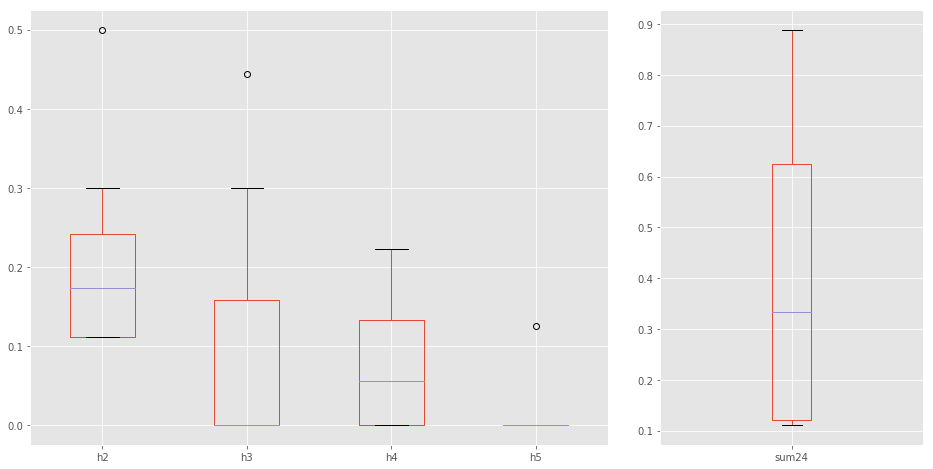

### Results for Pass Rush

  Number of Data Points: 30


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0000,0.0,0.0,0.062500
Median,0.250000,0.0000,0.0,0.0,0.333333
75 Percentile,0.458333,0.3125,0.0,0.0,0.625000


##### Box Plots

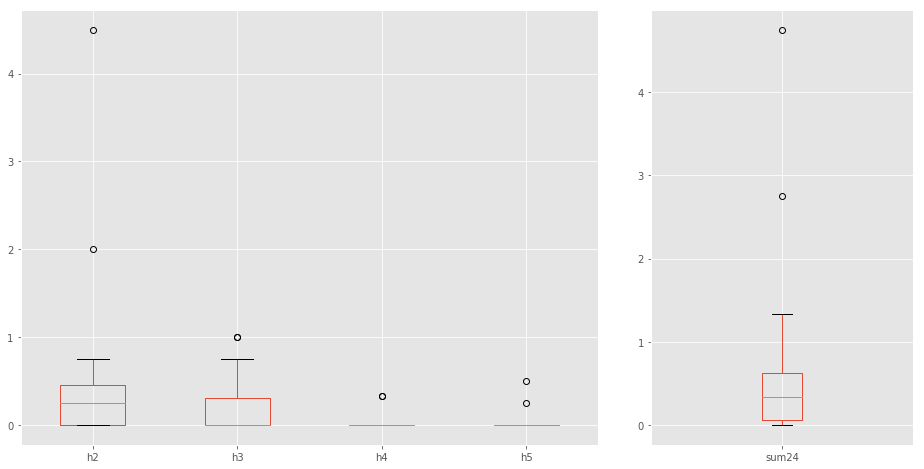

### Results for Pat/Fg

  Number of Data Points: 32


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.0,0.0,0.0,0.075000
Median,0.111111,0.0,0.0,0.0,0.133929
75 Percentile,0.261905,0.0,0.0,0.0,0.285714


##### Box Plots

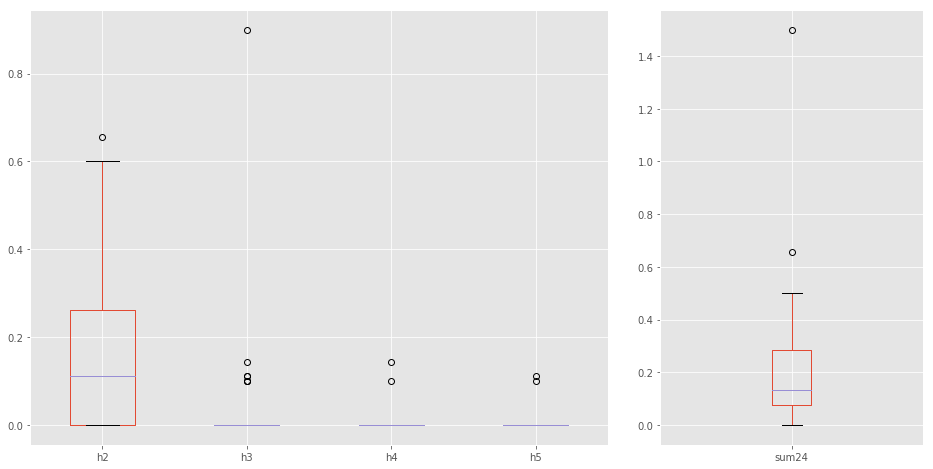

### Results for Perimeter Period

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.285714,0.0,0.0,0.285714
Median,0.0,0.285714,0.0,0.0,0.285714
75 Percentile,0.0,0.285714,0.0,0.0,0.285714


##### Box Plots

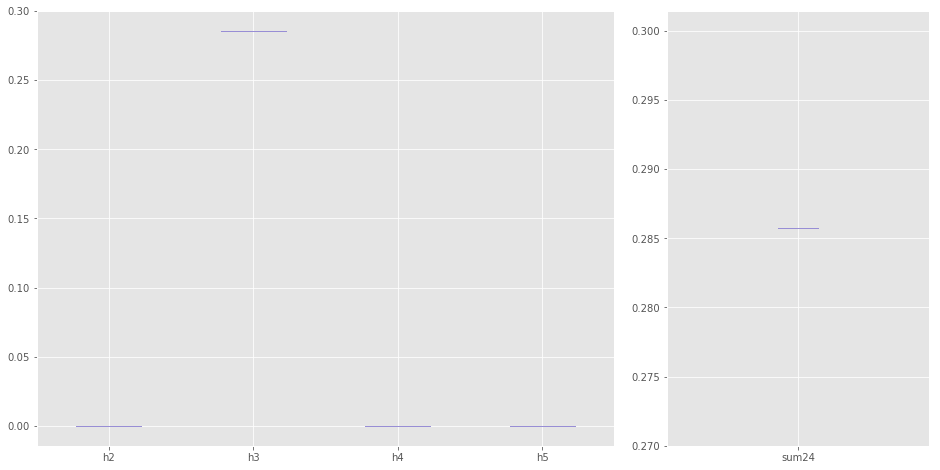

### Results for Post

  Number of Data Points: 5


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

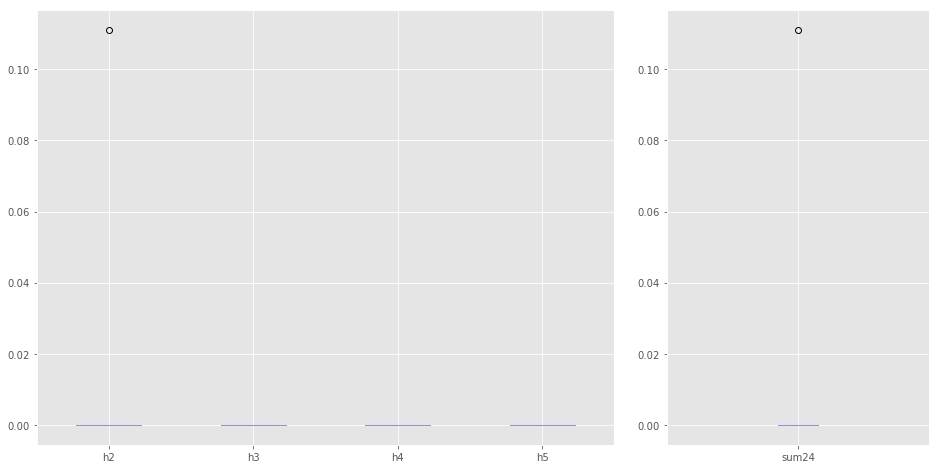

### Results for Post-Practice

  Number of Data Points: 9


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.00,0.000,0.0,0.0,0.25
Median,0.00,0.125,0.0,0.0,0.25
75 Percentile,0.25,0.250,0.0,0.0,0.50


##### Box Plots

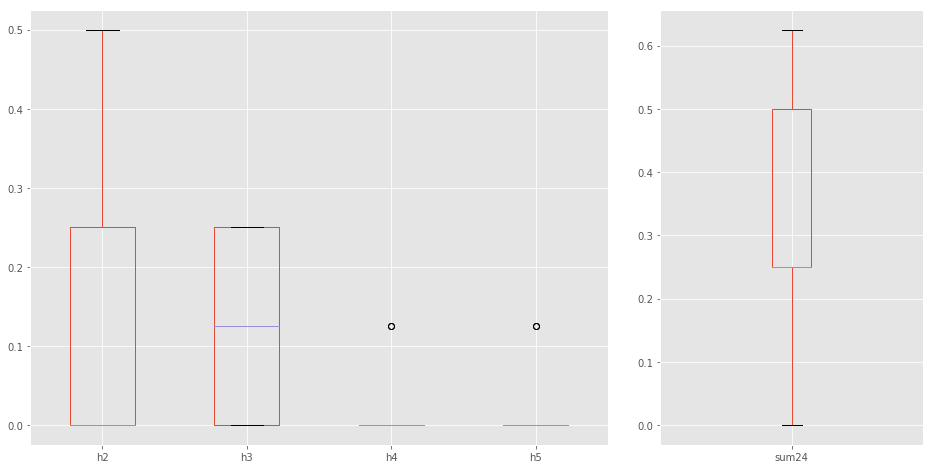

### Results for Post-Practice/Kick Off

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.025,0.0,0.0,0.0,0.025
Median,0.050,0.0,0.0,0.0,0.050
75 Percentile,0.075,0.0,0.0,0.0,0.075


##### Box Plots

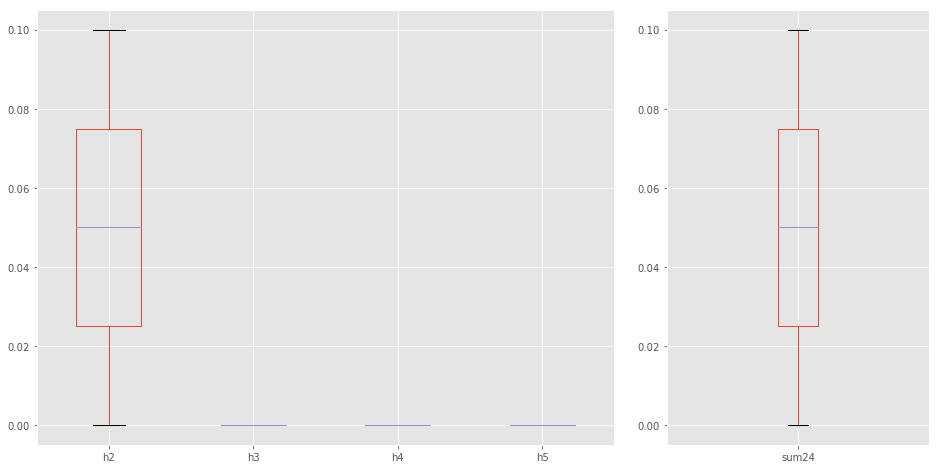

### Results for Post-Practice/Kickoff

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.000000,0.0,0.00
Median,0.083333,0.000000,0.050000,0.0,0.25
75 Percentile,0.225000,0.041667,0.116667,0.0,0.50


##### Box Plots

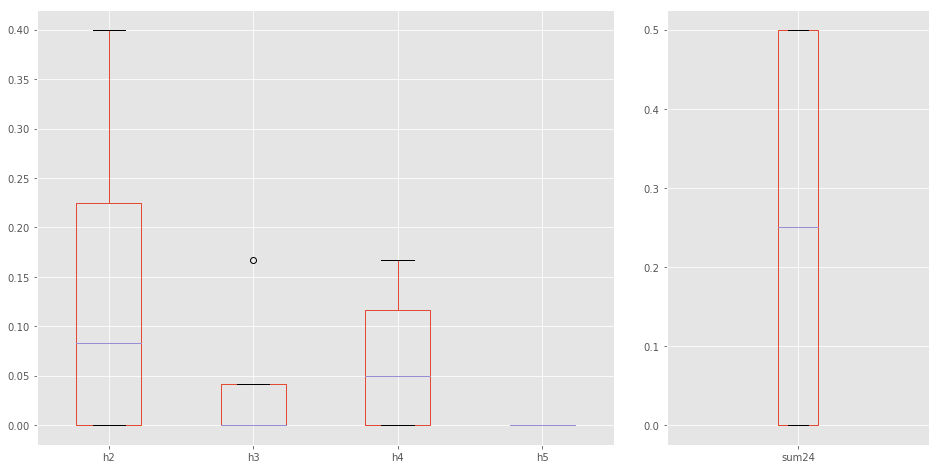

### Results for Post-Practice/Kor

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.138889,0.0,0.0,0.0,0.138889
Median,0.253968,0.0,0.0,0.0,0.253968
75 Percentile,0.321429,0.0,0.0,0.0,0.321429


##### Box Plots

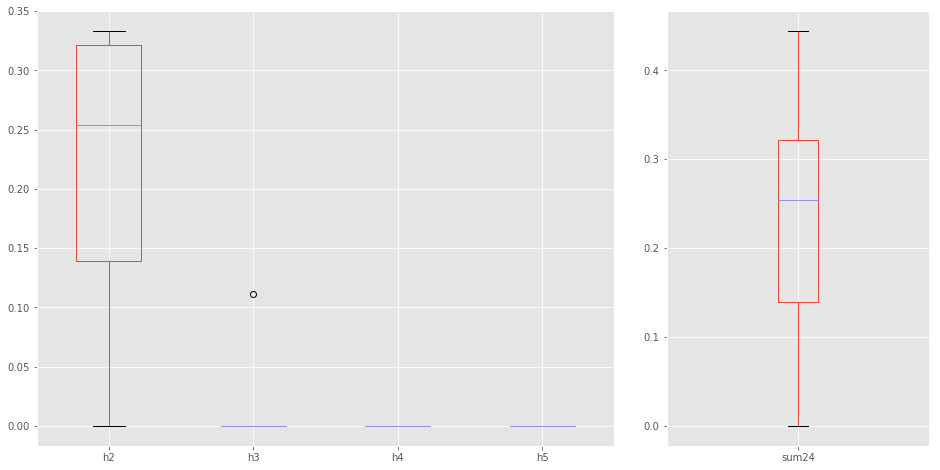

### Results for Post-Practice/Punt

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

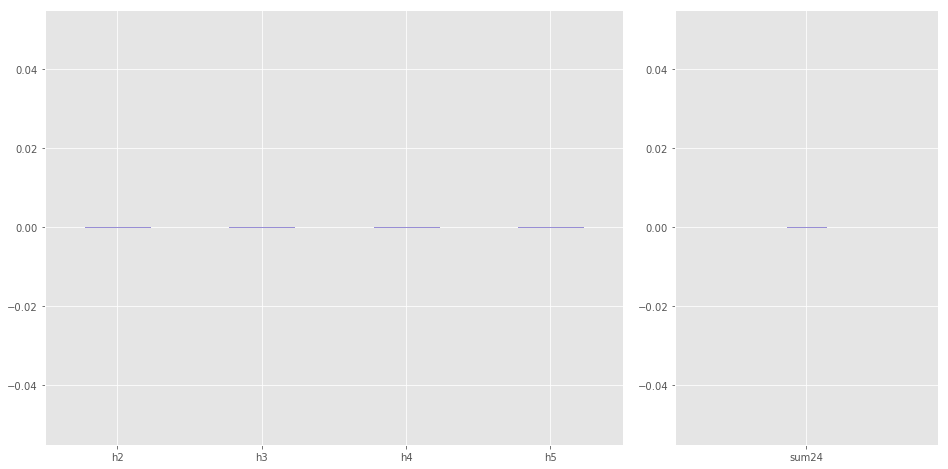

### Results for Post-Practice/Punt Return

  Number of Data Points: 10


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.025000,0.00000,0.0,0.0,0.100000
Median,0.105556,0.00000,0.0,0.0,0.125000
75 Percentile,0.138393,0.09375,0.0,0.0,0.212798


##### Box Plots

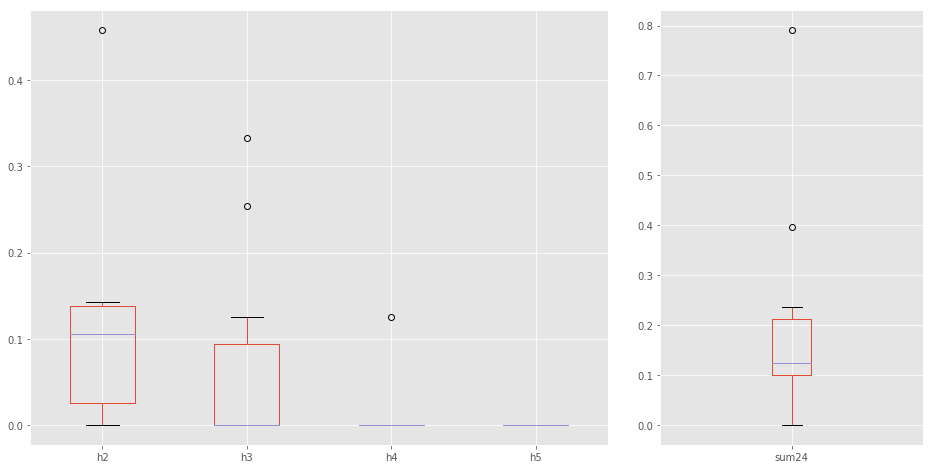

### Results for Post-Practice/Punt Team

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.041667,0.0,0.0,0.041667
Median,0.0,0.083333,0.0,0.0,0.083333
75 Percentile,0.0,0.125000,0.0,0.0,0.125000


##### Box Plots

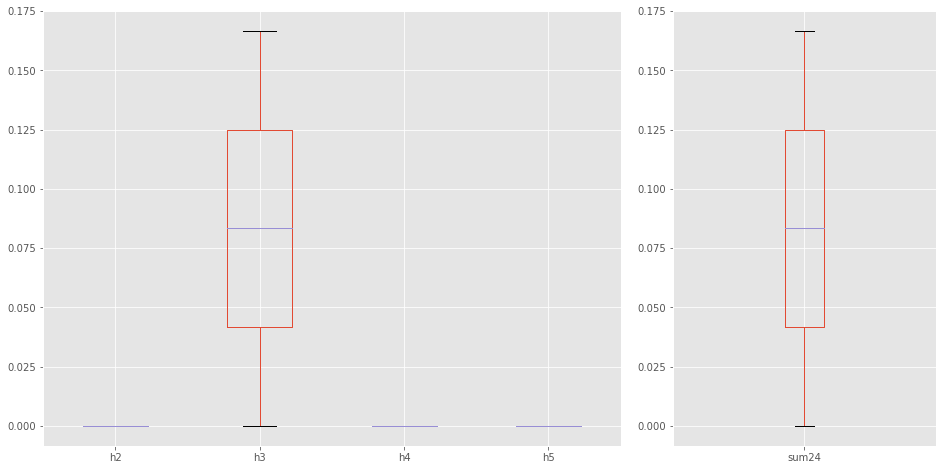

### Results for Post-Practice/Turn Over

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.075000,0.000000,0.0,0.0,0.150000
Median,0.161111,0.050000,0.0,0.0,0.211111
75 Percentile,0.222222,0.102778,0.0,0.0,0.250000


##### Box Plots

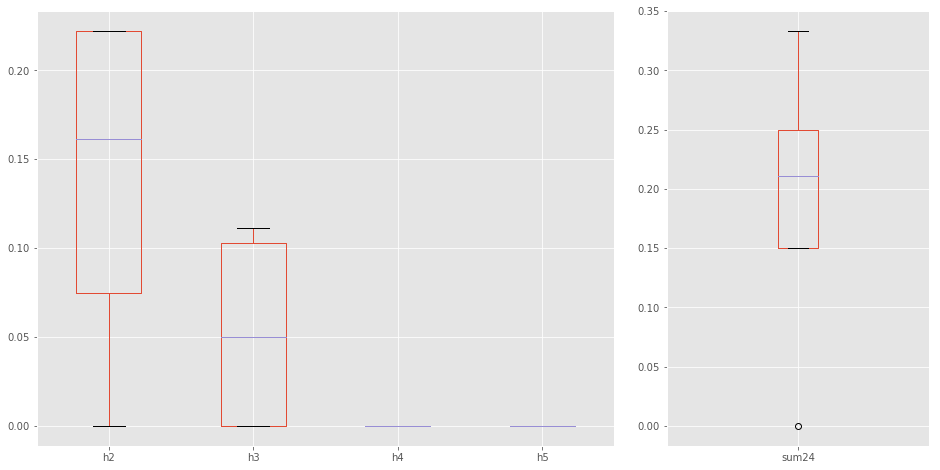

### Results for Pre

  Number of Data Points: 37


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000,0.000000,0.0,0.0,0.000000
Median,0.100,0.000000,0.0,0.0,0.111111
75 Percentile,0.125,0.111111,0.0,0.0,0.250000


##### Box Plots

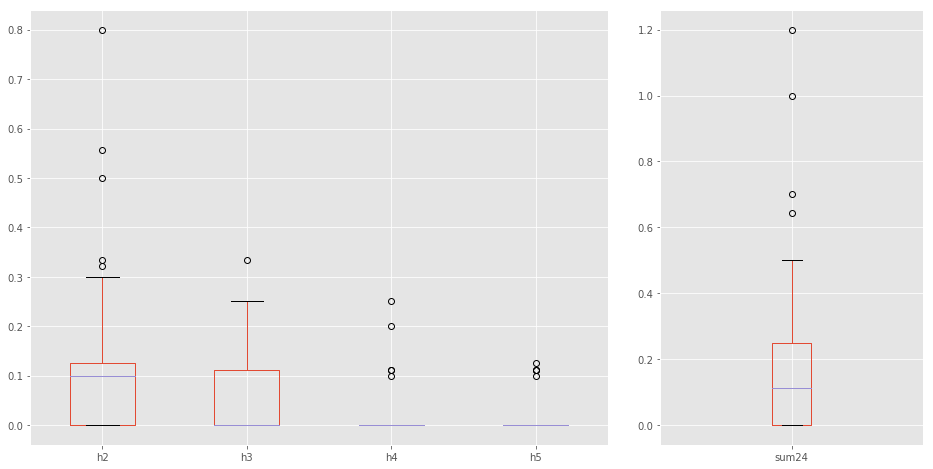

### Results for Punt

  Number of Data Points: 17


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.166667,0.0,0.0,0.0,0.166667
Median,0.200000,0.0,0.0,0.0,0.200000
75 Percentile,0.250000,0.0,0.0,0.0,0.250000


##### Box Plots

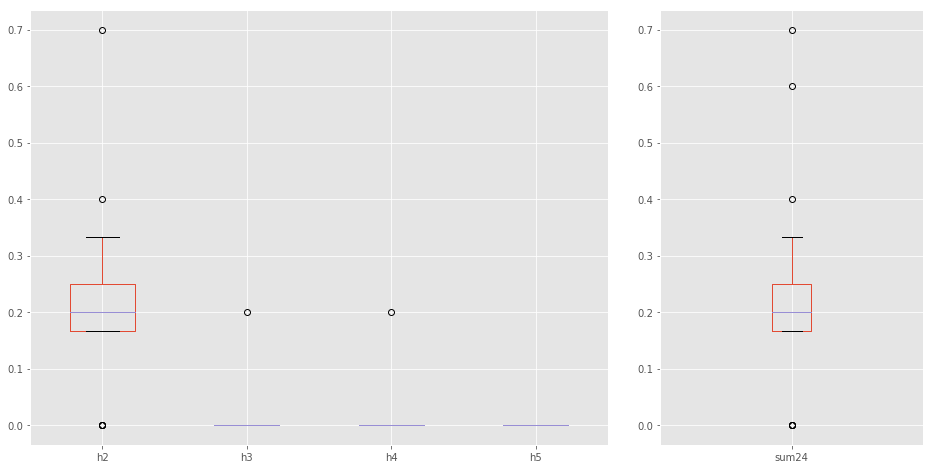

### Results for Punt Return

  Number of Data Points: 4


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.1,0.0,0.0,0.0,0.1


##### Box Plots

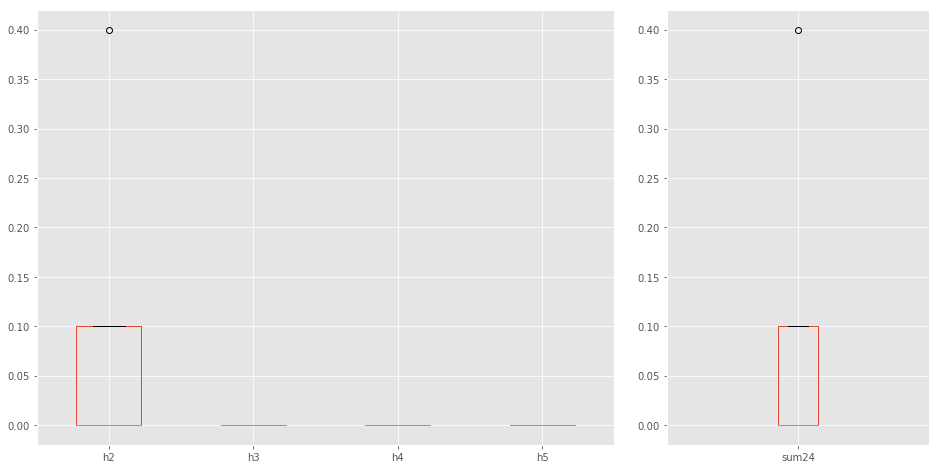

### Results for Red Zone Skell Vs. Scouts

  Number of Data Points: 6


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000,0.0,0.0,0.0,0.000
Median,0.125,0.0,0.0,0.0,0.125
75 Percentile,0.250,0.0,0.0,0.0,0.250


##### Box Plots

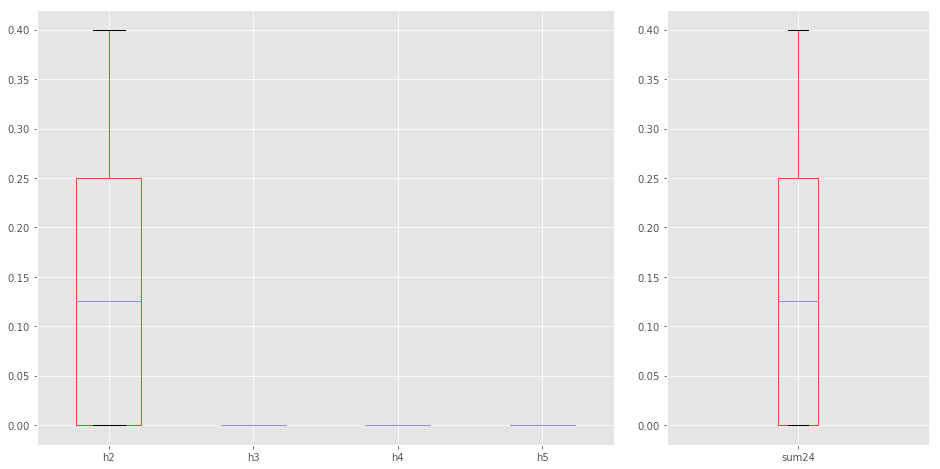

### Results for Run Fit

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.035714,0.0,0.035714
Median,0.0,0.0,0.071429,0.0,0.071429
75 Percentile,0.0,0.0,0.107143,0.0,0.107143


##### Box Plots

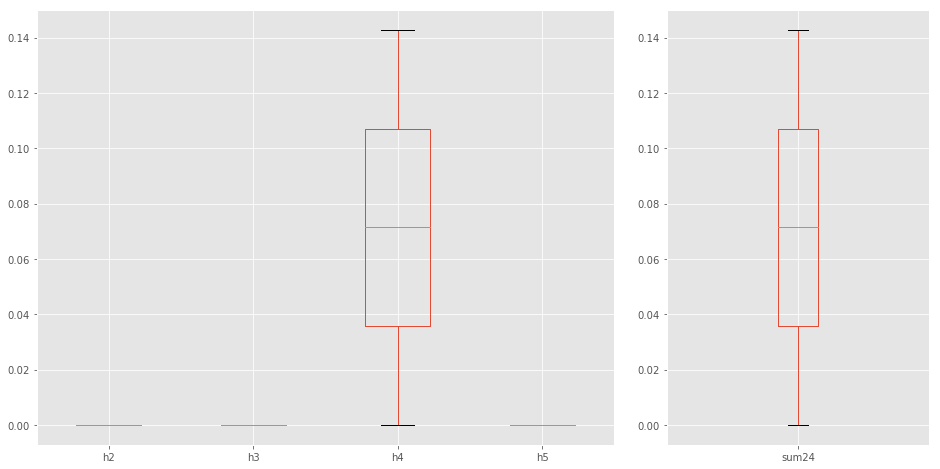

### Results for Run Fits

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.2,0.2,0.2,0.0,0.6
Median,0.2,0.2,0.2,0.0,0.6
75 Percentile,0.2,0.2,0.2,0.0,0.6


##### Box Plots

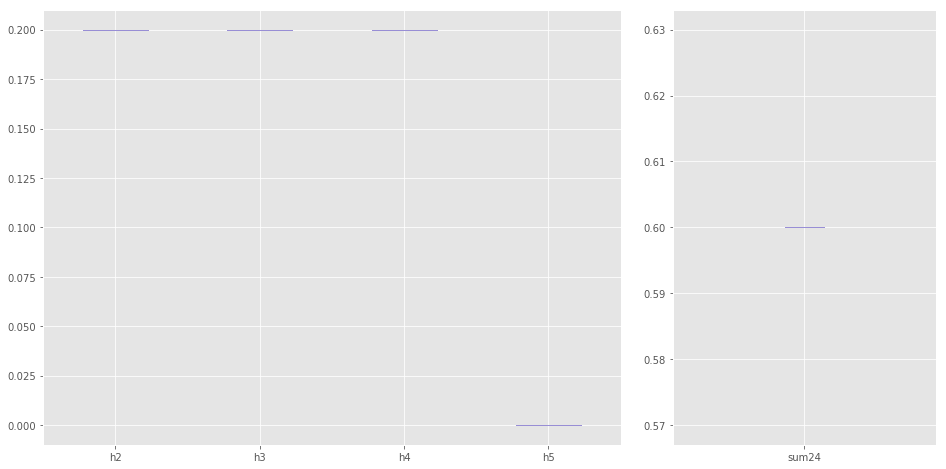

### Results for Run Pursuit

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.111111,0.0,0.0,0.0,0.111111
Median,0.111111,0.0,0.0,0.0,0.111111
75 Percentile,0.111111,0.0,0.0,0.0,0.111111


##### Box Plots

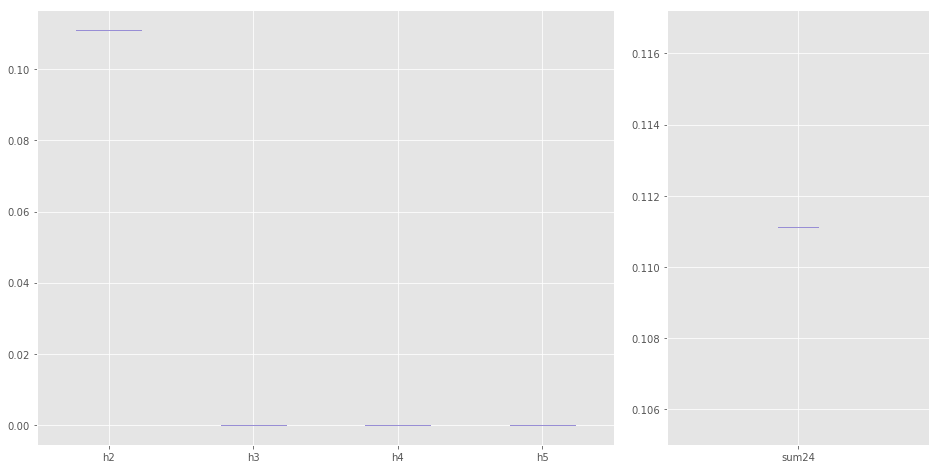

### Results for Run Session

  Number of Data Points: 21


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.142857,0.000000,0.0,0.0,0.222222
Median,0.222222,0.142857,0.0,0.0,0.428571
75 Percentile,0.300000,0.285714,0.0,0.0,0.600000


##### Box Plots

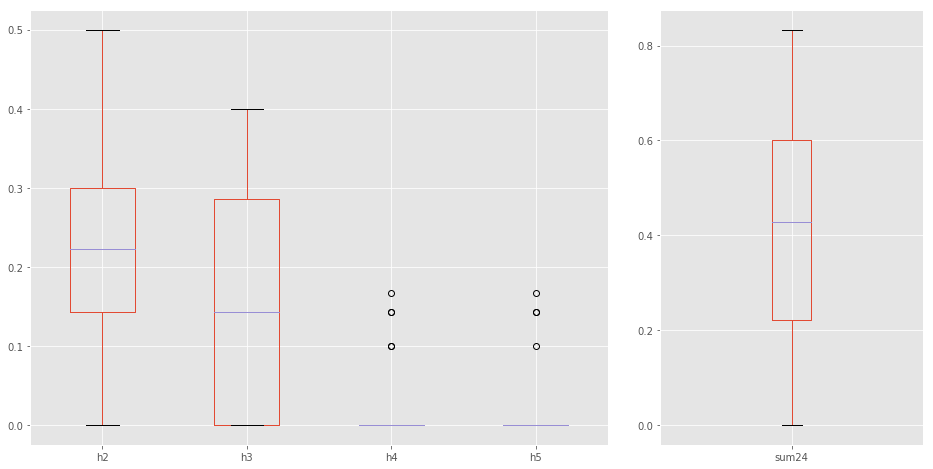

### Results for Run Session  Vs. Scouts

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

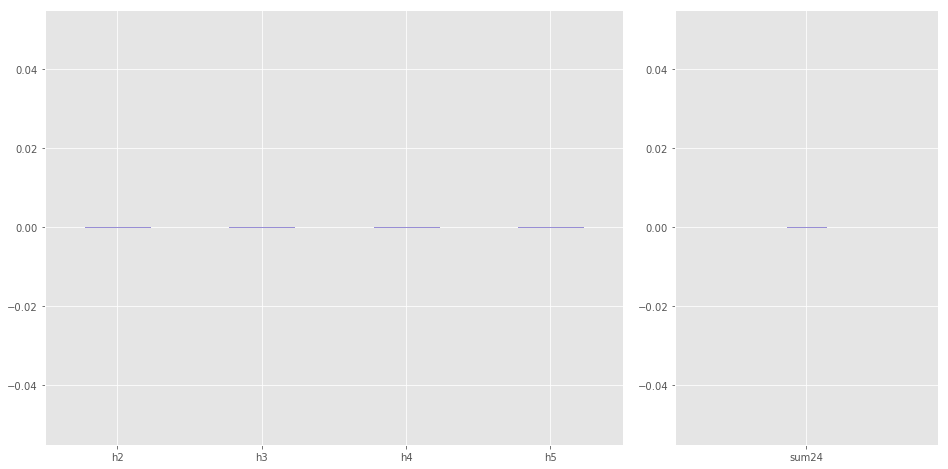

### Results for Run Session Vs. Scouts

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.175,0.0,0.025,0.025,0.2
Median,0.250,0.0,0.050,0.050,0.3
75 Percentile,0.325,0.0,0.075,0.075,0.4


##### Box Plots

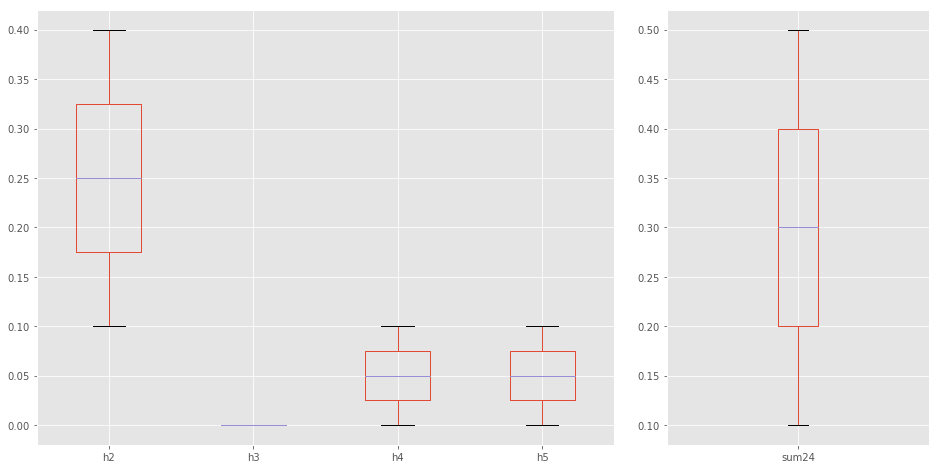

### Results for Run Session-Blitz

  Number of Data Points: 21


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.222222,0.000000,0.000,0.0,0.500000
Median,0.333333,0.222222,0.000,0.0,0.625000
75 Percentile,0.444444,0.375000,0.125,0.0,0.888889


##### Box Plots

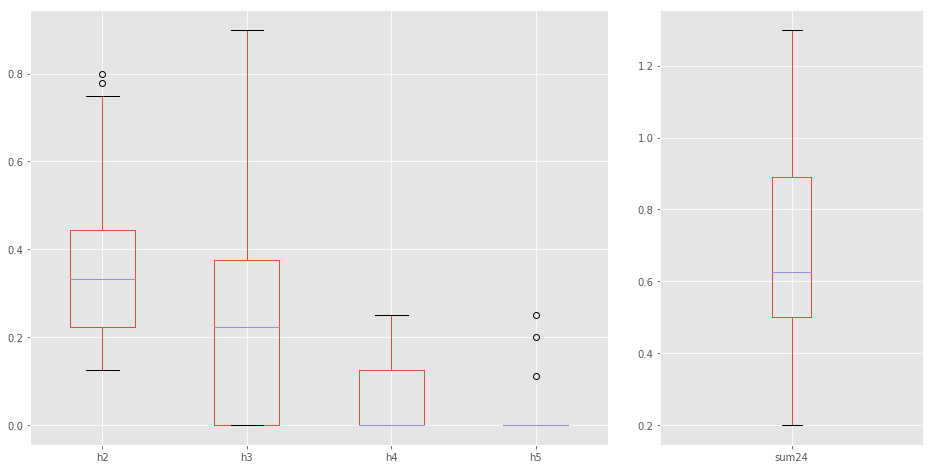

### Results for Scrimmage

  Number of Data Points: 3


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,1.516667,0.761111,0.166667,0.00,2.444444
Median,2.333333,1.222222,0.333333,0.00,3.888889
75 Percentile,2.811111,1.255556,0.605556,0.15,4.672222


##### Box Plots

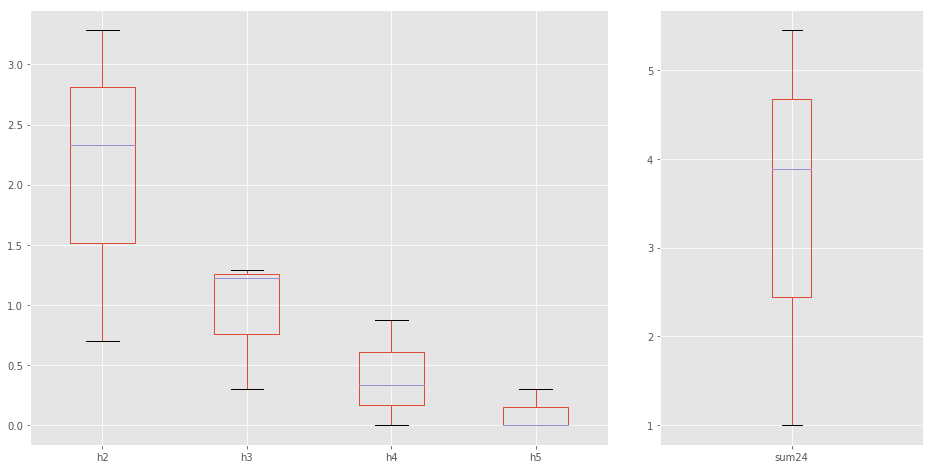

### Results for Skell Vs. Def

  Number of Data Points: 20


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.000,0.0,0.083333
Median,0.105556,0.050000,0.000,0.0,0.200000
75 Percentile,0.200000,0.133333,0.025,0.0,0.350000


##### Box Plots

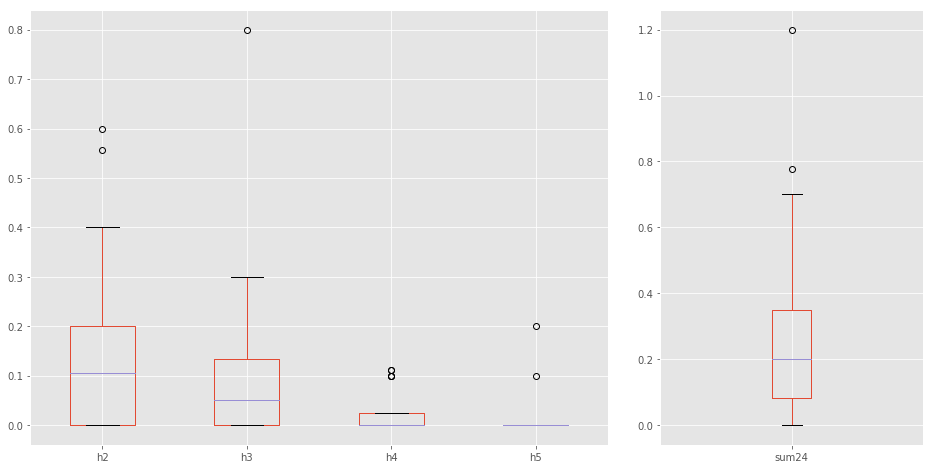

### Results for Skell Vs. Offense

  Number of Data Points: 20


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.000000
Median,0.166667,0.000000,0.0,0.0,0.208333
75 Percentile,0.333333,0.333333,0.0,0.0,0.541667


##### Box Plots

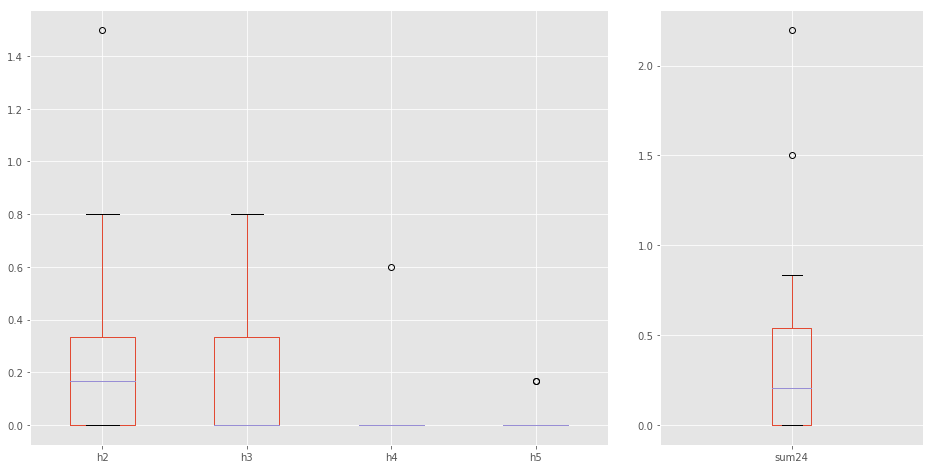

### Results for Skell Vs. Scouts

  Number of Data Points: 27


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.166667,0.000000,0.0,0.000000,0.225000
Median,0.250000,0.200000,0.0,0.000000,0.666667
75 Percentile,0.666667,0.366667,0.2,0.083333,1.100000


##### Box Plots

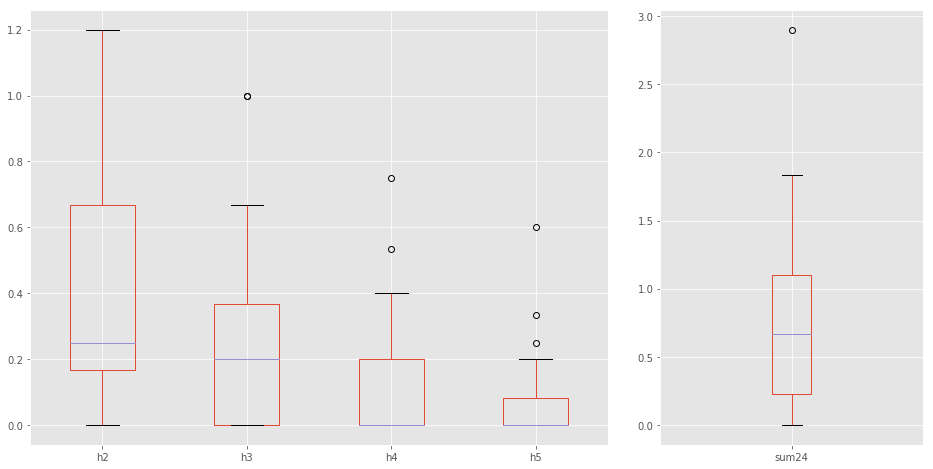

### Results for Team (3'S)

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.25,0.5,0.25,0.0,1.0
Median,0.25,0.5,0.25,0.0,1.0
75 Percentile,0.25,0.5,0.25,0.0,1.0


##### Box Plots

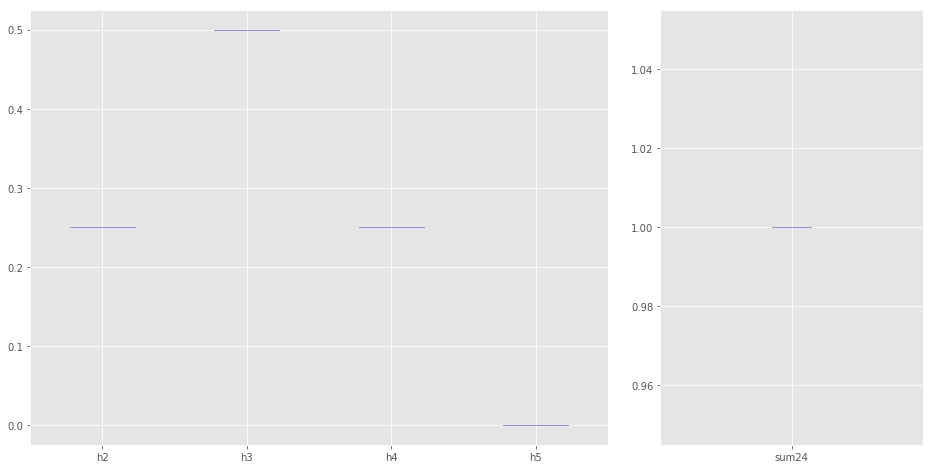

### Results for Team Situation

  Number of Data Points: 26


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.102778,0.000000,0.0,0.0,0.157143
Median,0.238095,0.111111,0.0,0.0,0.433333
75 Percentile,0.489583,0.219444,0.0,0.0,0.686111


##### Box Plots

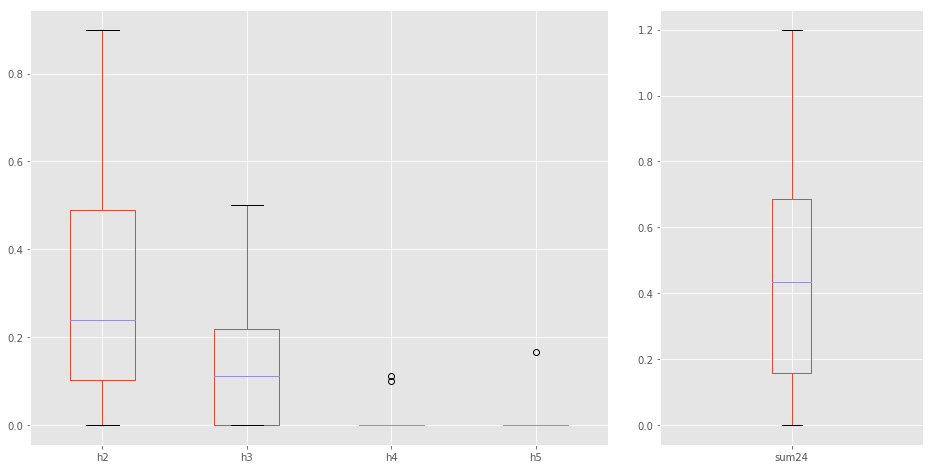

### Results for Team Vs. 3'S

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.166667,0.333333,0.0,0.0,0.5
Median,0.166667,0.333333,0.0,0.0,0.5
75 Percentile,0.166667,0.333333,0.0,0.0,0.5


##### Box Plots

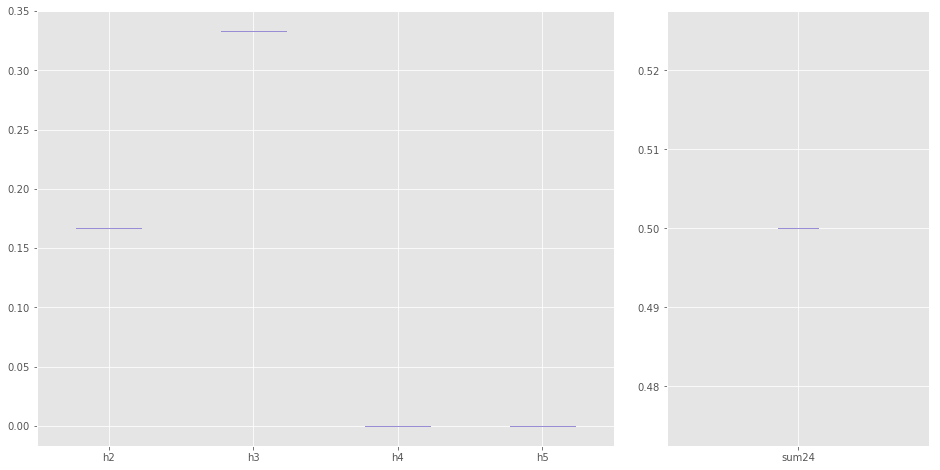

### Results for Team Vs. Def

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.550000,0.280556,0.0,0.0,0.866667
Median,0.700000,0.400000,0.0,0.0,1.050000
75 Percentile,0.891667,0.458333,0.1,0.1,1.325000


##### Box Plots

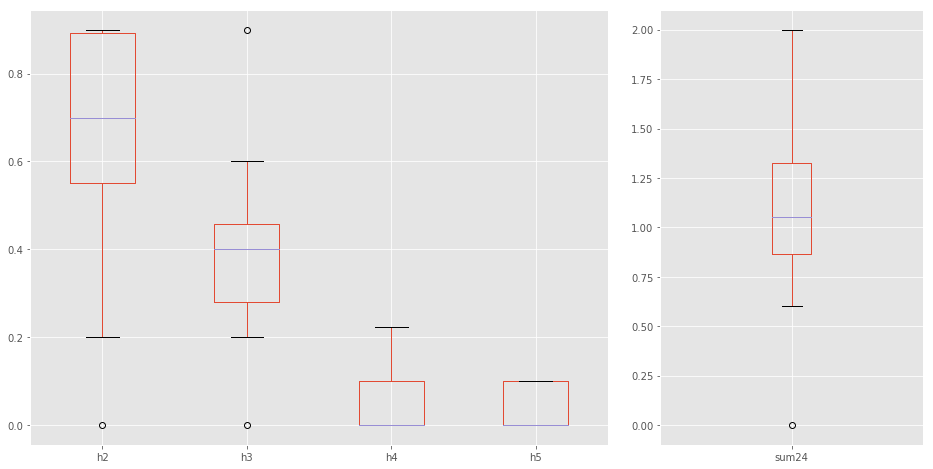

### Results for Team Vs. Defense

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0
75 Percentile,0.0,0.0,0.0,0.0,0.0


##### Box Plots

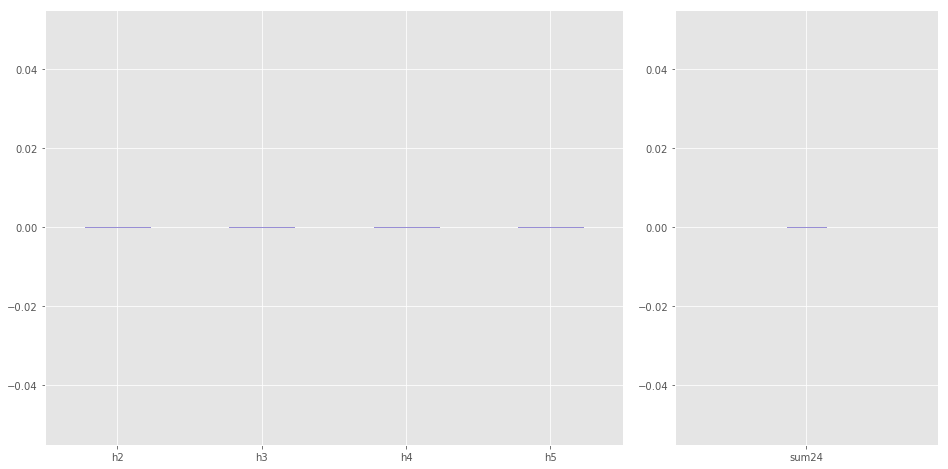

### Results for Team Vs. Offense

  Number of Data Points: 12


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.333333,0.111111,0.000000,0.000000,0.555556
Median,0.422222,0.277778,0.105556,0.000000,0.850000
75 Percentile,0.694444,0.458333,0.133333,0.027778,1.194444


##### Box Plots

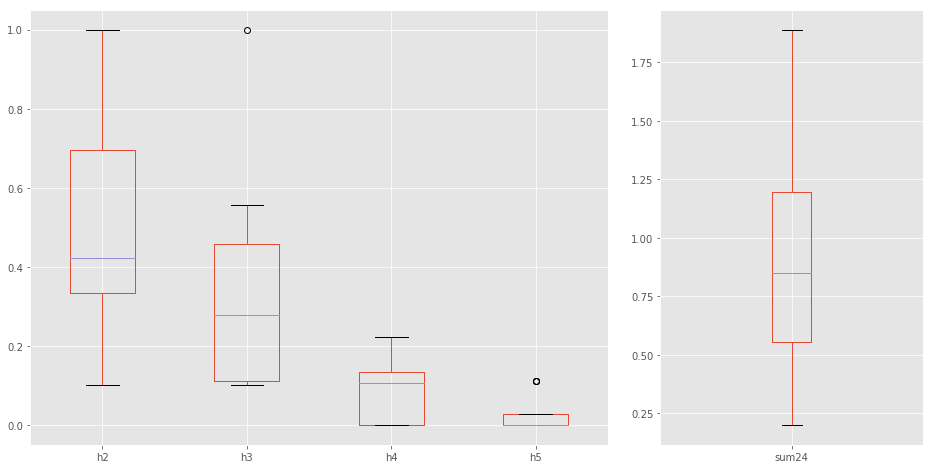

### Results for Team Vs. Scouts

  Number of Data Points: 38


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.272321,0.102778,0.000000,0.000,0.500000
Median,0.524802,0.276984,0.000000,0.000,0.763492
75 Percentile,0.796429,0.450397,0.121528,0.075,1.391369


##### Box Plots

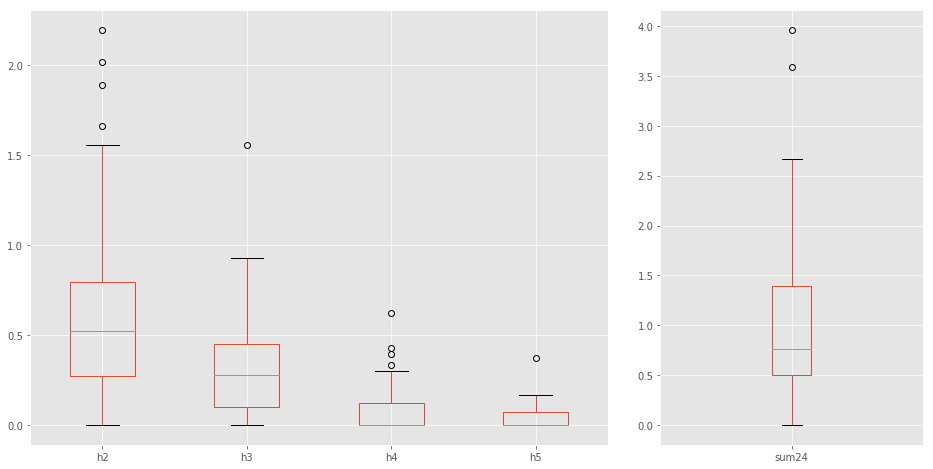

### Results for Team W/ 3S

  Number of Data Points: 13


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.000000,0.000000,0.0,0.0,0.1
Median,0.100000,0.000000,0.0,0.0,0.2
75 Percentile,0.111111,0.111111,0.1,0.0,0.3


##### Box Plots

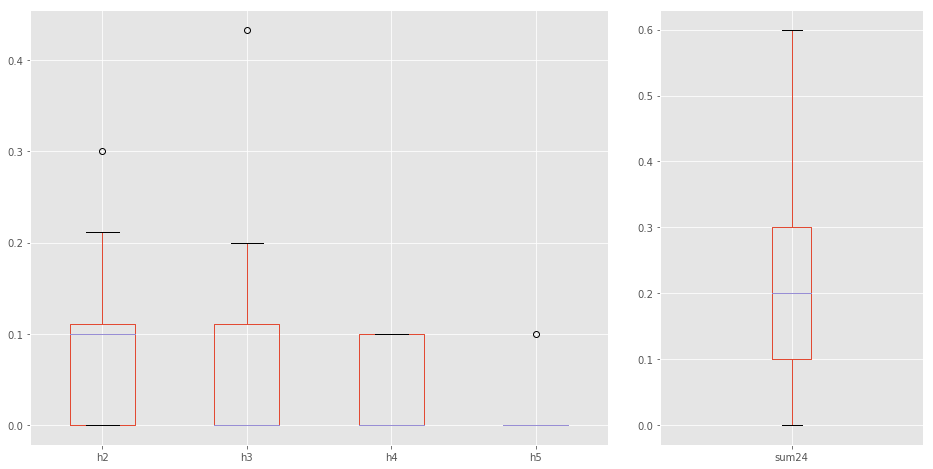

### Results for Tempo/Pap

  Number of Data Points: 1


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.0,0.0,0.125,0.0,0.125
Median,0.0,0.0,0.125,0.0,0.125
75 Percentile,0.0,0.0,0.125,0.0,0.125


##### Box Plots

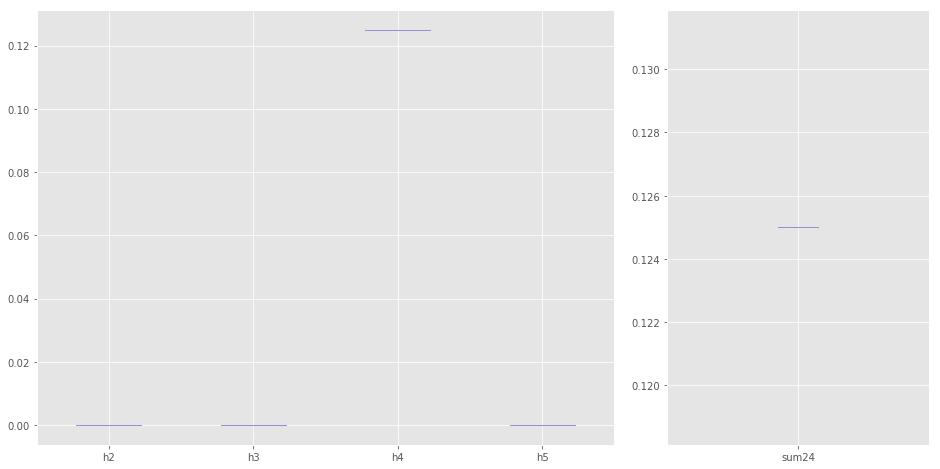

### Results for Vice Pursuit

  Number of Data Points: 2


##### Interquartile and Median Values

,h2,h3,h4,h5,sum24
25 Percentile,0.041667,0.041667,0.0,0.0,0.166667
Median,0.083333,0.083333,0.0,0.0,0.166667
75 Percentile,0.125000,0.125000,0.0,0.0,0.166667


##### Box Plots

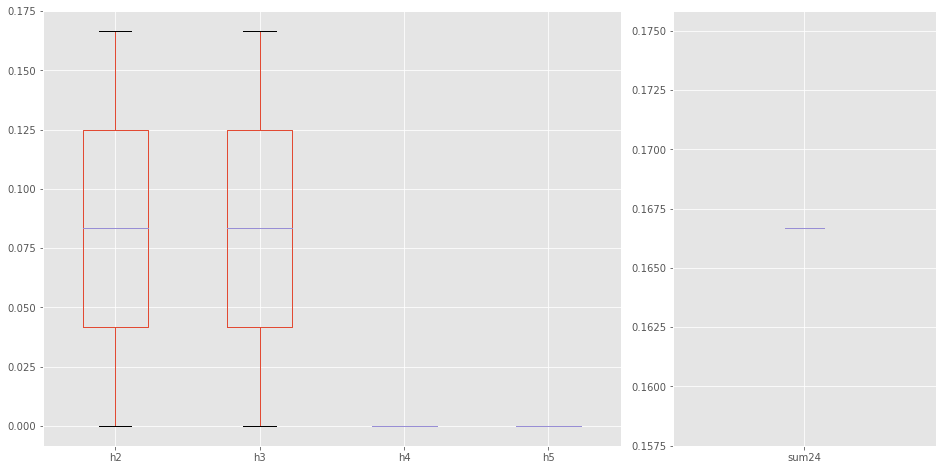

In [220]:
grps = (df_per_activity[df_per_activity.type != 'game']
          .drop(df_per_activity['2017-08-29'].index)
          .drop(df_per_activity['2017-10-04'].index)
          .groupby(['event', 'activity'], as_index=False)[['h2', 'h3', 'h4', 'h5', 'sum24']]
          .sum()
          .groupby(['activity']))
for name, grp in grps:
    printmd('### Results for {}'.format(name.title()))
    #display(grp)
    print('  Number of Data Points: {}'.format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp.quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,3), (0,0), colspan=2)
    grp[['h2', 'h3', 'h4', 'h5']].boxplot()
    plt.subplot2grid((1,3), (0,2))
    grp[['sum24']].boxplot()
    plt.show()

### Question 5a: What is the exposure to hits before and after break across all positions?

The data in the following two questions (5a and 5b) has been normalized by the number of "player-minutes" in the given time period (pre or post break). For example, if there were 10 defensive players who played 8 minutes in the first half of a game (for a subtotal of 80 player-minutes) and 10 offensive players who played 22 minutes in the first half (for a subtotal of 220 player-minutes) the total hits in a given bin for the first half of that game would be divided by 300 player-minutes. This way, game-to-game and half-to-half data can be compared even if the number of players or the number of minutes played changes. A similar normalization has been followed for practice data.

In [250]:
df = pd.read_csv('compiled_by_event_time.csv', index_col='day', parse_dates=True)

(df[df.event_type != 'game']
     .groupby(['event', 'before_break'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break'])
     .aggregate(np.median))

,n2,n3,n4,n5,n34,n24
before_break,,,,,,
post,0.014812,0.007886,0.002081,0.001011,0.009374,0.025447
pre,0.008318,0.002962,0.000648,0.000000,0.003342,0.011994


### Results for Post Break

Number of samples: 40


##### Interquartile and Median Values

,n2,n3,n4,n5,n34,n24
25 Percentile,0.009064,0.004601,0.001012,0.000000,0.007626,0.017500
Median,0.014812,0.007886,0.002081,0.001011,0.009374,0.025447
75 Percentile,0.018191,0.011036,0.003344,0.001822,0.015311,0.031026


##### Box Plots

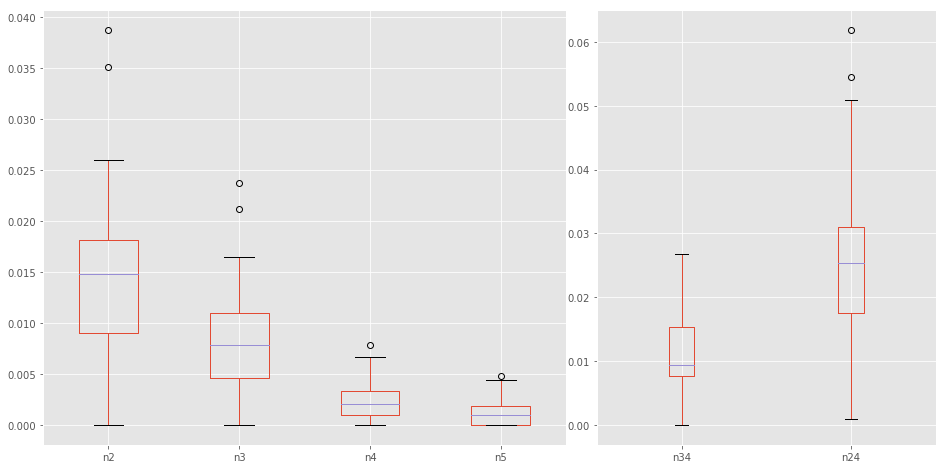

### Results for Pre Break

Number of samples: 56


##### Interquartile and Median Values

,n2,n3,n4,n5,n34,n24
25 Percentile,0.004214,0.001053,0.000000,0.000000,0.001417,0.006268
Median,0.008318,0.002962,0.000648,0.000000,0.003342,0.011994
75 Percentile,0.011276,0.005676,0.001430,0.000642,0.007888,0.018864


##### Box Plots

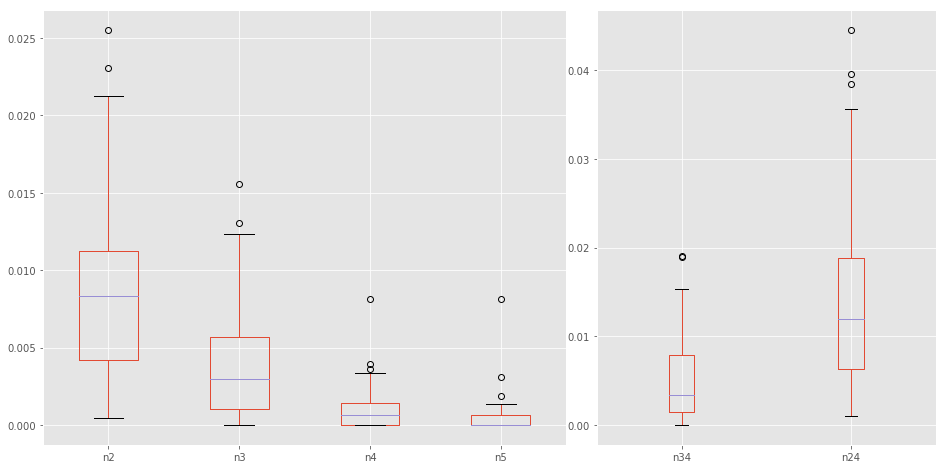

In [231]:
grps = (df[df.event_type != 'game']
     .groupby(['event', 'before_break'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break']))
for name, grp in grps:
    printmd('### Results for {} Break'.format(name.title()))
    print("Number of samples: {}".format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']].quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,5), (0,0), colspan=3)
    grp[['n2', 'n3', 'n4', 'n5']].boxplot()
    plt.subplot2grid((1,5), (0,3), colspan=3)
    grp[['n34', 'n24']].boxplot()
    plt.show()

### Question 5b: What is the exposure to hits before and after halftime across all positions?

Same question as above, this time for game data. 

In [232]:
(df[df.event_type == 'game']
     .groupby(['event', 'before_break'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break'])
     .aggregate(np.median))

,n2,n3,n4,n5,n34,n24
before_break,,,,,,
post,0.135318,0.100748,0.029089,0.016104,0.125365,0.279833
pre,0.170907,0.118729,0.049865,0.012919,0.172514,0.359173


### Results for Post Half

Number of samples: 12


##### Interquartile and Median Values

,n2,n3,n4,n5,n34,n24
25 Percentile,0.128356,0.072500,0.020824,0.011676,0.096296,0.230278
Median,0.135318,0.100748,0.029089,0.016104,0.125365,0.279833
75 Percentile,0.151782,0.117185,0.034494,0.020169,0.166210,0.317574


##### Box Plots

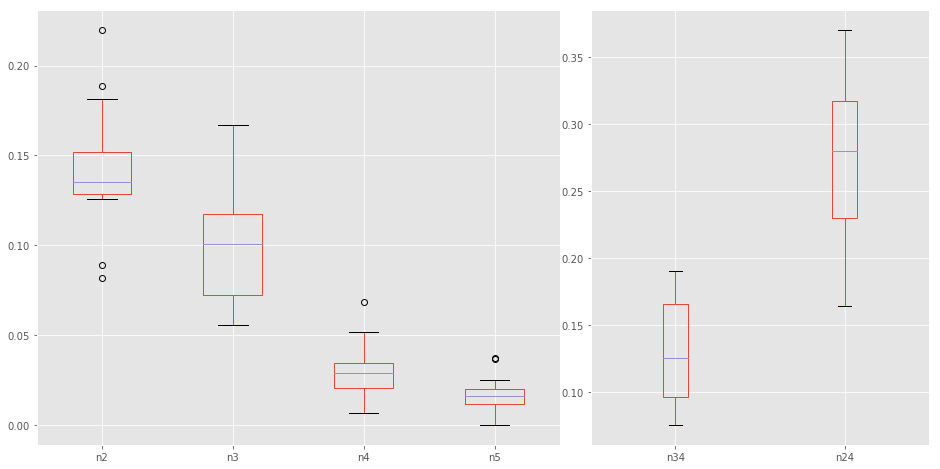

### Results for Pre Half

Number of samples: 12


##### Interquartile and Median Values

,n2,n3,n4,n5,n34,n24
25 Percentile,0.163065,0.100186,0.033909,0.010405,0.135644,0.321925
Median,0.170907,0.118729,0.049865,0.012919,0.172514,0.359173
75 Percentile,0.235000,0.136759,0.058976,0.022041,0.190000,0.393425


##### Box Plots

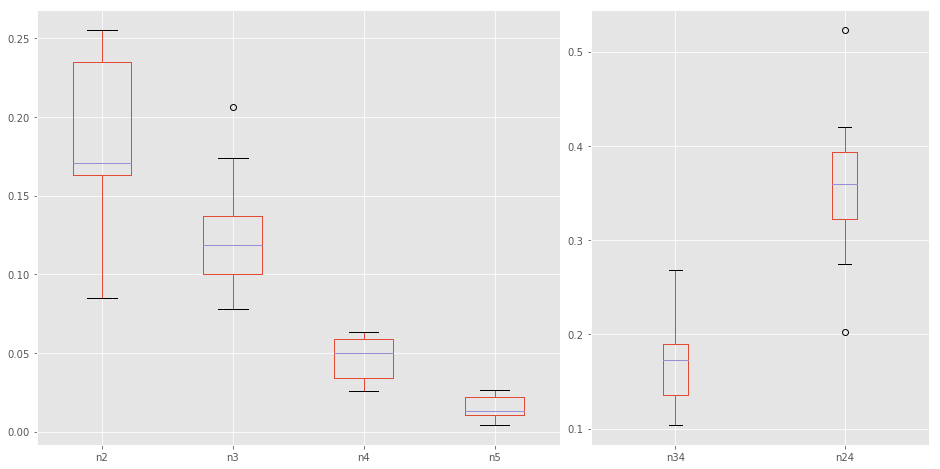

In [233]:
grps = (df[df.event_type == 'game']
     .groupby(['event', 'before_break'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break']))
for name, grp in grps:
    printmd('### Results for {} Half'.format(name.title()))
    print("Number of samples: {}".format(grp.shape[0]))
    # Give the median and interquartile ranges
    printmd('##### Interquartile and Median Values')
    dat = grp[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']].quantile([0.25, 0.50, 0.75])
    dat.index = pd.Index(['25 Percentile', 'Median', '75 Percentile'])
    display(dat)
    printmd('##### Box Plots')
    fig = plt.figure(figsize=(16, 8))
    plt.subplot2grid((1,5), (0,0), colspan=3)
    grp[['n2', 'n3', 'n4', 'n5']].boxplot()
    plt.subplot2grid((1,5), (0,3), colspan=3)
    grp[['n34', 'n24']].boxplot()
    plt.show()

## Statistical Tests

Here, we'll look at if there is a statistically significant difference between the the number of hits a player receives before and after the break in practice by hit strength. A similar test will be run for games using half time as the delimiter. Finally, we'll compare the hits received by practice type (Tuesday, Wednesday, etc) to determine if a player is at more statisically significant risk of receiving a hit of a given strength during any particular practice.


### Before and After Break in Practice (Regardless of Type)

In [286]:
df = pd.read_csv('compiled_by_event_time_for_stats.csv', index_col='day', parse_dates=True)
grps = (df[df.event_type != 'game']
     .groupby(['event', 'before_break', 'event_type'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break']))

In [287]:
wilcoxon(grps.get_group('pre')['n2'], grps.get_group('post')['n2'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=92.0, pvalue=1.9757667419124095e-05)

In [268]:
wilcoxon(grps.get_group('pre')['n3'], grps.get_group('post')['n3'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=28.0, pvalue=2.9306213237242489e-07)

In [269]:
wilcoxon(grps.get_group('pre')['n4'], grps.get_group('post')['n4'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=133.0, pvalue=0.000201986692996235)

In [270]:
wilcoxon(grps.get_group('pre')['n5'], grps.get_group('post')['n5'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=118.0, pvalue=8.9202809852034667e-05)

In [275]:
wilcoxon(grps.get_group('pre')['n24'], grps.get_group('post')['n24'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=30.0, pvalue=3.3791296933980453e-07)

In [276]:
wilcoxon(grps.get_group('pre')['n34'], grps.get_group('post')['n34'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=29.0, pvalue=3.1471705540560375e-07)

### First and Second Half of Games

In [288]:
grps = (df[df.event_type == 'game']
     .groupby(['event', 'before_break', 'event_type'], as_index=False)[['n2', 'n3', 'n4', 'n5', 'n34', 'n24']]
     .sum()
     .groupby(['before_break']))

In [290]:
wilcoxon(grps.get_group('pre')['n2'], grps.get_group('post')['n2'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=9.0, pvalue=0.020658377241239013)

In [291]:
wilcoxon(grps.get_group('pre')['n3'], grps.get_group('post')['n3'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=19.0, pvalue=0.12608955395259033)

In [292]:
wilcoxon(grps.get_group('pre')['n4'], grps.get_group('post')['n4'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=6.0, pvalue=0.010787449254670366)

In [293]:
wilcoxon(grps.get_group('pre')['n5'], grps.get_group('post')['n5'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=33.0, pvalue=0.66613720448831715)

In [294]:
wilcoxon(grps.get_group('pre')['n24'], grps.get_group('post')['n24'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=7.0, pvalue=0.01347119701821317)

In [295]:
wilcoxon(grps.get_group('pre')['n34'], grps.get_group('post')['n34'], zero_method='pratt', correction=True)

WilcoxonResult(statistic=13.0, pvalue=0.045458752343819665)